# BIG DATA AND DATA MINING ASSIGNMENT NOTEBOOK
# IKO TAMBAYA

# Setting Up the Environment

In [1]:
#!pip install sqlite3

# Import Necessary Libraries

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import folium
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
class ValueWarning(Warning):
    pass
warnings.filterwarnings("ignore", category=ValueWarning)
import itertools
import networkx as nx
from matplotlib.collections import LineCollection
import community as community_louvain
from sklearn.metrics import mean_absolute_error

# Connect to SQLite Database

In [3]:
# Connect to SQLite database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")
cursor = conn.cursor()

#conn.close()

# EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
# Check the available tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

Tables in the database: [('accident',), ('casualty',), ('vehicle',), ('lsoa',)]


In [5]:
# Query to list all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the names of the tables
print("Tables in the database:")
for table in tables:
    print(table[0])

# For each table, fetch and display the schema
for table in tables:
    print(f"\nSchema for table: {table[0]}")
    cursor.execute(f"PRAGMA table_info({table[0]});")
    schema = cursor.fetchall()
    print(f"{'Column Name':<20} {'Data Type':<15} {'Not Null':<10} {'Default Value'}")
    for column in schema:
        print(f"{column[1]:<20} {column[2]:<15} {column[3]:<10} {column[4]}")

Tables in the database:
accident
casualty
vehicle
lsoa

Schema for table: accident
Column Name          Data Type       Not Null   Default Value
accident_index                       0          None
accident_year                        0          None
accident_reference                   0          None
location_easting_osgr                 0          None
location_northing_osgr                 0          None
longitude                            0          None
latitude                             0          None
police_force                         0          None
accident_severity                    0          None
number_of_vehicles                   0          None
number_of_casualties                 0          None
date                                 0          None
day_of_week                          0          None
time                                 0          None
local_authority_district                 0          None
local_authority_ons_district                 0       

In [6]:
# Query to count rows in each table
tables = ['accident', 'vehicle', 'casualty', 'lsoa']
table_lengths = {}

for table in tables:
    cursor.execute(f"SELECT COUNT(*) FROM {table}")
    count = cursor.fetchone()[0]
    table_lengths[table] = count

# Print the length of each table
print("Table Lengths:", table_lengths)

Table Lengths: {'accident': 461352, 'vehicle': 849091, 'casualty': 600332, 'lsoa': 34378}


# Key columns and Relationships

# FILTERING DATA FOR THE YEAR 2020

In [7]:
# Query to filter accidents for the year 2020
query_accidents_2020 = "SELECT * FROM accident WHERE accident_year = 2020;"
accidents_2020 = pd.read_sql_query(query_accidents_2020, conn)

# Display the first few rows
print("Filtered Accidents Table (2020):")
print(accidents_2020.head())

Filtered Accidents Table (2020):
  accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  ...  \
0                  3                   1  ...   
1              

In [8]:
# Filter casualty table for 2020 accidents based on accident_index
query_casualty_2020 = """
SELECT *
FROM casualty
WHERE accident_index IN (SELECT accident_index FROM accident WHERE accident_year = 2020);
"""
casualty_2020 = pd.read_sql_query(query_casualty_2020, conn)

# Filter vehicle table for 2020 accidents
query_vehicle_2020 = """
SELECT *
FROM vehicle
WHERE accident_index IN (SELECT accident_index FROM accident WHERE accident_year = 2020);
"""
vehicle_2020 = pd.read_sql_query(query_vehicle_2020, conn)

print("Filtered Casualty Table (2020):")
print(casualty_2020.head())

print("Filtered Vehicle Table (2020):")
print(vehicle_2020.head())

Filtered Casualty Table (2020):
   casualty_index accident_index  accident_year accident_reference  \
0          484748  2020010219808           2020          010219808   
1          484749  2020010220496           2020          010220496   
2          484750  2020010220496           2020          010220496   
3          484751  2020010228005           2020          010228005   
4          484752  2020010228006           2020          010228006   

   vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                  1                   1               3                1   
1                  1                   1               3                2   
2                  1                   2               3                2   
3                  1                   1               3                1   
4                  1                   1               3                1   

   age_of_casualty  age_band_of_casualty  casualty_severity  \
0               31   

# DATA CLEANING 

In [9]:
# Tables with accident_year column
tables_with_year = ['accident', 'casualty', 'vehicle']

for table in tables_with_year:
    query = f"SELECT * FROM {table} WHERE accident_year = 2020;"
    df = pd.read_sql_query(query, conn)

    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    print(f"\nTable: {table} (Year 2020)")
    print(f"Number of duplicate rows: {duplicate_count}")

    # Check for missing values
    missing_summary = df.isnull().sum()
    print("Missing values per column:")
    print(missing_summary)

# Load and inspect the lsoa table
query_lsoa = "SELECT * FROM lsoa;"
lsoa_df = pd.read_sql_query(query_lsoa, conn)

# Check for duplicates and missing values
duplicate_count_lsoa = lsoa_df.duplicated().sum()
missing_summary_lsoa = lsoa_df.isnull().sum()

print("\nTable: lsoa")
print(f"Number of duplicate rows: {duplicate_count_lsoa}")
print("Missing values per column:")
print(missing_summary_lsoa)


Table: accident (Year 2020)
Number of duplicate rows: 0
Missing values per column:
accident_index                                  0
accident_year                                   0
accident_reference                              0
location_easting_osgr                          14
location_northing_osgr                         14
longitude                                      14
latitude                                       14
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_numbe

In [10]:
# List of tables with accident year column
tables_with_year = ['accident', 'casualty', 'vehicle']

# Create an empty dictionary to store the DataFrames
dfs = {}

for table in tables_with_year:
    # Query to fetch data for the year 2020
    query = f"SELECT * FROM {table} WHERE accident_year = 2020;"
    df = pd.read_sql_query(query, conn)

    # Store the DataFrame in the dictionary
    dfs[table] = df

# Load and store the lsoa table (no filtering by year)
query_lsoa = "SELECT * FROM lsoa;"
lsoa_df = pd.read_sql_query(query_lsoa, conn)

# Add the lsoa DataFrame to the dictionary
dfs['lsoa'] = lsoa_df

# Access each DataFrame 
dfs['accident'], dfs['vehicle'], dfs['casualty'], dfs['lsoa']


(      accident_index  accident_year accident_reference  location_easting_osgr  \
 0      2020010219808           2020          010219808               521389.0   
 1      2020010220496           2020          010220496               529337.0   
 2      2020010228005           2020          010228005               526432.0   
 3      2020010228006           2020          010228006               538676.0   
 4      2020010228011           2020          010228011               529324.0   
 ...              ...            ...                ...                    ...   
 91194  2020991027064           2020          991027064               343034.0   
 91195  2020991029573           2020          991029573               257963.0   
 91196  2020991030297           2020          991030297               383664.0   
 91197  2020991030900           2020          991030900               277161.0   
 91198  2020991032575           2020          991032575               240402.0   
 
        locati

In [11]:
# List of tables with accident year column
tables_with_year = ['accident', 'casualty', 'vehicle']

# Create an empty dictionary to store the DataFrames
dfs = {}

for table in tables_with_year:
    # Query to fetch data for the year 2020
    query = f"SELECT * FROM {table} WHERE accident_year = 2020;"
    df = pd.read_sql_query(query, conn)

    # Replace NaN in numerical columns with -9999
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numerical_columns] = df[numerical_columns].fillna(-9999)

    # Replace NaN in categorical columns with 'unknown'
    categorical_columns = df.select_dtypes(include=['object']).columns
    df[categorical_columns] = df[categorical_columns].fillna('unknown')

    # Store the DataFrame in the dictionary
    dfs[table] = df

# Load and store the lsoa table (no filtering by year)
query_lsoa = "SELECT * FROM lsoa;"
lsoa_df = pd.read_sql_query(query_lsoa, conn)

# Replace NaN in numerical columns with -9999 for lsoa table
numerical_columns_lsoa = lsoa_df.select_dtypes(include=['float64', 'int64']).columns
lsoa_df[numerical_columns_lsoa] = lsoa_df[numerical_columns_lsoa].fillna(-9999)

# Replace NaN in categorical columns with 'unknown' for lsoa table
categorical_columns_lsoa = lsoa_df.select_dtypes(include=['object']).columns
lsoa_df[categorical_columns_lsoa] = lsoa_df[categorical_columns_lsoa].fillna('unknown')

# Add the lsoa DataFrame to the dictionary
dfs['lsoa'] = lsoa_df

# Access each DataFrame
dfs['accident'], dfs['vehicle'], dfs['casualty'], dfs['lsoa']

(      accident_index  accident_year accident_reference  location_easting_osgr  \
 0      2020010219808           2020          010219808               521389.0   
 1      2020010220496           2020          010220496               529337.0   
 2      2020010228005           2020          010228005               526432.0   
 3      2020010228006           2020          010228006               538676.0   
 4      2020010228011           2020          010228011               529324.0   
 ...              ...            ...                ...                    ...   
 91194  2020991027064           2020          991027064               343034.0   
 91195  2020991029573           2020          991029573               257963.0   
 91196  2020991030297           2020          991030297               383664.0   
 91197  2020991030900           2020          991030900               277161.0   
 91198  2020991032575           2020          991032575               240402.0   
 
        locati

# TASK 1: Analysis for hours of the day, and days of the week, on which accidents occur

In [12]:
# Query to analyze accident distribution by day of the week and hour of the day
query_accidents_day_hour = """
    SELECT 
        day_of_week,
        strftime('%H', time) AS hour,
        COUNT(*) AS accident_count
    FROM accident
    WHERE time IS NOT NULL
    GROUP BY day_of_week, hour
    ORDER BY day_of_week, hour;
"""
accidents_day_hour = conn.execute(query_accidents_day_hour).fetchall()

# Convert the result into a structured format for analysis
import pandas as pd

columns_day_hour = ["day_of_week", "hour", "accident_count"]
df_accidents_day_hour = pd.DataFrame(accidents_day_hour, columns=columns_day_hour)
df_accidents_day_hour.head()


day_of_week hour  accident_count
0            1   00            1793
1            1   01            1413
2            1   02            1107
3            1   03             944
4            1   04             716

In [13]:
# Access the 'accident' DataFrame
accidents = dfs['accident']

# Ensure 'day_of_week' is valid, If it's numeric, convert to readable day names

if accidents['day_of_week'].dtype in ['int64', 'float64']:
    day_mapping = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 
                   6: 'Friday', 7: 'Saturday', 1: 'Sunday'}
    accidents['day_of_week'] = accidents['day_of_week'].map(day_mapping)

# Extract 'day_of_week' from 'date' 
# Ensure 'date' column is a datetime type

if 'day_of_week' not in accidents.columns or accidents['day_of_week'].isnull().all():
    accidents['date'] = pd.to_datetime(accidents['date'], errors='coerce')
    accidents['day_of_week'] = accidents['date'].dt.day_name()

# Extract 'hour' from 'time'
# Ensure time is parsed properly

accidents['time'] = pd.to_datetime(accidents['time'], format='%H:%M', errors='coerce')
accidents['hour'] = accidents['time'].dt.hour

# Group and count accidents by hour and day of the week
hourly_accidents = accidents.groupby('hour').size().reset_index(name='accident_count')
daily_accidents = accidents.groupby('day_of_week').size().reset_index(name='accident_count')

# Order days of the week for proper visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_accidents['day_of_week'] = pd.Categorical(daily_accidents['day_of_week'], categories=day_order, ordered=True)
daily_accidents = daily_accidents.sort_values('day_of_week')

C:\Users\HP\AppData\Local\Temp\ipykernel_6788\3675081610.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='accident_count', data=hourly_accidents, palette='Blues_d')


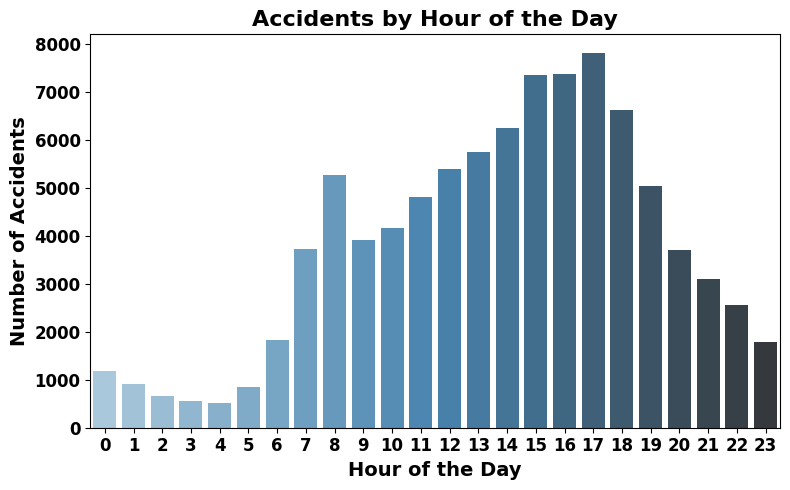

C:\Users\HP\AppData\Local\Temp\ipykernel_6788\3675081610.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='accident_count', data=daily_accidents, palette='Greens_d')


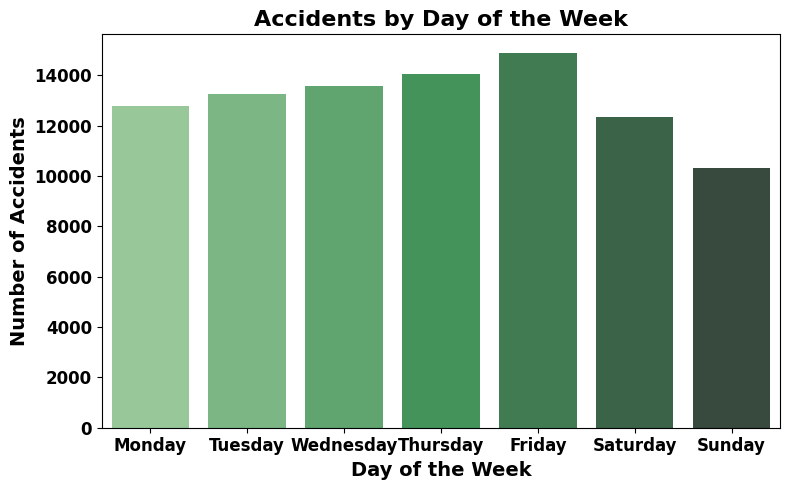

In [14]:
# Visualisation

plt.rc('font', weight='bold')  
plt.rc('axes', titlesize=14, titleweight='bold', labelsize=12, labelweight='bold')  

# Plot accidents by hour

plt.figure(figsize=(8, 5))
sns.barplot(x='hour', y='accident_count', data=hourly_accidents, palette='Blues_d')
plt.title('Accidents by Hour of the Day', fontsize=16, fontweight='bold')  
plt.xlabel('Hour of the Day', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Accidents', fontsize=14, fontweight='bold')  
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12, fontweight='bold')  
plt.tight_layout()
plt.savefig('accidents_by_hour.png')  # Save as a PNG file
plt.show()  # show plot

# Plot accidents by day of the week

plt.figure(figsize=(8, 5))
sns.barplot(x='day_of_week', y='accident_count', data=daily_accidents, palette='Greens_d')
plt.title('Accidents by Day of the Week', fontsize=16, fontweight='bold')  
plt.xlabel('Day of the Week', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Accidents', fontsize=14, fontweight='bold') 
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12, fontweight='bold')  
plt.tight_layout()
plt.savefig('accidents_by_day_of_week.png')  # Save as a PNG file
plt.show()  # show plot

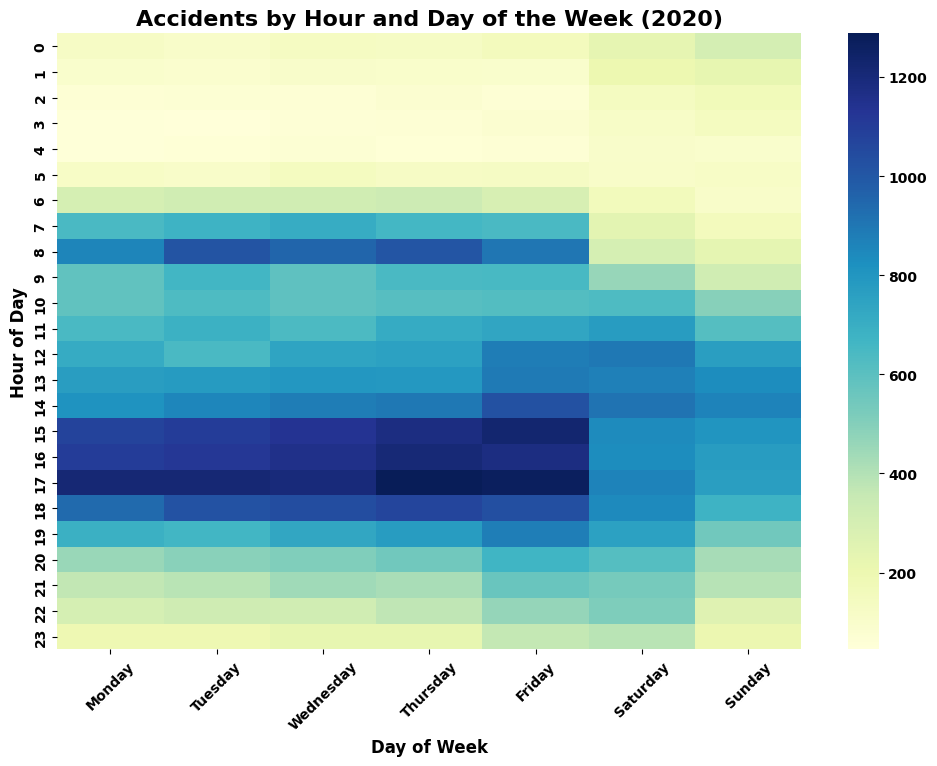

In [15]:
# Group accidents by 'hour' and 'day_of_week' for heatmap data
heatmap_data = accidents.groupby(['hour', 'day_of_week']).size().unstack(fill_value=0)

# Ensure proper day order in columns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[day_order]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Accidents by Hour and Day of the Week (2020)", fontsize=16)
plt.ylabel("Hour of Day", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.xticks(rotation=45)
plt.savefig('accidents_by_hour_of_day_of_week.png')  # Save as a PNG file
plt.show()

# TASK 2: Analysis for Motorbikes

In [16]:
# Access the 'vehicle' and 'accident' DataFrames
vehicles = dfs['vehicle']
accidents = dfs['accident']

# Filter for motorcycles (vehicle_type 3, 4, 5)
motorcycle_types = {3: "125cc and under", 4: "Over 125cc up to 500cc", 5: "Over 500cc"}
motorcycles = vehicles[vehicles['vehicle_type'].isin(motorcycle_types.keys())]

# Join the filtered vehicle data with the accident table
motorcycle_accidents = pd.merge(motorcycles, accidents, on='accident_index', how='inner')

# Process the 'day_of_week' and 'hour' columns
# Map 'day_of_week' codes to readable names
day_mapping = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday',
               6: 'Friday', 7: 'Saturday', 1: 'Sunday'}
motorcycle_accidents['day_of_week'] = motorcycle_accidents['day_of_week'].map(day_mapping)

# Extract 'hour' from 'time'
motorcycle_accidents['time'] = pd.to_datetime(motorcycle_accidents['time'], format='%H:%M', errors='coerce')
motorcycle_accidents['hour'] = motorcycle_accidents['time'].dt.hour

In [17]:
# Check the size of the filtered data
print("Motorcycles 125cc and under (Type 3):", motorcycle_accidents[motorcycle_accidents['vehicle_type'] == 3].shape[0])
print("Motorcycles over 125cc up to 500cc (Type 4):", motorcycle_accidents[motorcycle_accidents['vehicle_type'] == 4].shape[0])
print("Motorcycles over 500cc (Type 5):", motorcycle_accidents[motorcycle_accidents['vehicle_type'] == 5].shape[0])

Motorcycles 125cc and under (Type 3): 7523
Motorcycles over 125cc up to 500cc (Type 4): 1691
Motorcycles over 500cc (Type 5): 3784


Grouped data for Motorcycle 125cc and under (Type 3):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                       
0                 5        5          4         5       4         1       3
1                 2        1          3         5       3         3       5
2                 1        4          2         0       1         4       0
3                 2        2          3         0       3         0       2
4                 0        0          2         0       2         3       3


C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_accidents['hour'] = pd.to_datetime(type_accidents['time'], format='%H:%M', errors='coerce').dt.hour
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_accidents['date'] = pd.to_datetime(type_accidents['date'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:29: SettingWithCopyWarning: 
A value is trying

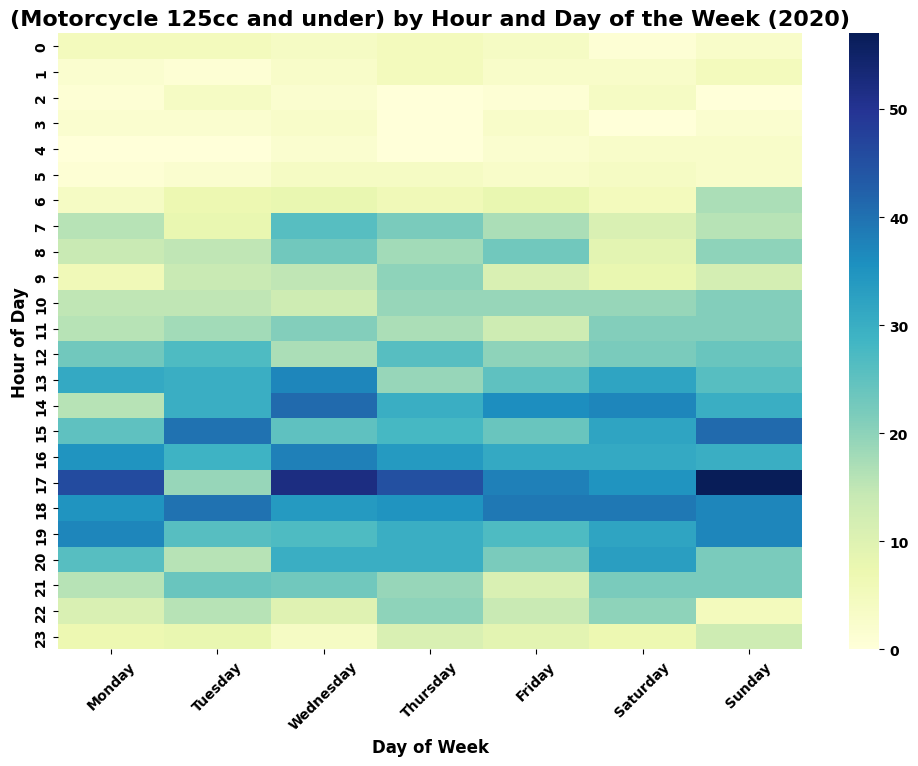

Heatmap for Motorcycle 125cc and under saved as: motorcycle_accidents_heatmap_3_2020.png
Grouped data for Motorcycle over 125cc up to 500cc (Type 4):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                       
0                 0        1          2         4       0         0       1
1                 0        2          4         3       1         1       0
2                 0        0          0         0       1         0       0
3                 0        0          1         0       0         1       0
4                 0        1          0         0       2         0       1


C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_accidents['hour'] = pd.to_datetime(type_accidents['time'], format='%H:%M', errors='coerce').dt.hour
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_accidents['date'] = pd.to_datetime(type_accidents['date'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:29: SettingWithCopyWarning: 
A value is trying

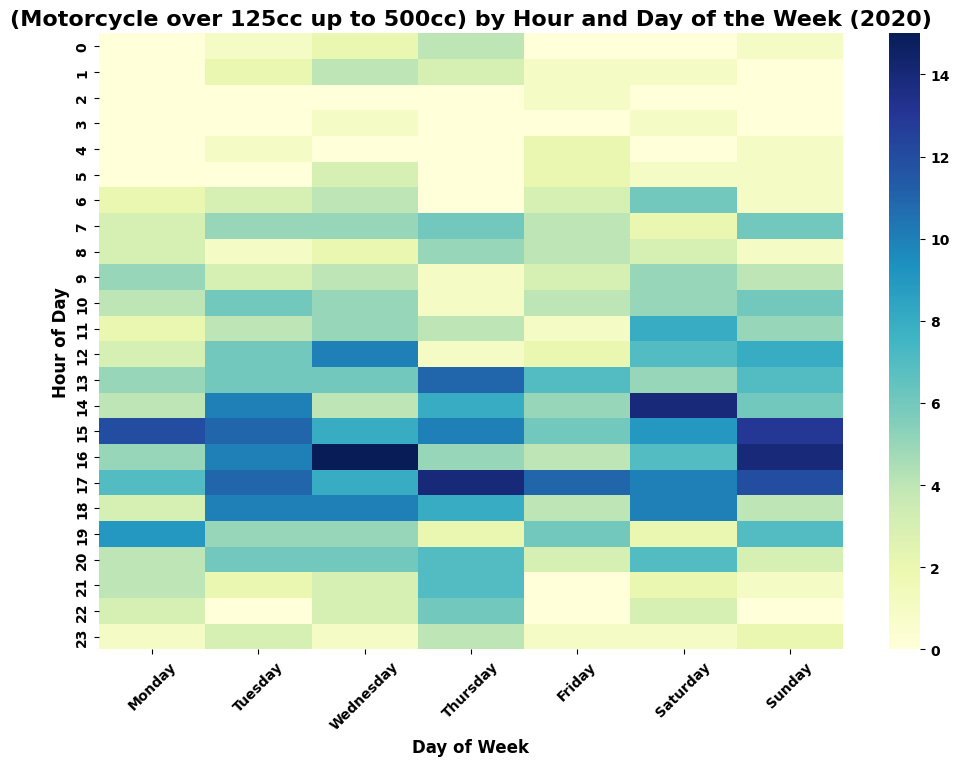

Heatmap for Motorcycle over 125cc up to 500cc saved as: motorcycle_accidents_heatmap_4_2020.png
Grouped data for Motorcycle over 500cc (Type 5):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                       
0                 1        1          1         0       0         3       0
1                 1        3          1         1       0         0       1
2                 0        1          0         0       0         0       1
3                 0        1          2         1       1         0       0
4                 0        0          0         0       0         0       1


C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_accidents['hour'] = pd.to_datetime(type_accidents['time'], format='%H:%M', errors='coerce').dt.hour
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_accidents['date'] = pd.to_datetime(type_accidents['date'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2530941005.py:29: SettingWithCopyWarning: 
A value is trying

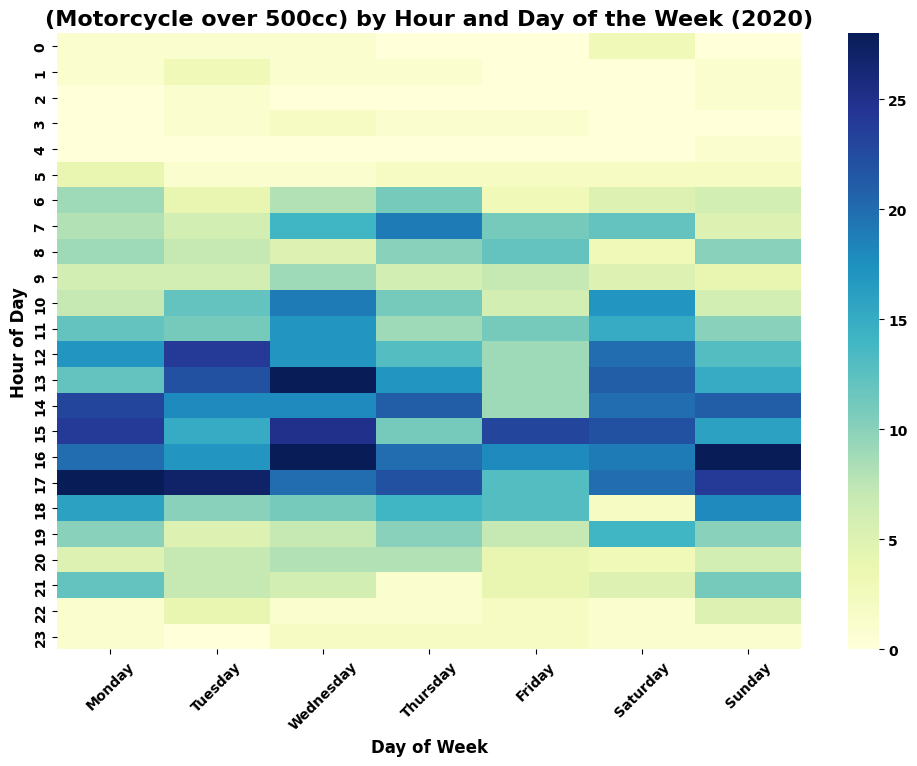

Heatmap for Motorcycle over 500cc saved as: motorcycle_accidents_heatmap_5_2020.png


In [18]:
# Motorcycle types
motorcycle_types = {3: 'Motorcycle 125cc and under', 
                    4: 'Motorcycle over 125cc up to 500cc', 
                    5: 'Motorcycle over 500cc'}

# Day of week mapping 
day_mapping = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday',
               6: 'Friday', 7: 'Saturday', 1: 'Sunday'}

# Iterate through each motorcycle type and generate the heatmap
for vehicle_type, label in motorcycle_types.items():
    # Filter accidents for the specific vehicle type (motorcycles)
    type_accidents = motorcycle_accidents[motorcycle_accidents['vehicle_type'] == vehicle_type]
    
    if type_accidents.empty:
        print(f"No data for {label} (Type {vehicle_type}). Skipping...")
        continue  # Skip if no data for this type
    
    # Ensure 'hour' and 'day_of_week' are correctly derived
    type_accidents['hour'] = pd.to_datetime(type_accidents['time'], format='%H:%M', errors='coerce').dt.hour
    
    # Map numeric day_of_week to readable names
    if type_accidents['day_of_week'].dtype in ['int64', 'float64']:
        type_accidents['day_of_week'] = type_accidents['day_of_week'].map(day_mapping)
    
    # If 'day_of_week' is still missing after mapping, extract from 'date'
    if type_accidents['day_of_week'].isnull().any():
        type_accidents['date'] = pd.to_datetime(type_accidents['date'], errors='coerce')
        type_accidents['day_of_week'] = type_accidents['date'].dt.day_name()

    # Group by hour and day of the week, count accidents
    type_hour_day = type_accidents.groupby(['hour', 'day_of_week']).size().unstack(fill_value=0)
    
    # Ensure the days of the week are ordered correctly
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    type_hour_day = type_hour_day.reindex(columns=day_order)
    
    # Check the resulting table 
    print(f"Grouped data for {label} (Type {vehicle_type}):")
    print(type_hour_day.head())  # Print the first few rows
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(type_hour_day, cmap="YlGnBu", annot=False, cbar=True)
    plt.title(f"({label}) by Hour and Day of the Week (2020)", fontsize=16)
    plt.ylabel("Hour of Day", fontsize=12)
    plt.xlabel("Day of Week", fontsize=12)
    plt.xticks(rotation=45)
        
    # Save the heatmap image
    heatmap_filename = f"motorcycle_accidents_heatmap_{vehicle_type}_2020.png"
    plt.savefig(heatmap_filename)
    plt.show()  
    
    # Output the filenames
    print(f"Heatmap for {label} saved as: {heatmap_filename}")

# TASK 3: Analysis for Pedestrians

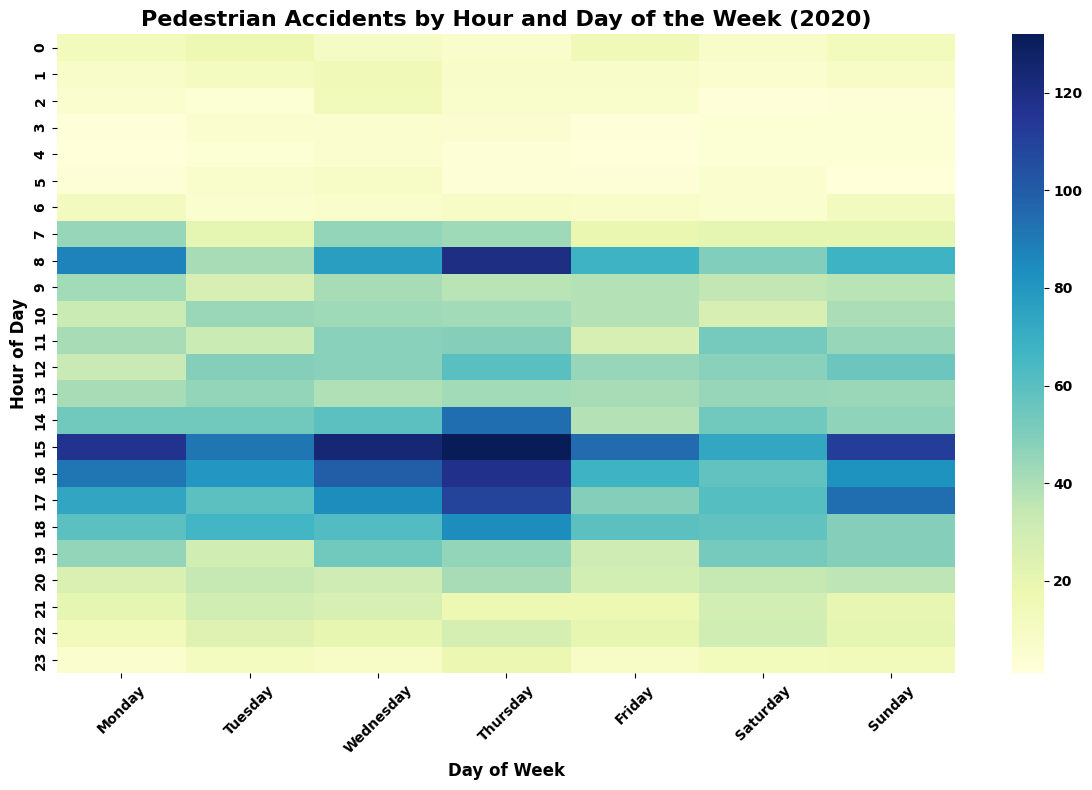

C:\Users\HP\AppData\Local\Temp\ipykernel_6788\1475334847.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day_of_week", y="accident_count", data=pedestrian_accidents_grouped, palette="Set2")


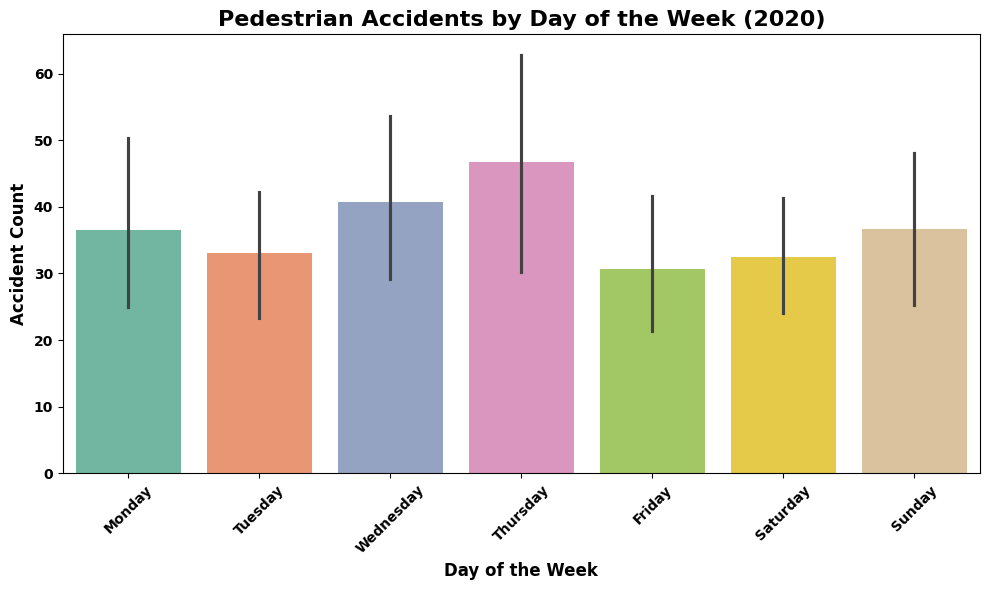

C:\Users\HP\AppData\Local\Temp\ipykernel_6788\1475334847.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hour", y="accident_count", data=pedestrian_accidents_grouped, palette="Set2")


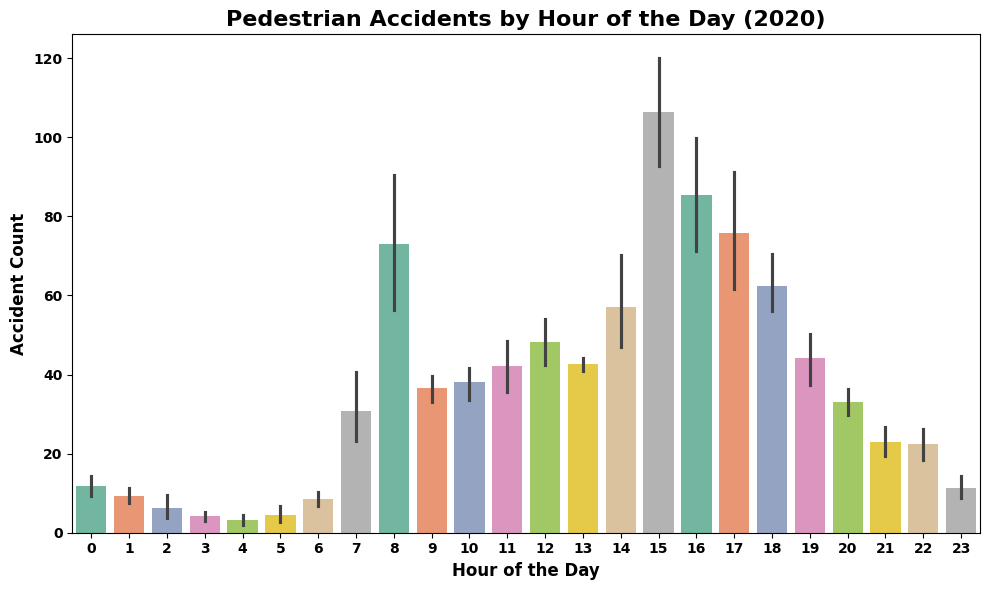

Heatmap saved as: pedestrian_accidents_heatmap_2020.png
Day of the week bar plot saved as: pedestrian_accidents_day_bar_plot_2020.png
Hour of the day bar plot saved as: pedestrian_accidents_hour_bar_plot_2020.png


In [19]:
# Dataframes
casualty_df = dfs['casualty']
accident_df = dfs['accident']

# Filter the 'casualty' dataframe for pedestrian accidents (casualty_class == 3)
pedestrian_accidents = casualty_df[casualty_df['casualty_class'] == 3]

# Merge the 'casualty' dataframe with the 'accident' dataframe to get accident details
pedestrian_accidents = pd.merge(pedestrian_accidents, accident_df[['accident_index', 'date', 'time']], on='accident_index', how='left')

# Extract hour and day of the week from the 'time' and 'date' columns
pedestrian_accidents['hour'] = pd.to_datetime(pedestrian_accidents['time'], format='%H:%M', errors='coerce').dt.hour
pedestrian_accidents['date'] = pd.to_datetime(pedestrian_accidents['date'], errors='coerce')
pedestrian_accidents['day_of_week'] = pedestrian_accidents['date'].dt.day_name()

# Group by hour of the day and day of the week, and count pedestrian accidents
pedestrian_accidents_grouped = pedestrian_accidents.groupby(['day_of_week', 'hour']).size().reset_index(name='accident_count')

# Sort the days of the week 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pedestrian_accidents_grouped['day_of_week'] = pd.Categorical(pedestrian_accidents_grouped['day_of_week'], categories=day_order, ordered=True)

# Create a pivot table for the heatmap
type_hour_day = pedestrian_accidents_grouped.pivot(index='hour', columns='day_of_week', values='accident_count').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(type_hour_day, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Pedestrian Accidents by Hour and Day of the Week (2020)", fontsize=16)
plt.ylabel("Hour of Day", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the heatmap image
heatmap_filename = "pedestrian_accidents_heatmap_2020.png"
plt.savefig(heatmap_filename)
plt.show()  

# Plot the bar plot for day of the week accident counts
plt.figure(figsize=(10, 6))
sns.barplot(x="day_of_week", y="accident_count", data=pedestrian_accidents_grouped, palette="Set2")
plt.title("Pedestrian Accidents by Day of the Week (2020)", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Accident Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the bar plot image
bar_plot_filename = "pedestrian_accidents_day_bar_plot_2020.png"
plt.savefig(bar_plot_filename)
plt.show()  

# Plot the bar plot for hour of the day accident counts
plt.figure(figsize=(10, 6))
sns.barplot(x="hour", y="accident_count", data=pedestrian_accidents_grouped, palette="Set2")
plt.title("Pedestrian Accidents by Hour of the Day (2020)", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Accident Count", fontsize=12)
plt.tight_layout()

# Save the bar plot image
hour_bar_plot_filename = "pedestrian_accidents_hour_bar_plot_2020.png"
plt.savefig(hour_bar_plot_filename)
plt.show()  

# Output the saved filenames
print(f"Heatmap saved as: {heatmap_filename}")
print(f"Day of the week bar plot saved as: {bar_plot_filename}")
print(f"Hour of the day bar plot saved as: {hour_bar_plot_filename}")

# TASK 4: Apriori Algorithm 

In [20]:
# Can only work on this version
#!pip install mlxtend==0.23.1

# Preprocessing

In [21]:
# DataFrames: accident, vehicle, casualty
accident_df = dfs['accident']
vehicle_df = dfs['vehicle']
casualty_df = dfs['casualty']

# Merge accident and vehicle DataFrames on 'accident_index'
merged_df = accident_df.merge(vehicle_df, on='accident_index', how='inner')

# Merge the resulting DataFrame with the casualty DataFrame on 'accident_index'
merged_df = merged_df.merge(casualty_df, on='accident_index', how='inner')

# List of relevant columns to keep
relevant_columns = [
    'time',  # Time of accident (in hours, if necessary)
    'day_of_week',  # Day of the week
    'vehicle_type',  # Type of vehicle (motorcycles etc.)
    'casualty_type',  # Casualty type, Pedestrian will be mapped to 3
    'speed_limit',  # Speed limit
    'light_conditions',  # Light conditions during the accident
    'weather_conditions',  # Weather conditions
    'road_surface_conditions',  # Road surface conditions
    'sex_of_driver',  # Sex of the driver
    'accident_severity',  # Severity of the accident
]

# Select only the relevant columns
apriori_df = merged_df[relevant_columns]

# Step 4: Process the time column into time periods
apriori_df['time'] = pd.to_datetime(apriori_df['time'], errors='coerce')

def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

apriori_df['time_period'] = apriori_df['time'].dt.hour.apply(categorize_time)

# One-hot encode the 'time_period' column
apriori_df = apriori_df.join(pd.get_dummies(apriori_df['time_period'], prefix='TimePeriod'))

# Drop the original 'time_period' column after encoding
apriori_df = apriori_df.drop(columns=['time_period'])

# Convert 'day_of_week' into binary columns using day names
days_of_week = apriori_df['day_of_week'].unique()  # Get the unique days of the week

# Create binary columns for each day
for day in days_of_week:
    apriori_df[day] = apriori_df['day_of_week'].apply(lambda x: 1 if x == day else 0)

# Convert 'vehicle_type' into binary columns for each category of motorcycle
apriori_df['Motorcycle_125cc_and_under'] = apriori_df['vehicle_type'].apply(lambda x: 1 if x == 3 else 0)
apriori_df['Motorcycle_125_to_500cc'] = apriori_df['vehicle_type'].apply(lambda x: 1 if x == 4 else 0)
apriori_df['Motorcycle_over_500cc'] = apriori_df['vehicle_type'].apply(lambda x: 1 if x == 5 else 0)

# Convert 'casualty_type' for pedestrian involvement
apriori_df['Pedestrian'] = apriori_df['casualty_type'].apply(lambda x: 1 if x == 3 else 0)

# Convert 'speed_limit' into binary columns for relevant speed limits starting from 10
apriori_df['Speed_10'] = apriori_df['speed_limit'].apply(lambda x: 1 if x == 10 else 0)
apriori_df['Speed_20'] = apriori_df['speed_limit'].apply(lambda x: 1 if x == 20 else 0)
apriori_df['Speed_30'] = apriori_df['speed_limit'].apply(lambda x: 1 if x == 30 else 0)
apriori_df['Speed_50'] = apriori_df['speed_limit'].apply(lambda x: 1 if x == 50 else 0)
apriori_df['Speed_60'] = apriori_df['speed_limit'].apply(lambda x: 1 if x == 60 else 0)

# Convert 'light_conditions' into binary columns
apriori_df['Light_Daylight'] = apriori_df['light_conditions'].apply(lambda x: 1 if x == 1 else 0)
apriori_df['Light_Lit'] = apriori_df['light_conditions'].apply(lambda x: 1 if x == 4 else 0)
apriori_df['Light_Unlit'] = apriori_df['light_conditions'].apply(lambda x: 1 if x == 5 else 0)
apriori_df['Light_No_Lighting'] = apriori_df['light_conditions'].apply(lambda x: 1 if x == 6 else 0)
apriori_df['Light_Unknown'] = apriori_df['light_conditions'].apply(lambda x: 1 if x == 7 else 0)
apriori_df['Light_Data_Missing'] = apriori_df['light_conditions'].apply(lambda x: 1 if x == -1 else 0)

# Convert 'weather_conditions' into binary columns
apriori_df['Weather_Fine_No_Winds'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 1 else 0)
apriori_df['Weather_Raining_No_Winds'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 2 else 0)
apriori_df['Weather_Snowing_No_Winds'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 3 else 0)
apriori_df['Weather_Fine_High_Winds'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 4 else 0)
apriori_df['Weather_Raining_High_Winds'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 5 else 0)
apriori_df['Weather_Snowing_High_Winds'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 6 else 0)
apriori_df['Weather_Fog_Mist'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 7 else 0)
apriori_df['Weather_Other'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 8 else 0)
apriori_df['Weather_Unknown'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == 9 else 0)
apriori_df['Weather_Data_Missing'] = apriori_df['weather_conditions'].apply(lambda x: 1 if x == -1 else 0)

# Convert 'road_surface_conditions' into binary columns
apriori_df['Road_Dry'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 1 else 0)
apriori_df['Road_Wet'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 2 else 0)
apriori_df['Road_Snow'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 3 else 0)
apriori_df['Road_Frost_Ice'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 4 else 0)
apriori_df['Road_Flood'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 5 else 0)
apriori_df['Road_Oil_Diesel'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 6 else 0)
apriori_df['Road_Mud'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 7 else 0)
apriori_df['Road_Unknown'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == 9 else 0)
apriori_df['Road_Data_Missing'] = apriori_df['road_surface_conditions'].apply(lambda x: 1 if x == -1 else 0)

# Convert 'sex_of_driver' into binary columns
apriori_df['Sex_Male'] = apriori_df['sex_of_driver'].apply(lambda x: 1 if x == 1 else 0)
apriori_df['Sex_Female'] = apriori_df['sex_of_driver'].apply(lambda x: 1 if x == 2 else 0)
apriori_df['Sex_Not_Known'] = apriori_df['sex_of_driver'].apply(lambda x: 1 if x == 3 else 0)
apriori_df['Sex_Data_Missing'] = apriori_df['sex_of_driver'].apply(lambda x: 1 if x == -1 else 0)

# Define the mapping dictionary
severity_mapping = {
    1: "Accident Fatal",
    2: "Accident Serious",
    3: "Accident Slight"
}

# Replace values in the column
apriori_df['accident_severity'] = apriori_df['accident_severity'].map(severity_mapping)

# Verify the changes
print(apriori_df['accident_severity'].head())

# Define the unique severity levels
severity_levels = ['Accident Fatal', 'Accident Serious', 'Accident Slight']

# Create binary columns for each severity level
for severity in severity_levels:
    apriori_df[severity] = apriori_df['accident_severity'].apply(lambda x: 1 if x == severity else 0)
    
# Ensure all columns in apriori_df are binary
binary_columns = apriori_df.columns[(apriori_df.isin([0, 1]).all())]
apriori_df_binary = apriori_df[binary_columns].dropna()  # Drop missing values if any

C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2137608812.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apriori_df['time'] = pd.to_datetime(apriori_df['time'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\2137608812.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apriori_df['time_period'] = apriori_df['time'].dt.hour.apply(categorize_time)


0     Accident Slight
1     Accident Slight
2     Accident Slight
3     Accident Slight
4    Accident Serious
Name: accident_severity, dtype: object


In [22]:
# Plotting Impact of Weather Conditions on Accident Severity
def plot_association_rules(rules, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(rules['support'], rules['confidence'], alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.grid(True)
    
    # Generate a dynamic filename using the title and current timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    sanitized_title = title.replace(" ", "_").replace(":", "_")
    filename = f"{sanitized_title}_{timestamp}.png"
    
    # Save the figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Figure saved as: {filename}")


# Impact of Time of the Day on Accident Severity

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Impact of Time of Day on Accident Severity:
              antecedents        consequents  antecedent support  \
0    (TimePeriod_Morning)  (Accident Slight)            0.253980   
1  (TimePeriod_Afternoon)  (Accident Slight)            0.449978   
2    (TimePeriod_Evening)  (Accident Slight)            0.167904   
3      (TimePeriod_Night)  (Accident Slight)            0.128138   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.777445  0.199977    0.787375  1.012774  0.002522    1.046706   
1            0.777445  0.353746    0.786140  1.011184  0.003913    1.040659   
2            0.777445  0.130542    0.777478  1.000042  0.000006    1.000148   
3            0.777445  0.093179    0.727183  0.935350 -0.006440    0.815767   

   zhangs_metric  
0       0.016906  
1       0.020110  
2       0.000051  
3      -0.073454  


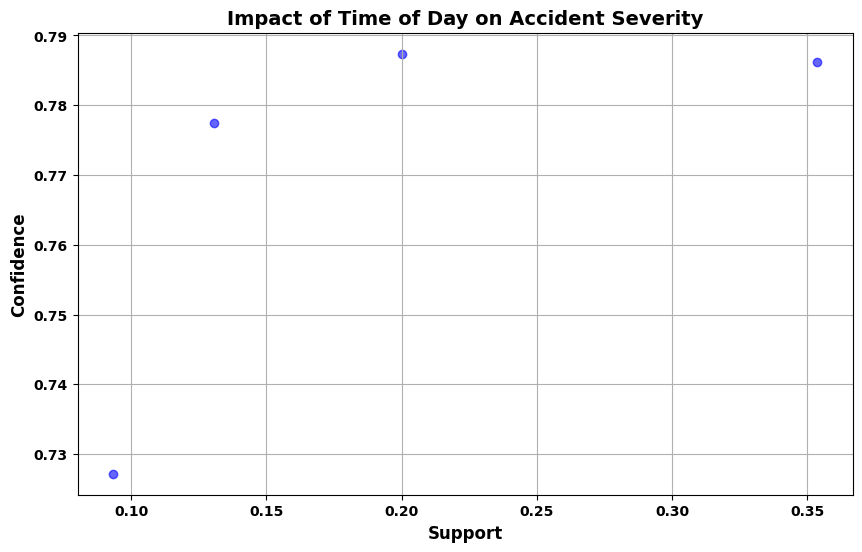

Figure saved as: Impact_of_Time_of_Day_on_Accident_Severity_2024-12-21_22-07-54.png


In [23]:
# Impact of time of the day on accident severity
severity_time_df = apriori_df[['Accident Fatal', 'Accident Serious', 'Accident Slight', 
                               'TimePeriod_Morning', 'TimePeriod_Afternoon', 'TimePeriod_Evening', 'TimePeriod_Night']]

# Apply Apriori to find frequent itemsets
frequent_itemsets_time = apriori(severity_time_df, min_support=0.01, use_colnames=True)

# Generate association rules for accident severity with time of day
rules_time = association_rules(frequent_itemsets_time, metric="confidence", min_threshold=0.7)

# Filter rules where consequents include accident severity
severity_time_rules = rules_time[rules_time['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Time of Day on Accident Severity:")
print(severity_time_rules)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_time_rules, "Impact of Time of Day on Accident Severity")

# Impact of Weather Conditions on Accident Severity

Impact of Time of Day on Accident Severity:
                    antecedents        consequents  antecedent support  \
3       (Weather_Fine_No_Winds)  (Accident Slight)            0.780888   
4    (Weather_Raining_No_Winds)  (Accident Slight)            0.126808   
5     (Weather_Fine_High_Winds)  (Accident Slight)            0.015497   
6  (Weather_Raining_High_Winds)  (Accident Slight)            0.018028   
7               (Weather_Other)  (Accident Slight)            0.027745   
8             (Weather_Unknown)  (Accident Slight)            0.022102   

   consequent support   support  confidence      lift  leverage  conviction  \
3            0.777445  0.604246    0.773794  0.995304 -0.002851    0.983861   
4            0.777445  0.100061    0.789075  1.014959  0.001475    1.055138   
5            0.777445  0.011155    0.719848  0.925915 -0.000893    0.794409   
6            0.777445  0.013705    0.760191  0.977808 -0.000311    0.928054   
7            0.777445  0.022519    0.81164

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


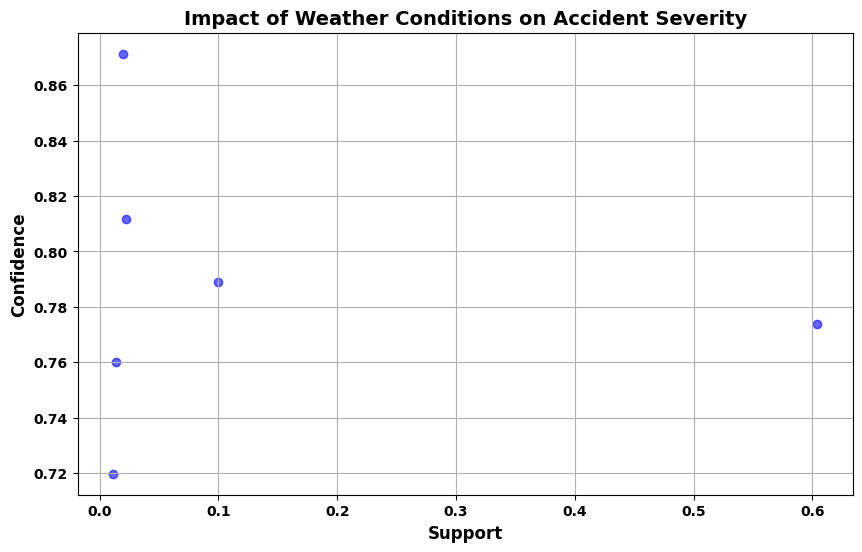

Figure saved as: Impact_of_Weather_Conditions_on_Accident_Severity_2024-12-21_22-07-55.png


In [24]:
# Impact of weather conditions on accident severity
severity_weather_df = apriori_df[['Accident Fatal', 'Accident Serious', 'Accident Slight', 
                                  'Weather_Fine_No_Winds', 'Weather_Raining_No_Winds', 'Weather_Snowing_No_Winds', 
                                  'Weather_Fine_High_Winds', 'Weather_Raining_High_Winds', 'Weather_Snowing_High_Winds', 
                                  'Weather_Fog_Mist', 'Weather_Other', 'Weather_Unknown', 'Weather_Data_Missing']]

# Adjust support and confidence thresholds
frequent_itemsets_weather = apriori(severity_weather_df, min_support=0.01, use_colnames=True)

# Generate association rules with lower confidence threshold
rules_weather = association_rules(frequent_itemsets_weather, metric="confidence", min_threshold=0.7)

# Filter rules where consequents include accident severity
severity_weather_rules = rules_weather[rules_weather['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Time of Day on Accident Severity:")
print(severity_weather_rules)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_weather_rules, "Impact of Weather Conditions on Accident Severity")

#  Impact of Road Surface Conditions on Accident Severity

Impact of Road Surface Conditions on Accident Severity:
  antecedents        consequents  antecedent support  consequent support  \
0  (Road_Dry)  (Accident Slight)            0.685395            0.777445   
1  (Road_Wet)  (Accident Slight)            0.293370            0.777445   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.533726    0.778714  1.001633  0.000870    1.005736       0.005181  
1  0.225931    0.770122  0.990581 -0.002148    0.968144      -0.013278  


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


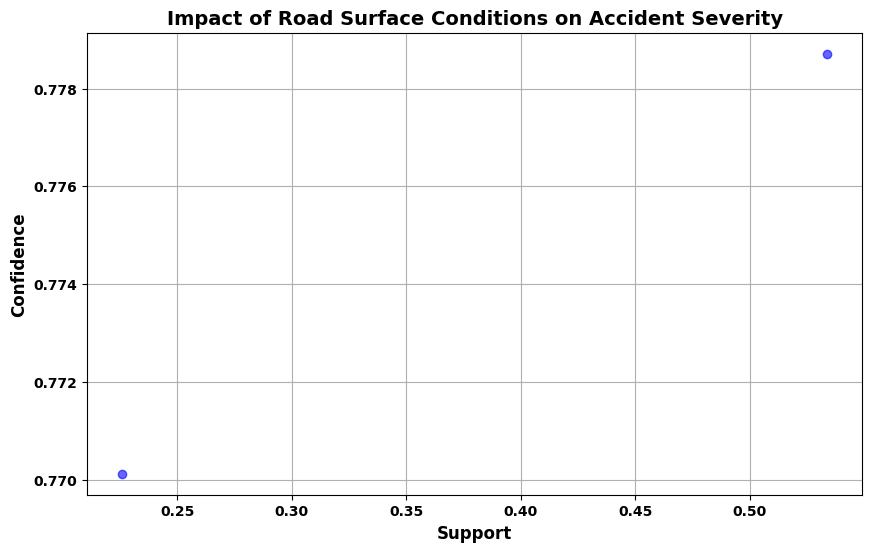

Figure saved as: Impact_of_Road_Surface_Conditions_on_Accident_Severity_2024-12-21_22-07-55.png


In [25]:
# Impact of road surface conditions on accident severity
severity_road_surface_df = apriori_df[['Accident Fatal', 'Accident Serious', 'Accident Slight', 
                                       'Road_Dry', 'Road_Wet', 'Road_Snow', 'Road_Frost_Ice', 
                                       'Road_Flood', 'Road_Oil_Diesel', 'Road_Mud', 'Road_Unknown', 'Road_Data_Missing']]

# Apply Apriori to find frequent itemsets
frequent_itemsets_road_surface = apriori(severity_road_surface_df, min_support=0.01, use_colnames=True)

# Generate association rules for accident severity with road surface conditions
rules_road_surface = association_rules(frequent_itemsets_road_surface, metric="confidence", min_threshold=0.7)

# Filter rules where consequents include accident severity
severity_road_surface_rules = rules_road_surface[rules_road_surface['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Road Surface Conditions on Accident Severity:")
print(severity_road_surface_rules)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_road_surface_rules, "Impact of Road Surface Conditions on Accident Severity")

# Impact of Light Conditions on Accident Severity

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Impact of Light Conditions on Accident Severity:
        antecedents        consequents  antecedent support  \
0  (Light_Daylight)  (Accident Slight)            0.710599   
2       (Light_Lit)  (Accident Slight)            0.206905   
3   (Light_Unknown)  (Accident Slight)            0.021027   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.777445  0.558282    0.785650  1.010554  0.005831    1.038280   
2            0.777445  0.161004    0.778158  1.000917  0.000148    1.003215   
3            0.777445  0.018336    0.872060  1.121701  0.001989    1.739535   

   zhangs_metric  
0       0.036089  
2       0.001156  
3       0.110827  


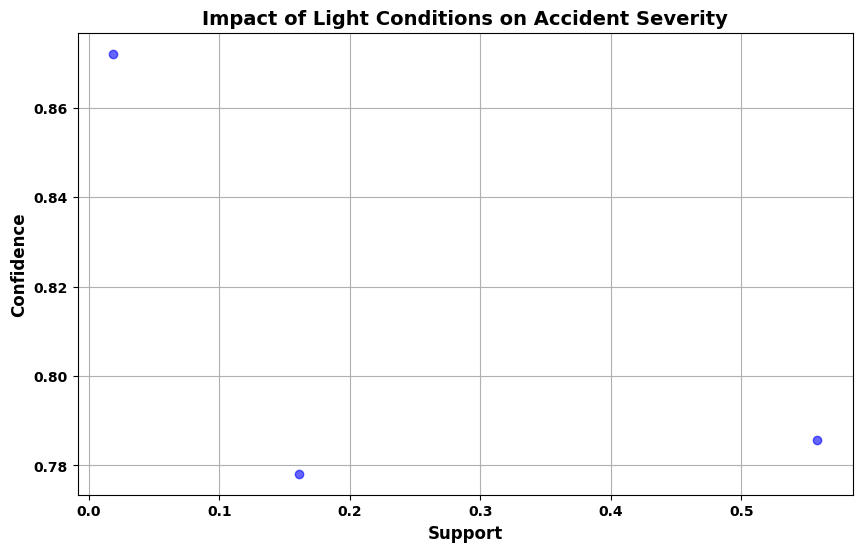

Figure saved as: Impact_of_Light_Conditions_on_Accident_Severity_2024-12-21_22-07-56.png


In [26]:
# Impact of light conditions on accident severity
severity_light_conditions_df = apriori_df[['Accident Fatal', 'Accident Serious', 'Accident Slight', 
                                           'Light_Daylight', 'Light_Lit', 'Light_Unlit', 
                                           'Light_No_Lighting', 'Light_Unknown', 'Light_Data_Missing']]

# Apply Apriori to find frequent itemsets
frequent_itemsets_light = apriori(severity_light_conditions_df, min_support=0.01, use_colnames=True)

# Generate association rules for accident severity with light conditions
rules_light = association_rules(frequent_itemsets_light, metric="confidence", min_threshold=0.7)

# Filter rules where consequents include accident severity
severity_light_rules = rules_light[rules_light['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Light Conditions on Accident Severity:")
print(severity_light_rules)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_light_rules, "Impact of Light Conditions on Accident Severity")

#  Impact of Vehicle (Motorcycle) Type on Accident Severity

Impact of Vehicle Type on Accident Severity:
                    antecedents        consequents  antecedent support  \
0  (Motorcycle_125cc_and_under)  (Accident Slight)             0.03641   

   consequent support  support  confidence      lift  leverage  conviction  \
0            0.777445  0.02721    0.747321  0.961253 -0.001097    0.880784   

   zhangs_metric  
0      -0.040152  


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


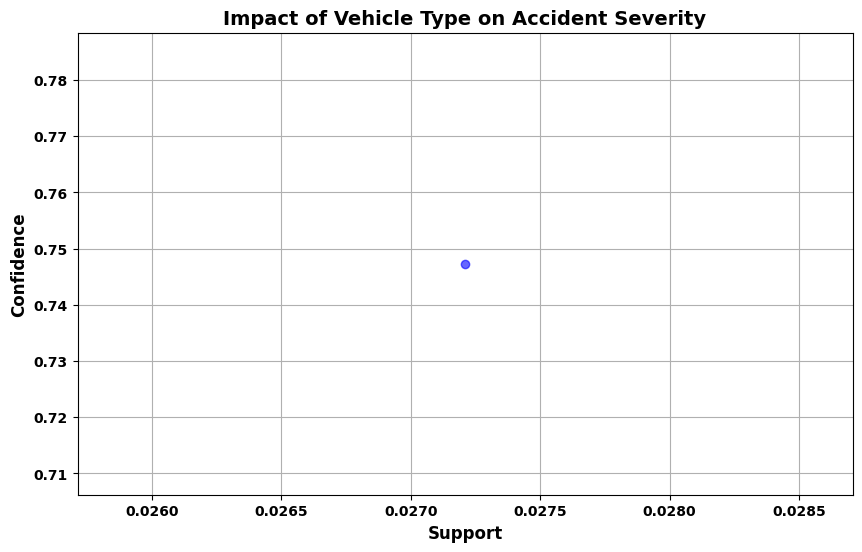

Figure saved as: Impact_of_Vehicle_Type_on_Accident_Severity_2024-12-21_22-07-57.png


In [27]:
# Impact of vehicle type on accident severity
severity_vehicle_type_df = apriori_df[['Accident Fatal', 'Accident Serious', 'Accident Slight', 
                                       'Motorcycle_125cc_and_under', 'Motorcycle_125_to_500cc', 
                                       'Motorcycle_over_500cc']]

# Apply Apriori to find frequent itemsets
frequent_itemsets_vehicle_type = apriori(severity_vehicle_type_df, min_support=0.01, use_colnames=True)

# Generate association rules for accident severity with vehicle type
rules_vehicle_type = association_rules(frequent_itemsets_vehicle_type, metric="confidence", min_threshold=0.7)

# Filter rules where consequents include accident severity
severity_vehicle_type_rules = rules_vehicle_type[rules_vehicle_type['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Vehicle Type on Accident Severity:")
print(severity_vehicle_type_rules)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_vehicle_type_rules, "Impact of Vehicle Type on Accident Severity")

#  Impact of Driver's Gender on Accident Severity

Impact of Driver's Gender on Accident Severity:


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


       antecedents        consequents  antecedent support  consequent support  \
2       (Sex_Male)  (Accident Slight)            0.638175            0.777445   
3     (Sex_Female)  (Accident Slight)            0.260362            0.777445   
4  (Sex_Not_Known)  (Accident Slight)            0.101395            0.777445   

    support  confidence      lift  leverage  conviction  zhangs_metric  
2  0.480636    0.753142  0.968740 -0.015509    0.901552      -0.081880  
3  0.210475    0.808391  1.039806  0.008057    1.161510       0.051758  
4  0.086266    0.850790  1.094341  0.007437    1.491555       0.095936  


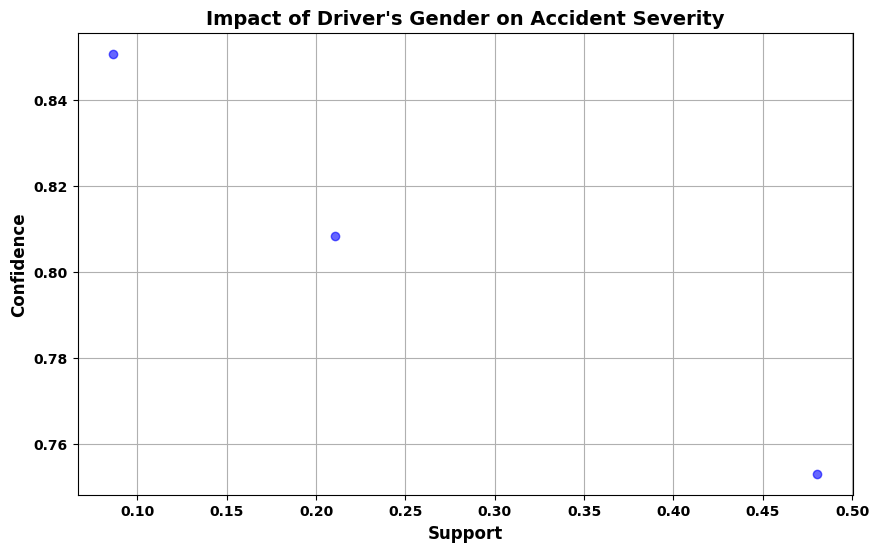

Figure saved as: Impact_of_Driver's_Gender_on_Accident_Severity_2024-12-21_22-07-57.png


In [28]:
# Impact of driver's gender on accident severity
severity_driver_sex_df = apriori_df[['Accident Fatal', 'Accident Serious', 'Accident Slight', 
                                     'Sex_Male', 'Sex_Female', 'Sex_Not_Known', 'Sex_Data_Missing']]

# Apply Apriori to find frequent itemsets
frequent_itemsets_driver_sex = apriori(severity_driver_sex_df, min_support=0.01, use_colnames=True)

# Generate association rules for accident severity with driver's gender
rules_driver_sex = association_rules(frequent_itemsets_driver_sex, metric="confidence", min_threshold=0.7)

# Filter rules where consequents include accident severity
severity_driver_sex_rules = rules_driver_sex[rules_driver_sex['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Driver's Gender on Accident Severity:")
print(severity_driver_sex_rules)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_driver_sex_rules, "Impact of Driver's Gender on Accident Severity")

# Impact of Speed Limit on Accident Severity

Impact of Speed Limit on Accident Severity:
  antecedents        consequents  antecedent support  consequent support  \
0  (Speed_20)  (Accident Slight)            0.102865            0.777445   
1  (Speed_30)  (Accident Slight)            0.542600            0.777445   
2  (Speed_50)  (Accident Slight)            0.051217            0.777445   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.087518    0.850805  1.094361  0.007546    1.491707       0.096111  
1  0.439168    0.809377  1.041074  0.017327    1.167518       0.086256  
2  0.037989    0.741718  0.954047 -0.001830    0.861677      -0.048314  


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


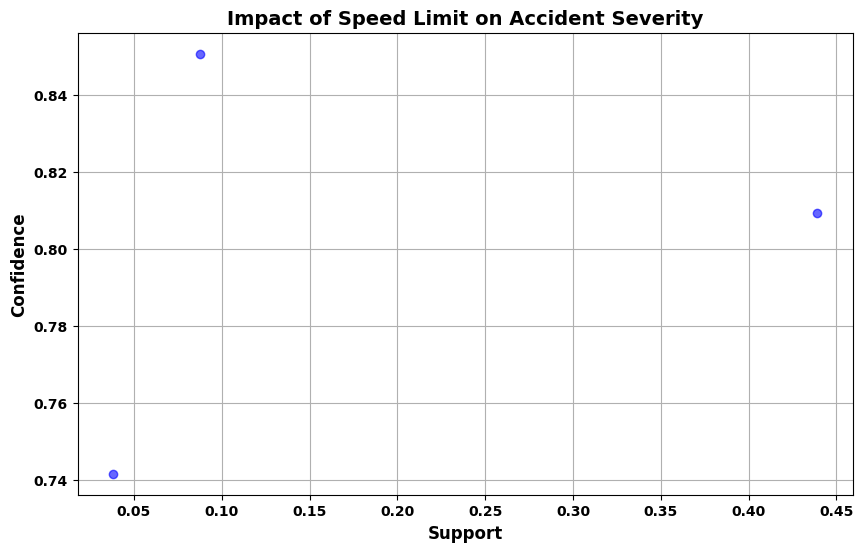

Figure saved as: Impact_of_Speed_Limit_on_Accident_Severity_2024-12-21_22-07-58.png


In [29]:
# Keep only the binary columns for analysis
severity_speed_df = apriori_df[['Speed_10', 'Speed_20', 'Speed_30', 'Speed_50', 'Speed_60',
                                 'Accident Fatal', 'Accident Serious', 'Accident Slight']]

# Apply the Apriori algorithm to generate frequent itemsets
frequent_itemsets_speed = apriori(severity_speed_df, min_support=0.01, use_colnames=True)

# Generate association rules with accident severity in the consequents or antecedents
rules = association_rules(frequent_itemsets_speed, metric="confidence", min_threshold=0.7)

# Filter rules where accident severity is in the antecedents or consequents
severity_rules_speed = rules[rules['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Speed Limit on Accident Severity:")
print(severity_rules_speed)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_rules_speed, "Impact of Speed Limit on Accident Severity")

# Impact of Day of Week on Accident Severity

Impact of Day of Week on Accident Severity:
   antecedents        consequents  antecedent support  consequent support  \
0     (Monday)  (Accident Slight)            0.139166            0.777445   
1    (Tuesday)  (Accident Slight)            0.142858            0.777445   
2  (Wednesday)  (Accident Slight)            0.148307            0.777445   
3   (Thursday)  (Accident Slight)            0.151732            0.777445   
4     (Friday)  (Accident Slight)            0.163032            0.777445   
5   (Saturday)  (Accident Slight)            0.138499            0.777445   
6     (Sunday)  (Accident Slight)            0.116406            0.777445   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.109719    0.788408  1.014102  0.001526    1.051815       0.016154  
1  0.112958    0.790702  1.017053  0.001894    1.063343       0.019561  
2  0.116615    0.786309  1.011401  0.001315    1.041480       0.013236  
3  0.118103    0.778366  1.001185  0.000140    

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


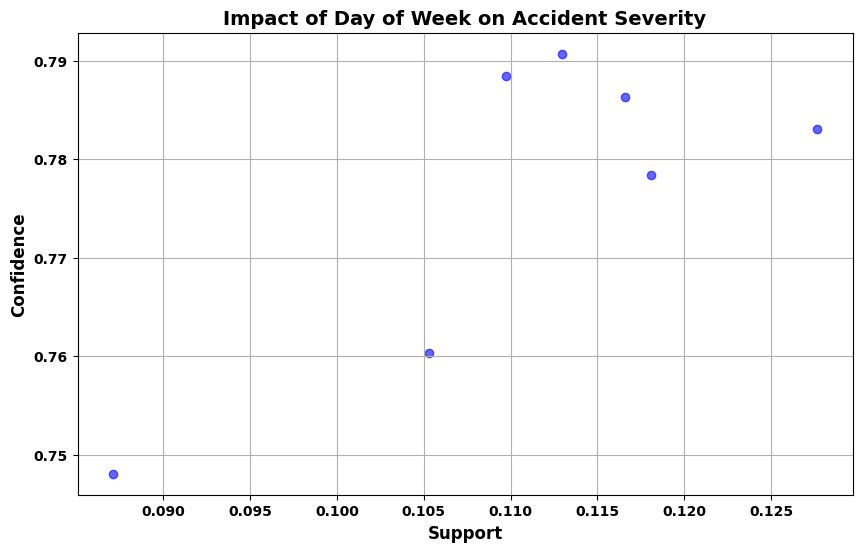

Figure saved as: Impact_of_Day_of_Week_on_Accident_Severity_2024-12-21_22-07-58.png


In [30]:
# Create a DataFrame with only the binary columns related to days of the week and accident severity
severity_week_df = apriori_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Accident Fatal', 'Accident Serious', 'Accident Slight']]

# Apply the Apriori algorithm to generate frequent itemsets with a minimum support threshold of 0.01
frequent_itemsets_week = apriori(severity_week_df, min_support=0.01, use_colnames=True)

# Generate association rules based on the frequent itemsets, with confidence as the metric
rules = association_rules(frequent_itemsets_week, metric="confidence", min_threshold=0.7)

# Filter rules where 'accident_severity' (fatal, serious, or slight) is in the consequents
severity_rules_week = rules[rules['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Day of Week on Accident Severity:")
print(severity_rules_week)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_rules_week, "Impact of Day of Week on Accident Severity")

# Impact of Pedestrian on Accident Severity

Impact of Pedestrian on Accident Severity:
    antecedents        consequents  antecedent support  consequent support  \
0  (Pedestrian)  (Accident Slight)            0.061252            0.777445   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.046372    0.757073  0.973797 -0.001248    0.916141      -0.027865  


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


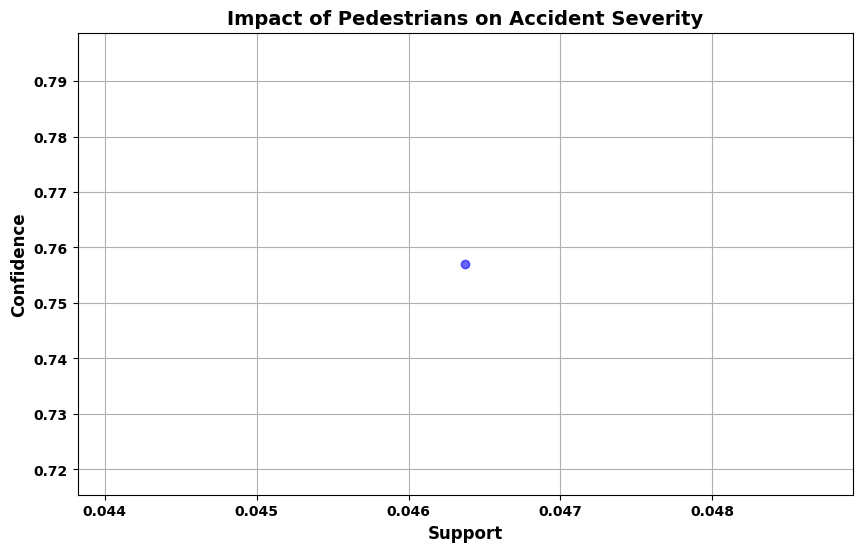

Figure saved as: Impact_of_Pedestrians_on_Accident_Severity_2024-12-21_22-07-59.png


In [31]:
# Create a DataFrame with only the binary columns related to pedestrian involvement and accident severity
severity_pedestrian_df = apriori_df[['Pedestrian', 'Accident Fatal', 'Accident Serious', 'Accident Slight']]

# Apply the Apriori algorithm to generate frequent itemsets with a minimum support threshold of 0.01
frequent_itemsets_pedes = apriori(severity_pedestrian_df, min_support=0.01, use_colnames=True)

# Generate association rules based on the frequent itemsets, with confidence as the metric
rules = association_rules(frequent_itemsets_pedes, metric="confidence", min_threshold=0.7)

# Filter rules where 'accident_severity' (fatal, serious, or slight) is in the consequents
severity_rules_pedes = rules[rules['consequents'].apply(lambda x: any(sev in x for sev in 
    ['Accident Fatal', 'Accident Serious', 'Accident Slight']))]

# Display the rules
print("Impact of Pedestrian on Accident Severity:")
print(severity_rules_pedes)

# Plotting the Impact of Weather Conditions on Accident Severity
plot_association_rules(severity_rules_pedes, "Impact of Pedestrians on Accident Severity")

# Visualisation of all Apriori Results

In [32]:
# Combine all the severity rules into one DataFrame
all_severity_rules = pd.concat([severity_time_rules, severity_weather_rules, severity_road_surface_rules, severity_light_rules, severity_driver_sex_rules, severity_vehicle_type_rules, severity_rules_speed, severity_rules_pedes, severity_rules_week])

# Reset index for ease of plotting
all_severity_rules = all_severity_rules.reset_index(drop=True)

# Select the relevant columns for visualization
all_severity_rules = all_severity_rules[['antecedents', 'consequents', 'support', 'confidence']]

# Display the combined rules
print(all_severity_rules)

                     antecedents        consequents   support  confidence
0           (TimePeriod_Morning)  (Accident Slight)  0.199977    0.787375
1         (TimePeriod_Afternoon)  (Accident Slight)  0.353746    0.786140
2           (TimePeriod_Evening)  (Accident Slight)  0.130542    0.777478
3             (TimePeriod_Night)  (Accident Slight)  0.093179    0.727183
4        (Weather_Fine_No_Winds)  (Accident Slight)  0.604246    0.773794
5     (Weather_Raining_No_Winds)  (Accident Slight)  0.100061    0.789075
6      (Weather_Fine_High_Winds)  (Accident Slight)  0.011155    0.719848
7   (Weather_Raining_High_Winds)  (Accident Slight)  0.013705    0.760191
8                (Weather_Other)  (Accident Slight)  0.022519    0.811642
9              (Weather_Unknown)  (Accident Slight)  0.019257    0.871305
10                    (Road_Dry)  (Accident Slight)  0.533726    0.778714
11                    (Road_Wet)  (Accident Slight)  0.225931    0.770122
12              (Light_Daylight)  (Acc

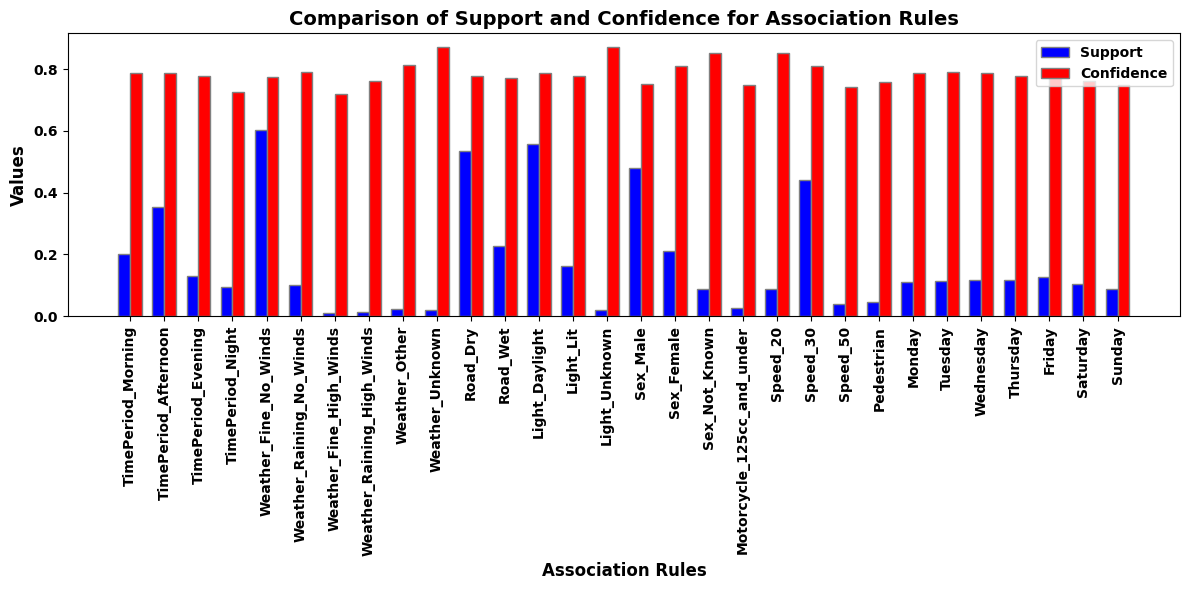

In [33]:
# Prepare data for plotting
support_values = all_severity_rules['support']
confidence_values = all_severity_rules['confidence']

# Generate custom labels for the rules using antecedents and consequents
rule_labels = [' & '.join([str(antecedent) for antecedent in rule]) for rule in all_severity_rules['antecedents']]

# Create a figure for the bar plot
plt.figure(figsize=(12, 6))

# Set the bar width
bar_width = 0.35

# Create the positions for the bars
r1 = np.arange(len(rule_labels))  # Positions for support bars
r2 = [x + bar_width for x in r1]   # Positions for confidence bars

# Plot support and confidence as bars
plt.bar(r1, support_values, color='b', width=bar_width, edgecolor='grey', label='Support')
plt.bar(r2, confidence_values, color='r', width=bar_width, edgecolor='grey', label='Confidence')

# Add labels and title
plt.xlabel('Association Rules', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.title('Comparison of Support and Confidence for Association Rules')

# Set the x-ticks to be the center of the bars
plt.xticks([r + bar_width/2 for r in r1], rule_labels, rotation=90)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('support vs confidence.png', dpi=300, bbox_inches='tight')
plt.show()

# TASK 5: Clustering

In [34]:
#!pip install folium

In [35]:
# Filter for Kingston Upon Hull, Humberside, East Riding of Yorkshire
kingston_kingston_accidents = dfs['accident'][dfs['accident']['local_authority_district'] == 228]
humberside_accidents = dfs['accident'][dfs['accident']['police_force'] == 16]
east_riding_accidents = dfs['accident'][dfs['accident']['local_authority_district'] == 231]

# Preview the filtered data
print("Kingston upon Hull accidents: ", kingston_kingston_accidents.head())
print("Humberside accidents: ", humberside_accidents.head())
print("East Riding accidents: ", east_riding_accidents.head())

Kingston upon Hull accidents:        accident_index  accident_year accident_reference  location_easting_osgr  \
37750  2020160914781           2020          160914781               510156.0   
37751  2020160914930           2020          160914930               506050.0   
37753  2020160915028           2020          160915028               510449.0   
37755  2020160915047           2020          160915047               510322.0   
37757  2020160915332           2020          160915332               511596.0   

       location_northing_osgr  longitude   latitude  police_force  \
37750                429221.0  -0.331047  53.747751            16   
37751                428813.0  -0.393424  53.744936            16   
37753                434112.0  -0.324858  53.791630            16   
37755                431457.0  -0.327733  53.767805            16   
37757                429551.0  -0.309102  53.750410            16   

       accident_severity  number_of_vehicles  ...  light_conditions

In [36]:
# Apply clustering for each location separately

def apply_clustering(location_df):
    # Extract latitude and longitude for clustering
    coordinates = location_df[['latitude', 'longitude']].dropna()

    # Scale the coordinates
    scaler = StandardScaler()
    scaled_coordinates = scaler.fit_transform(coordinates)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.1, min_samples=10)
    
    # Use .loc[] to avoid SettingWithCopyWarning
    location_df.loc[:, 'cluster'] = dbscan.fit_predict(scaled_coordinates)
    
    return location_df

# Filter for Kingston Upon Hull, Humberside, and East Riding of Yorkshire
kingston_kingston_accidents = dfs['accident'][dfs['accident']['local_authority_district'] == 228]
humberside_accidents = dfs['accident'][dfs['accident']['police_force'] == 16]
east_riding_accidents = dfs['accident'][dfs['accident']['local_authority_district'] == 231]

# Preview the filtered data
print("Kingston upon Hull accidents: ", kingston_kingston_accidents.head())
print("Humberside accidents: ", humberside_accidents.head())
print("East Riding accidents: ", east_riding_accidents.head())

# Apply clustering to each region
kingston_kingston_accidents = apply_clustering(kingston_kingston_accidents)
humberside_accidents = apply_clustering(humberside_accidents)
east_riding_accidents = apply_clustering(east_riding_accidents)

# Preview the data with cluster labels for each region
print("Kingston upon Hull accidents with clusters: ", kingston_kingston_accidents[['latitude', 'longitude', 'cluster']].head())
print("Humberside accidents with clusters: ", humberside_accidents[['latitude', 'longitude', 'cluster']].head())
print("East Riding accidents with clusters: ", east_riding_accidents[['latitude', 'longitude', 'cluster']].head())


Kingston upon Hull accidents:        accident_index  accident_year accident_reference  location_easting_osgr  \
37750  2020160914781           2020          160914781               510156.0   
37751  2020160914930           2020          160914930               506050.0   
37753  2020160915028           2020          160915028               510449.0   
37755  2020160915047           2020          160915047               510322.0   
37757  2020160915332           2020          160915332               511596.0   

       location_northing_osgr  longitude   latitude  police_force  \
37750                429221.0  -0.331047  53.747751            16   
37751                428813.0  -0.393424  53.744936            16   
37753                434112.0  -0.324858  53.791630            16   
37755                431457.0  -0.327733  53.767805            16   
37757                429551.0  -0.309102  53.750410            16   

       accident_severity  number_of_vehicles  ...  light_conditions

C:\Users\HP\AppData\Local\Temp\ipykernel_6788\164419418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df.loc[:, 'cluster'] = dbscan.fit_predict(scaled_coordinates)
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\164419418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df.loc[:, 'cluster'] = dbscan.fit_predict(scaled_coordinates)
C:\Users\HP\AppData\Local\Temp\ipykernel_6788\164419418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

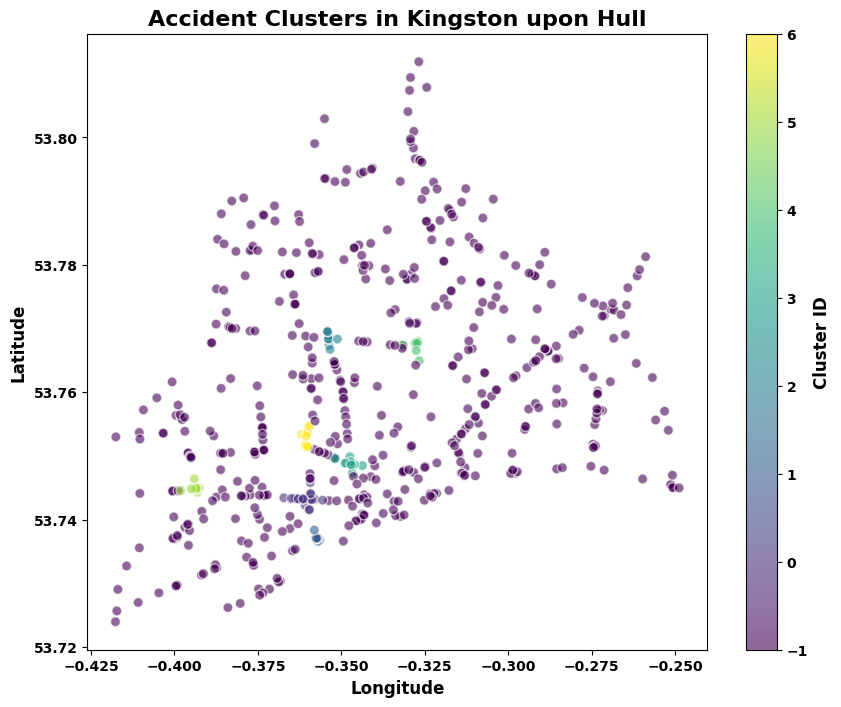

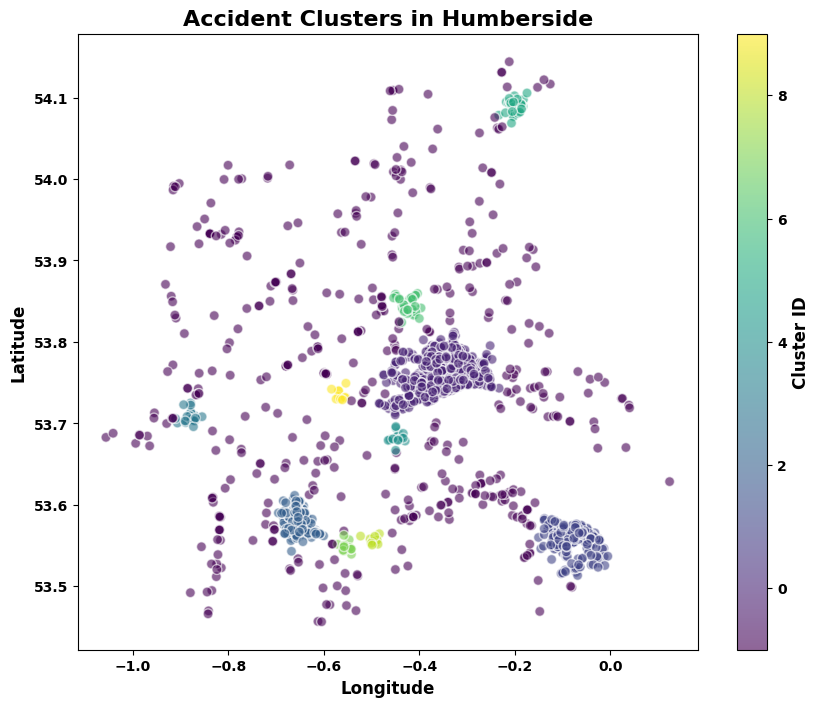

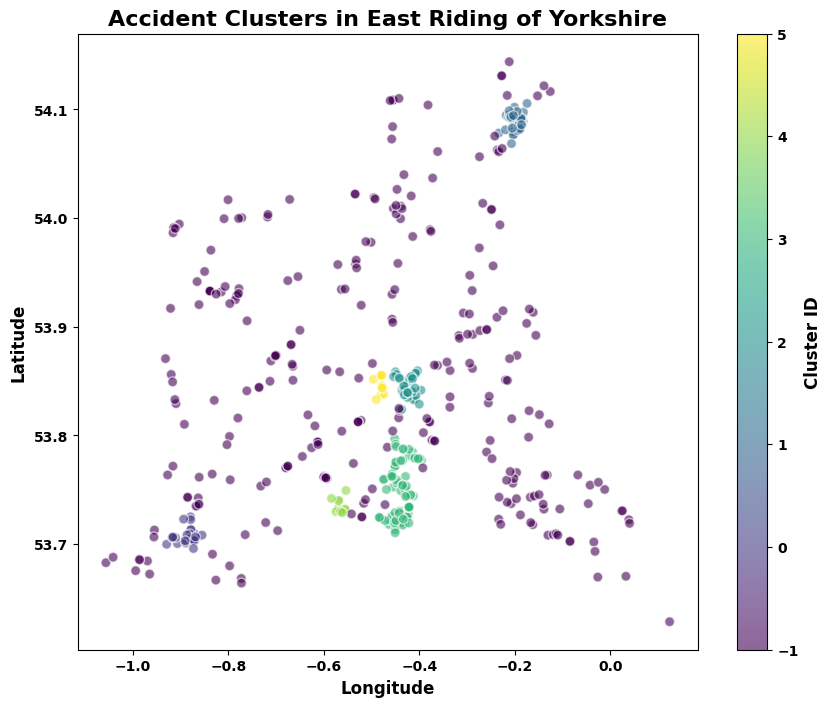

In [37]:
def plot_clusters(location_df, location_name, save_path):
    # Drop any rows with NaN values in 'cluster' column 
    location_df = location_df.dropna(subset=['cluster'])
    
    # Create a scatter plot for the clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(location_df['longitude'], location_df['latitude'], c=location_df['cluster'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)
    
    # Add titles and labels
    plt.title(f'Accident Clusters in {location_name}', fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Add color bar to indicate cluster ids
    plt.colorbar(label='Cluster ID')
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot the clusters for each location and save as separate figures
plot_clusters(kingston_kingston_accidents, "Kingston upon Hull", "kingston_clusters.png")
plot_clusters(humberside_accidents, "Humberside", "humberside_clusters.png")
plot_clusters(east_riding_accidents, "East Riding of Yorkshire", "east_riding_clusters.png")

# Clustering of a Combination of Kingston Upon Hull, Humberside, East Riding of Yorkshire

In [38]:
# Filter for Kingston Upon Hull, Humberside, East Riding of Yorkshire
# Kingston upon Hull: local_authority_district = 228
# Humberside: police_force = 16
# East Riding of Yorkshire: local_authority_district = 231

selected_regions = [228, 231]  # Local authorities
humberside_police_force = 16  # Police force for Humberside

# Filter the accident data for these regions
accidents_in_region = dfs['accident'][
    dfs['accident']['local_authority_district'].isin(selected_regions) |
    (dfs['accident']['police_force'] == humberside_police_force)
]

# Extract latitude and longitude for clustering
accidents_in_region_locations = accidents_in_region[['latitude', 'longitude']].dropna()

# Preview the data before clustering
print(accidents_in_region_locations.head())

        latitude  longitude
37750  53.747751  -0.331047
37751  53.744936  -0.393424
37752  53.512895  -0.528743
37753  53.791630  -0.324858
37754  53.574501  -0.095008


In [39]:
# Standardize the latitude and longitude for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(accidents_in_region_locations)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=10)  # Adjust parameters if necessary
accidents_in_region['cluster'] = dbscan.fit_predict(scaled_features)

# Check the first few rows with cluster information
print(accidents_in_region[['latitude', 'longitude', 'cluster']].head())

        latitude  longitude  cluster
37750  53.747751  -0.331047        0
37751  53.744936  -0.393424        0
37752  53.512895  -0.528743       -1
37753  53.791630  -0.324858        0
37754  53.574501  -0.095008        1


C:\Users\HP\AppData\Local\Temp\ipykernel_6788\1621327061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_in_region['cluster'] = dbscan.fit_predict(scaled_features)


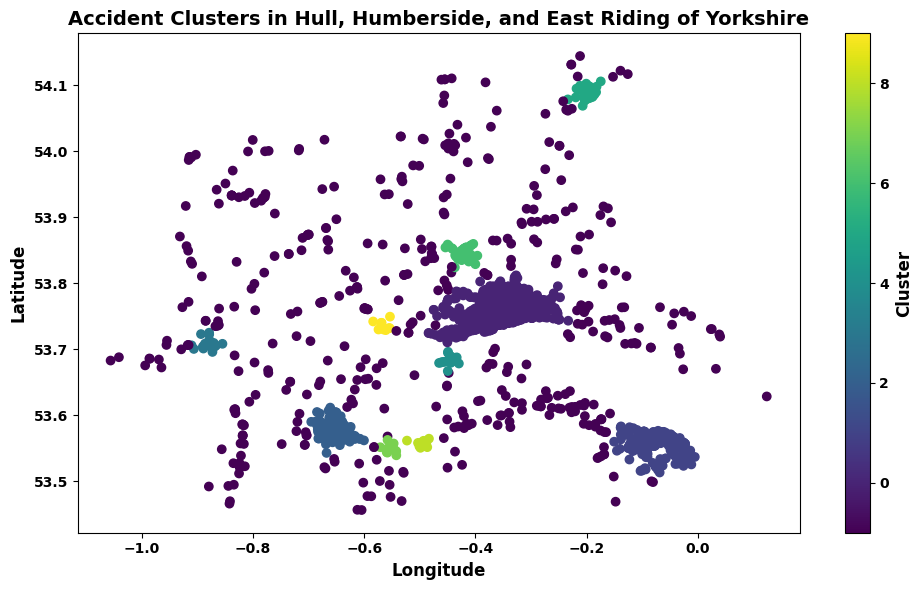

In [40]:
# Plot the clusters on a map
plt.figure(figsize=(10, 6))
plt.scatter(accidents_in_region['longitude'], accidents_in_region['latitude'], c=accidents_in_region['cluster'], cmap='viridis', marker='o')
plt.title("Accident Clusters in Hull, Humberside, and East Riding of Yorkshire")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig('accident_clusters_3_locations.png')  # Save as a PNG file
plt.show()

# Time Series Models for Three Policing Areas

# DATA PREPROCESSING

In [41]:
# SQL query to check raw accident data
query_raw = """
    SELECT
        police_force,
        date,
        time,
        COUNT(*) AS accident_count
    FROM
        accident
    WHERE
        police_force IN (1, 20, 46)
        AND accident_year BETWEEN 2017 AND 2019
    GROUP BY
        police_force, date, time
    ORDER BY
        police_force, date;
"""

# Load raw data into a DataFrame
raw_data = pd.read_sql_query(query_raw, conn)

print(raw_data)

       police_force        date   time  accident_count
0                 1  01/01/2017  00:30               1
1                 1  01/01/2017  01:00               1
2                 1  01/01/2017  01:11               1
3                 1  01/01/2017  01:15               1
4                 1  01/01/2017  01:23               1
...             ...         ...    ...             ...
99528            46  31/12/2019  17:30               1
99529            46  31/12/2019  19:00               1
99530            46  31/12/2019  19:35               1
99531            46  31/12/2019  20:30               1
99532            46  31/12/2019  22:17               1

[99533 rows x 4 columns]


In [42]:
# Convert the 'date' column to datetime, handling potential format issues
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%d/%m/%Y', errors='coerce')

# Drop rows with invalid dates
raw_data.dropna(subset=['date'], inplace=True)

# Group the raw data by 'police_force' and 'date', and count accidents
grouped_data = raw_data.groupby(['police_force', 'date']).size().reset_index(name='accident_count')
import pandas as pd

# Set 'date' as the index for proper time series operations
grouped_data.set_index('date', inplace=True)

# Perform resampling by week (W-SUN) for each police force and sum up accident counts
resampled_data = (
    grouped_data
    .groupby('police_force')
    .resample('W-SUN')['accident_count']
    .sum()
    .reset_index()
)

# Generate the full weekly date range for each police force
date_ranges = {}
for police_force in resampled_data['police_force'].unique():
    full_date_range = pd.date_range(
        start=resampled_data.loc[resampled_data['police_force'] == police_force, 'date'].min(),
        end=resampled_data.loc[resampled_data['police_force'] == police_force, 'date'].max(),
        freq='W-SUN'
    )
    date_ranges[police_force] = full_date_range

# Reindex each police force's data to ensure continuous weekly frequency
final_data = pd.DataFrame()
for police_force, date_range in date_ranges.items():
    force_data = resampled_data[resampled_data['police_force'] == police_force].set_index('date')
    # Reindex with the specified weekly frequency
    force_data = force_data.reindex(date_range, fill_value=0)
    force_data['police_force'] = police_force
    force_data.index.name = 'date'  # Set index name 
    force_data = force_data.asfreq('W-SUN')  # set frequency
    final_data = pd.concat([final_data, force_data])

# Reset index for the final output
final_data.reset_index(inplace=True)

# Rename columns 
final_data.rename(columns={'index': 'date'}, inplace=True)

force_mapping = {
    1: 'Metropolitan Police',
    20: 'West Midlands Police',
    46: 'Kent Police'
}
final_data['police_force'] = final_data['police_force'].map(force_mapping)

# Display the final dataset
print(final_data)

          date         police_force  accident_count
0   2017-01-01  Metropolitan Police              52
1   2017-01-08  Metropolitan Police             419
2   2017-01-15  Metropolitan Police             488
3   2017-01-22  Metropolitan Police             500
4   2017-01-29  Metropolitan Police             469
..         ...                  ...             ...
469 2019-12-08          Kent Police              94
470 2019-12-15          Kent Police              95
471 2019-12-22          Kent Police             120
472 2019-12-29          Kent Police              54
473 2020-01-05          Kent Police              23

[474 rows x 3 columns]


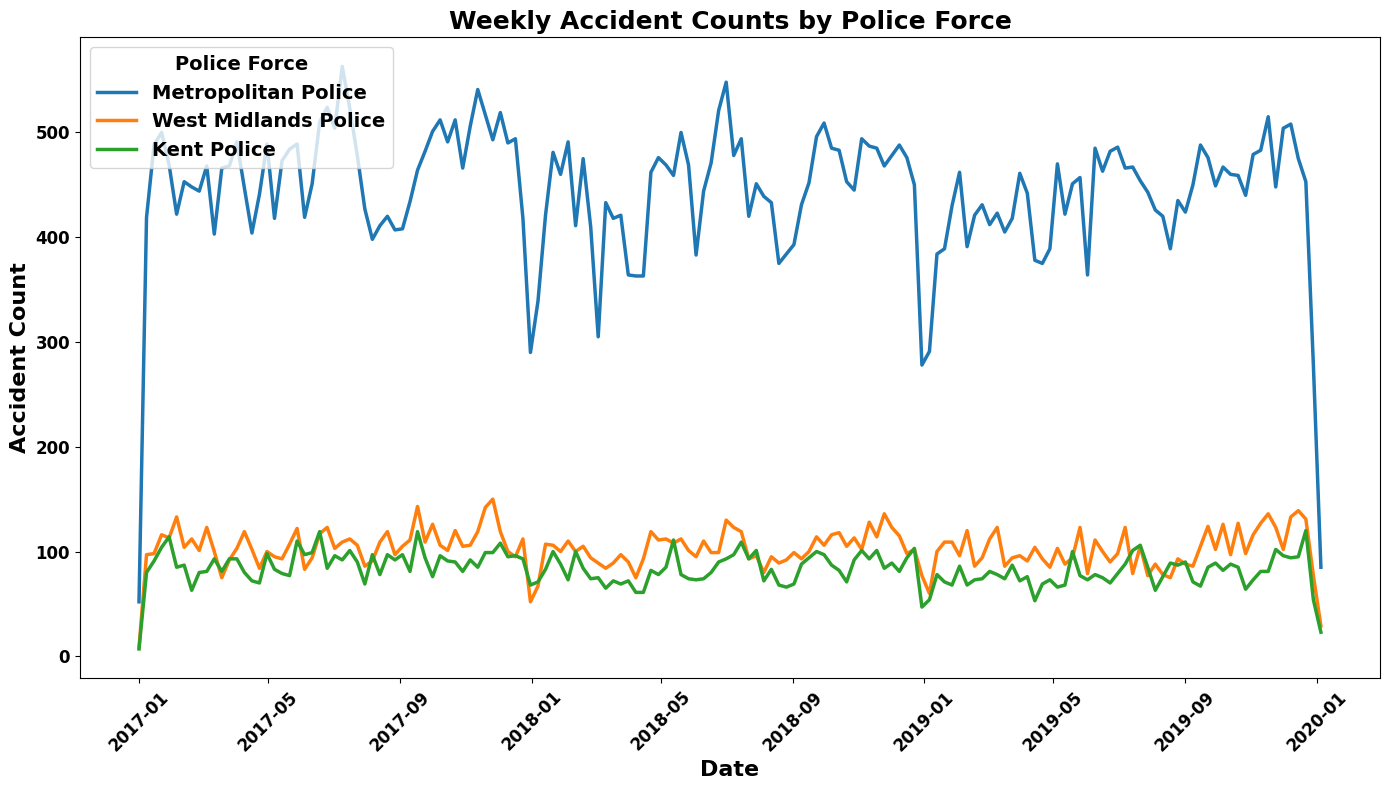

In [43]:
# Create a plot for each police force
plt.figure(figsize=(14, 8))

# Plot data for each police force
for police_force in final_data['police_force'].unique():
    force_data = final_data[final_data['police_force'] == police_force]
    plt.plot(
        force_data['date'],
        force_data['accident_count'],
        label=police_force,
        linewidth=2.5
    )

# Add titles and labels
plt.title('Weekly Accident Counts by Police Force', fontsize=18, weight='bold')
plt.xlabel('Date', fontsize=16, weight='bold')
plt.ylabel('Accident Count', fontsize=16, weight='bold')

# Adjust ticks and legend
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title='Police Force', fontsize=14, title_fontsize=14, loc='upper left')

# Remove grid lines
plt.grid(False)

# Tighten layout and save the plot
plt.tight_layout()
plt.savefig('weekly_accident_counts.png', dpi=300)

# Display the plot
plt.show()

# Handle Missing Values

In [44]:
# Check for missing values
print(final_data.isnull().sum())

date              0
police_force      0
accident_count    0
dtype: int64


# Stationarity Check

In [45]:
# Function to perform ADF test
def check_stationarity(data, label):
    print(f"\nStationarity Test for {label}:")
    adf_result = adfuller(data['accident_count'].dropna())  # Drop NaN values
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])

    if adf_result[1] <= 0.05:
        print(f"The time series for {label} is stationary (reject H₀).")
    else:
        print(f"The time series for {label} is non-stationary (fail to reject H₀).")

# Loop through each unique police force in the data
for police_force in final_data['police_force'].unique():
    # Filter the data for the current police force
    force_data = final_data[final_data['police_force'] == police_force].copy()
    
    # Run the stationarity test
    check_stationarity(force_data, police_force)


Stationarity Test for Metropolitan Police:
ADF Statistic: -4.75633585721549
p-value: 6.587024461611936e-05
Critical Values: {'1%': -3.4729792729247793, '5%': -2.8802520918255534, '10%': -2.5767469641683105}
The time series for Metropolitan Police is stationary (reject H₀).

Stationarity Test for West Midlands Police:
ADF Statistic: -9.040724463732795
p-value: 5.142314082781231e-15
Critical Values: {'1%': -3.472703119504854, '5%': -2.880131672353732, '10%': -2.5766826861130268}
The time series for West Midlands Police is stationary (reject H₀).

Stationarity Test for Kent Police:
ADF Statistic: -8.982848729687154
p-value: 7.231549925356799e-15
Critical Values: {'1%': -3.472703119504854, '5%': -2.880131672353732, '10%': -2.5766826861130268}
The time series for Kent Police is stationary (reject H₀).


# Seasonal Decomposition of Time Series (STL)

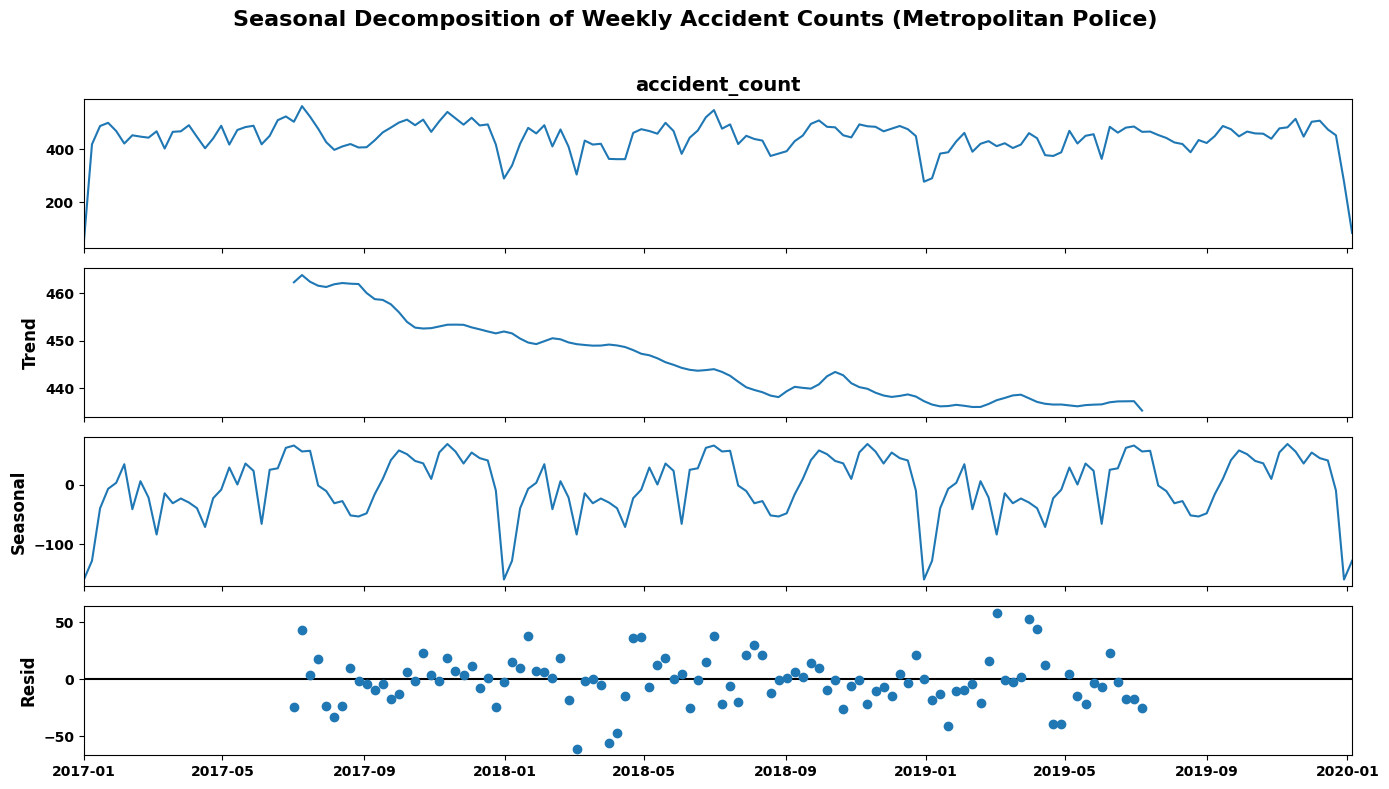

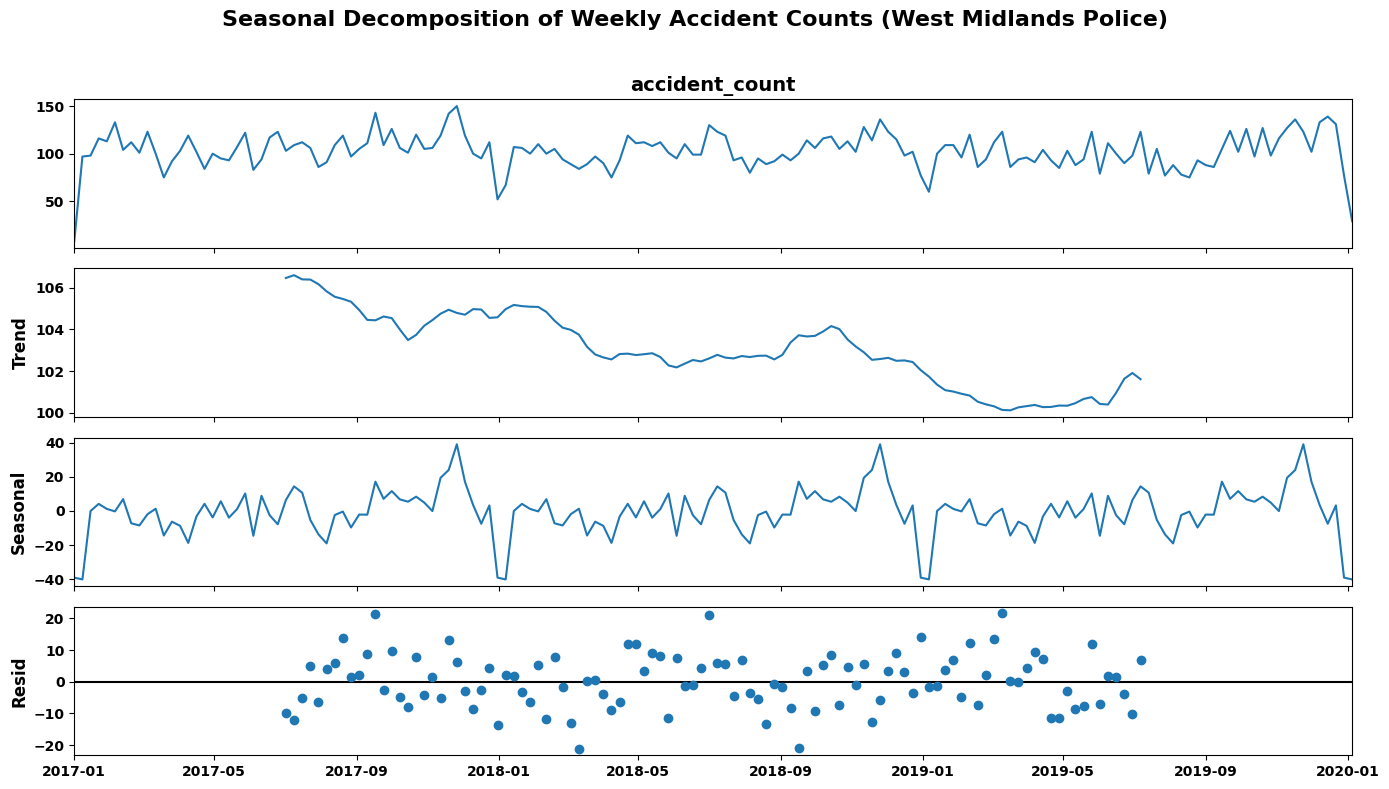

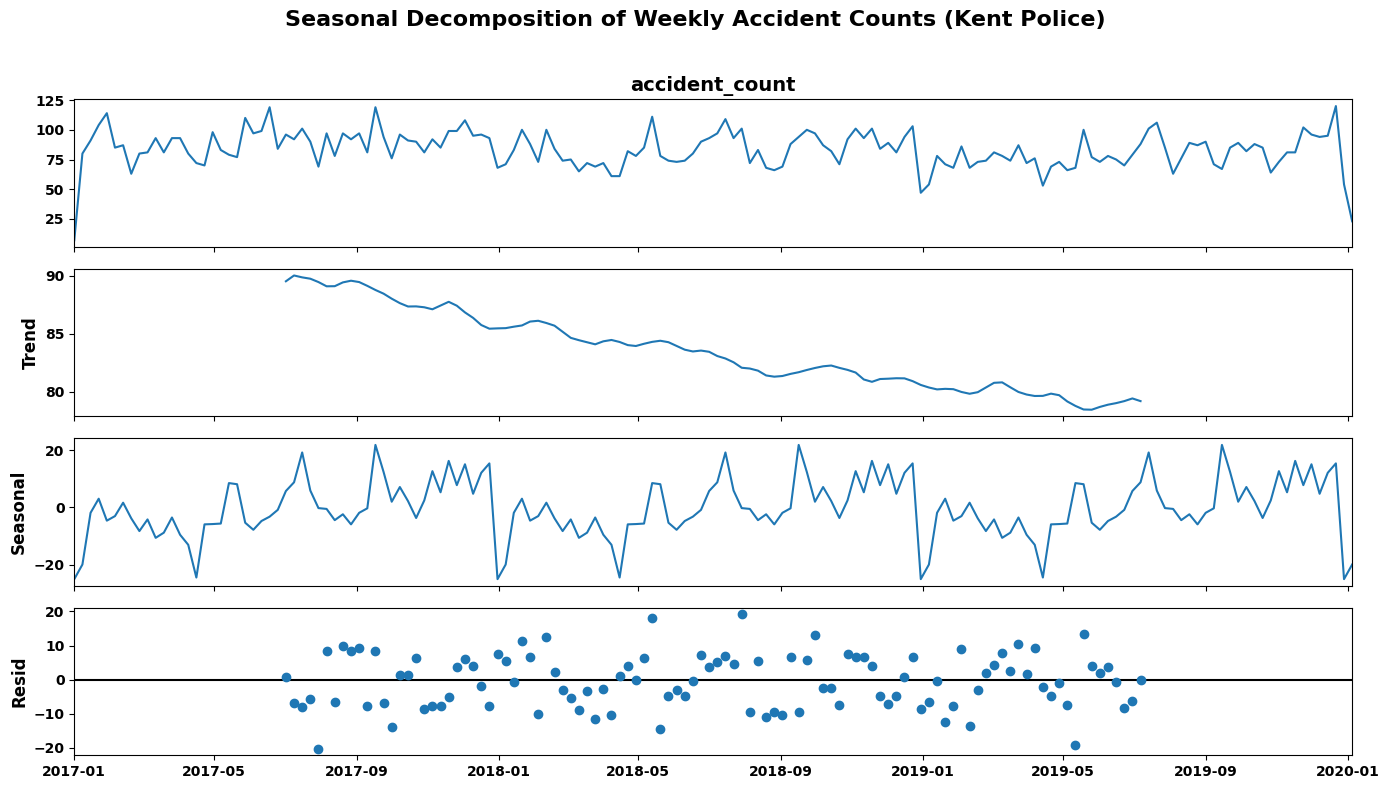

In [46]:
# Loop through each unique police force in the data
for police_force in final_data['police_force'].unique():
    # Filter the data for the current police force
    force_data = final_data[final_data['police_force'] == police_force].copy()
    
    # Ensure the data is sorted by date and indexed correctly
    force_data.set_index('date', inplace=True)
    force_data.sort_index(inplace=True)
    
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(
        force_data['accident_count'], 
        model='additive', 
        period=52  # Weekly data (52 weeks in a year)
    )
    
    # Plot the decomposition
    fig = decomposition.plot()
    fig.set_size_inches(14, 8)
    plt.suptitle(f'Seasonal Decomposition of Weekly Accident Counts ({police_force})', 
                 fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
    plt.show()

# Split the Data: Train/Test Split Using Chronological Order

In [47]:
# Ensure the data is sorted by date
final_data.sort_index(inplace=True)

# Split the data into training and test sets
train_size = int(len(final_data) * 0.8)  # 80% for training
train_data, test_data = final_data[:train_size], final_data[train_size:]

print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Train Data Shape: (379, 3)
Test Data Shape: (95, 3)


# ARIMA TIME SERIES MODEL with and without Grid Search with AIC (Akaike Information Criterion)


ARIMA Model Summary (No Grid Search) for Metropolitan Police:
                               SARIMAX Results                                
Dep. Variable:         accident_count   No. Observations:                  158
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -857.396
Date:                Sat, 21 Dec 2024   AIC                           1720.793
Time:                        22:08:10   BIC                           1729.961
Sample:                    01-01-2017   HQIC                          1724.516
                         - 01-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6538      0.572     -1.144      0.253      -1.774       0.467
ma.L1          0.7058      0.551      1.280      0.201      -0.375  

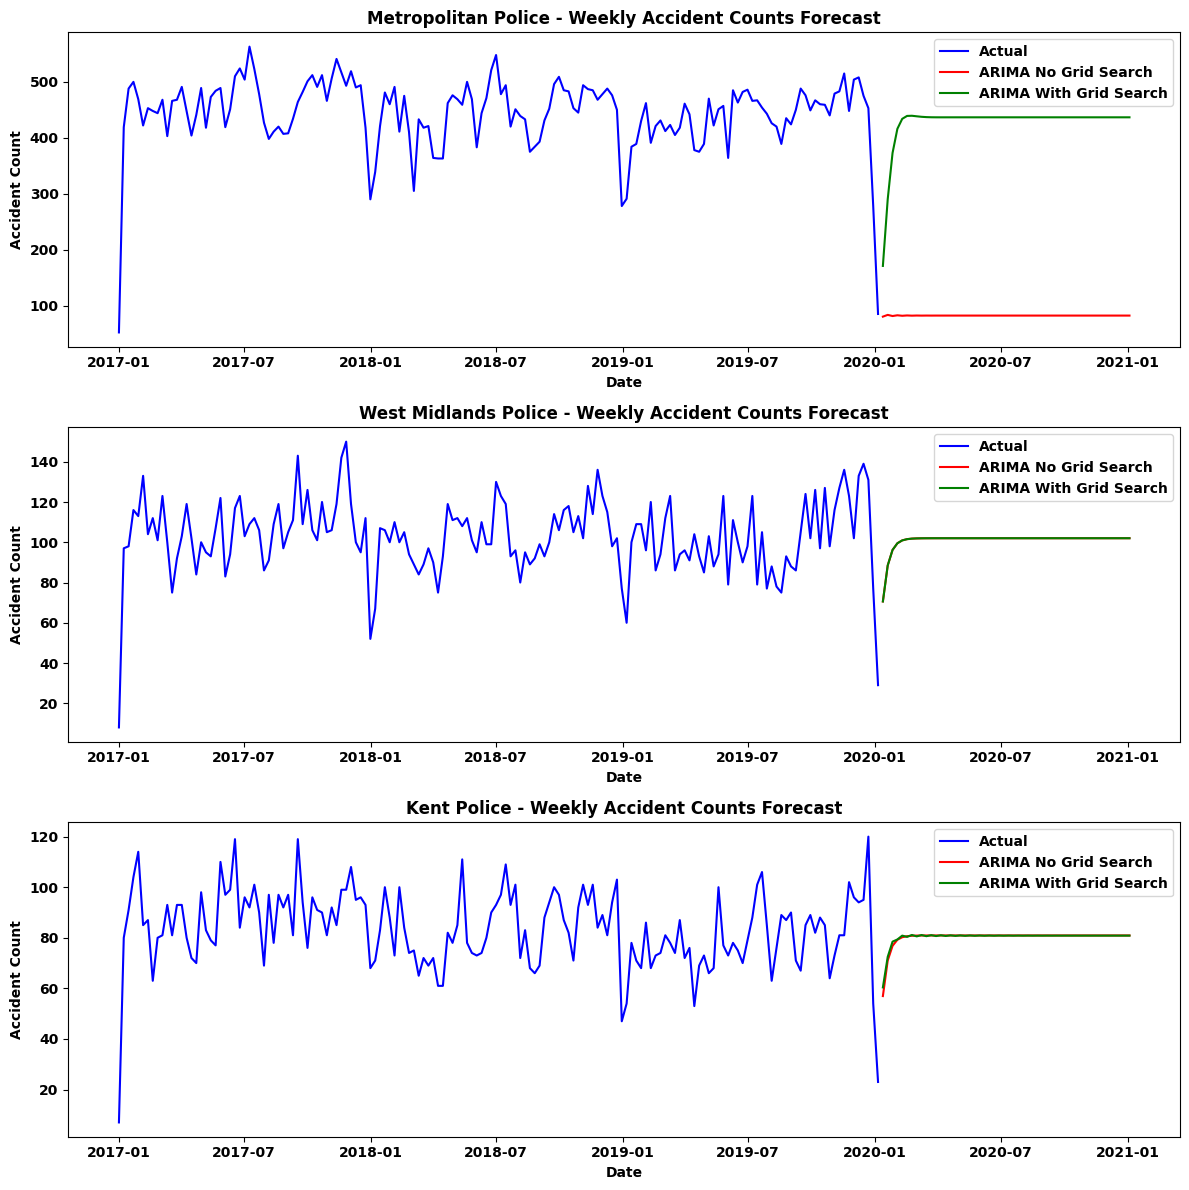


Evaluation Metrics - ARIMA (No Grid Search):
Metropolitan Police:
  RMSE: 56.95452799608665
  MAE: 38.09893063657108
  SMAPE: 10.860242088859687%
West Midlands Police:
  RMSE: 18.364654864897155
  MAE: 13.682769017261336
  SMAPE: 15.407895304702853%
Kent Police:
  RMSE: 15.210970731421732
  MAE: 11.23526351282456
  SMAPE: 15.477638013780446%

Evaluation Metrics - ARIMA (With Grid Search):
Metropolitan Police:
  RMSE: 56.18763564507914
  MAE: 37.06332541464856
  SMAPE: 10.604819920917304%
West Midlands Police:
  RMSE: 18.364654864897155
  MAE: 13.682769017261336
  SMAPE: 15.407895304702853%
Kent Police:
  RMSE: 15.051688311359126
  MAE: 11.015716236591405
  SMAPE: 15.230584726251074%


In [48]:
# Function to calculate SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Function to automatically select the best ARIMA model based on AIC
def auto_arima_order(data):
    """
    Automatically selects the best ARIMA model based on AIC using grid search for p, d, q values.
    """
    best_aic = np.inf
    best_order = (1, 1, 1)  # Default to (1, 1, 1)
    best_model = None
    
    # Grid search over possible values of p, d, q
    p = d = q = range(0, 3)  # Range of values for p, d, q (you can adjust this)
    best_params = list(itertools.product(p, d, q))
    
    for param in best_params:
        try:
            model = ARIMA(data, order=param)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = param
                best_model = model_fit
        except:
            continue  # Skip if model fitting fails
    return best_order, best_model

# Function to train and evaluate ARIMA model without Grid Search
def train_arima_no_gridsearch(data, label, order=(1, 1, 1), steps=52):
    """
    Trains an ARIMA model with a fixed order (no grid search) and forecasts for the next 'steps' weeks.
    """
    # Train the ARIMA model with a fixed order
    model = ARIMA(data['accident_count'], order=order)
    model_fit = model.fit()

    # Print the model summary
    print(f"\nARIMA Model Summary (No Grid Search) for {label}:")
    print(model_fit.summary())

    # Forecast for the given number of steps
    forecast = model_fit.forecast(steps=steps)

    # Calculate evaluation metrics
    y_true = data['accident_count']
    y_pred = model_fit.fittedvalues
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)

    return model_fit, forecast, rmse, mae, smape_val

# Function to train and evaluate ARIMA model with Grid Search for optimal order
def train_arima_with_gridsearch(data, label, steps=52):
    """
    Trains an ARIMA model and evaluates using grid search to find the best order based on AIC.
    """
    # Automatically select the best ARIMA model using grid search
    best_order, best_model_fit = auto_arima_order(data['accident_count'])
    
    print(f"\nBest ARIMA Order (Grid Search) for {label}: {best_order}")
    print(f"Model Summary for {label}:")
    print(best_model_fit.summary())
    
    # Forecast for the given number of steps
    forecast = best_model_fit.forecast(steps=steps)

    # Calculate evaluation metrics
    y_true = data['accident_count']
    y_pred = best_model_fit.fittedvalues
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)

    return best_model_fit, forecast, rmse, mae, smape_val

# Filter data for specific police forces
unique_police_forces = final_data['police_force'].unique()

# Dictionaries to store results
results_arima_no_gridsearch = {}
results_arima_with_gridsearch = {}

# Loop through each police force
for police_force in unique_police_forces:
    police_data = final_data[final_data['police_force'] == police_force].copy()
    police_data.set_index('date', inplace=True)
    police_data.sort_index(inplace=True)
    
    # ARIMA without grid search
    model_arima_no_grid, forecast_arima_no_grid, rmse_arima_no_grid, mae_arima_no_grid, smape_arima_no_grid = train_arima_no_gridsearch(
        police_data, police_force
    )
    
    # ARIMA with grid search
    model_arima_with_grid, forecast_arima_with_grid, rmse_arima_with_grid, mae_arima_with_grid, smape_arima_with_grid = train_arima_with_gridsearch(
        police_data, police_force
    )
    
    # Storing results for ARIMA models
    results_arima_no_gridsearch[police_force] = {
        'model': model_arima_no_grid,
        'forecast': forecast_arima_no_grid,
        'rmse': rmse_arima_no_grid,
        'mae': mae_arima_no_grid,
        'smape': smape_arima_no_grid,
        'actual_data': police_data
    }
    
    results_arima_with_gridsearch[police_force] = {
        'model': model_arima_with_grid,
        'forecast': forecast_arima_with_grid,
        'rmse': rmse_arima_with_grid,
        'mae': mae_arima_with_grid,
        'smape': smape_arima_with_grid,
        'actual_data': police_data
    }

# Plotting the results
plt.figure(figsize=(12, 12))

for idx, police_force in enumerate(unique_police_forces, 1):
    # ARIMA results without grid search
    police_results_arima_no_grid = results_arima_no_gridsearch[police_force]
    forecast_arima_no_grid = police_results_arima_no_grid['forecast']
    
    # ARIMA results with grid search
    police_results_arima_with_grid = results_arima_with_gridsearch[police_force]
    forecast_arima_with_grid = police_results_arima_with_grid['forecast']
    
    # Plot actual data and predictions
    plt.subplot(len(unique_police_forces), 1, idx)
    plt.plot(police_results_arima_no_grid['actual_data'].index, police_results_arima_no_grid['actual_data']['accident_count'], label='Actual', color='blue')
    plt.plot(pd.date_range(start=police_results_arima_no_grid['actual_data'].index[-1], periods=len(forecast_arima_no_grid) + 1, freq='W')[1:], forecast_arima_no_grid, label='ARIMA No Grid Search', color='red')
    plt.plot(pd.date_range(start=police_results_arima_no_grid['actual_data'].index[-1], periods=len(forecast_arima_with_grid) + 1, freq='W')[1:], forecast_arima_with_grid, label='ARIMA With Grid Search', color='green')
    
    plt.title(f"{police_force} - Weekly Accident Counts Forecast", fontsize=12, weight='bold')
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Accident Count", fontsize=10)
    plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.savefig('Weekly Accident Counts Forecast - ARIMA Comparison.png')
plt.show()

# Display evaluation metrics for each ARIMA model
print("\nEvaluation Metrics - ARIMA (No Grid Search):")
for police_force, metrics in results_arima_no_gridsearch.items():
    print(f"{police_force}:")
    print(f"  RMSE: {metrics['rmse']}")
    print(f"  MAE: {metrics['mae']}")
    print(f"  SMAPE: {metrics['smape']}%")

print("\nEvaluation Metrics - ARIMA (With Grid Search):")
for police_force, metrics in results_arima_with_gridsearch.items():
    print(f"{police_force}:")
    print(f"  RMSE: {metrics['rmse']}")
    print(f"  MAE: {metrics['mae']}")
    print(f"  SMAPE: {metrics['smape']}%")

# Holt-Winters Models : With and Without Grid Search


Holt-Winters Model Summary (No Grid Search) for Metropolitan Police:
                       ExponentialSmoothing Model Results                       
Dep. Variable:           accident_count   No. Observations:                  158
Model:             ExponentialSmoothing   SSE                         210507.804
Optimized:                         True   AIC                           1248.760
Trend:                         Additive   BIC                           1420.265
Seasonal:                      Additive   AICC                          1317.891
Seasonal Periods:                    52   Date:                 Sat, 21 Dec 2024
Box-Cox:                          False   Time:                         22:08:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.10180

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err



Best Holt-Winters Order (Grid Search) for West Midlands Police: ('mul', 'mul')
Model Summary for West Midlands Police:
                       ExponentialSmoothing Model Results                       
Dep. Variable:           accident_count   No. Observations:                  158
Model:             ExponentialSmoothing   SSE                          21780.433
Optimized:                         True   AIC                            890.335
Trend:                   Multiplicative   BIC                           1061.841
Seasonal:                Multiplicative   AICC                           959.467
Seasonal Periods:                    52   Date:                 Sat, 21 Dec 2024
Box-Cox:                          False   Time:                         22:08:19
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------

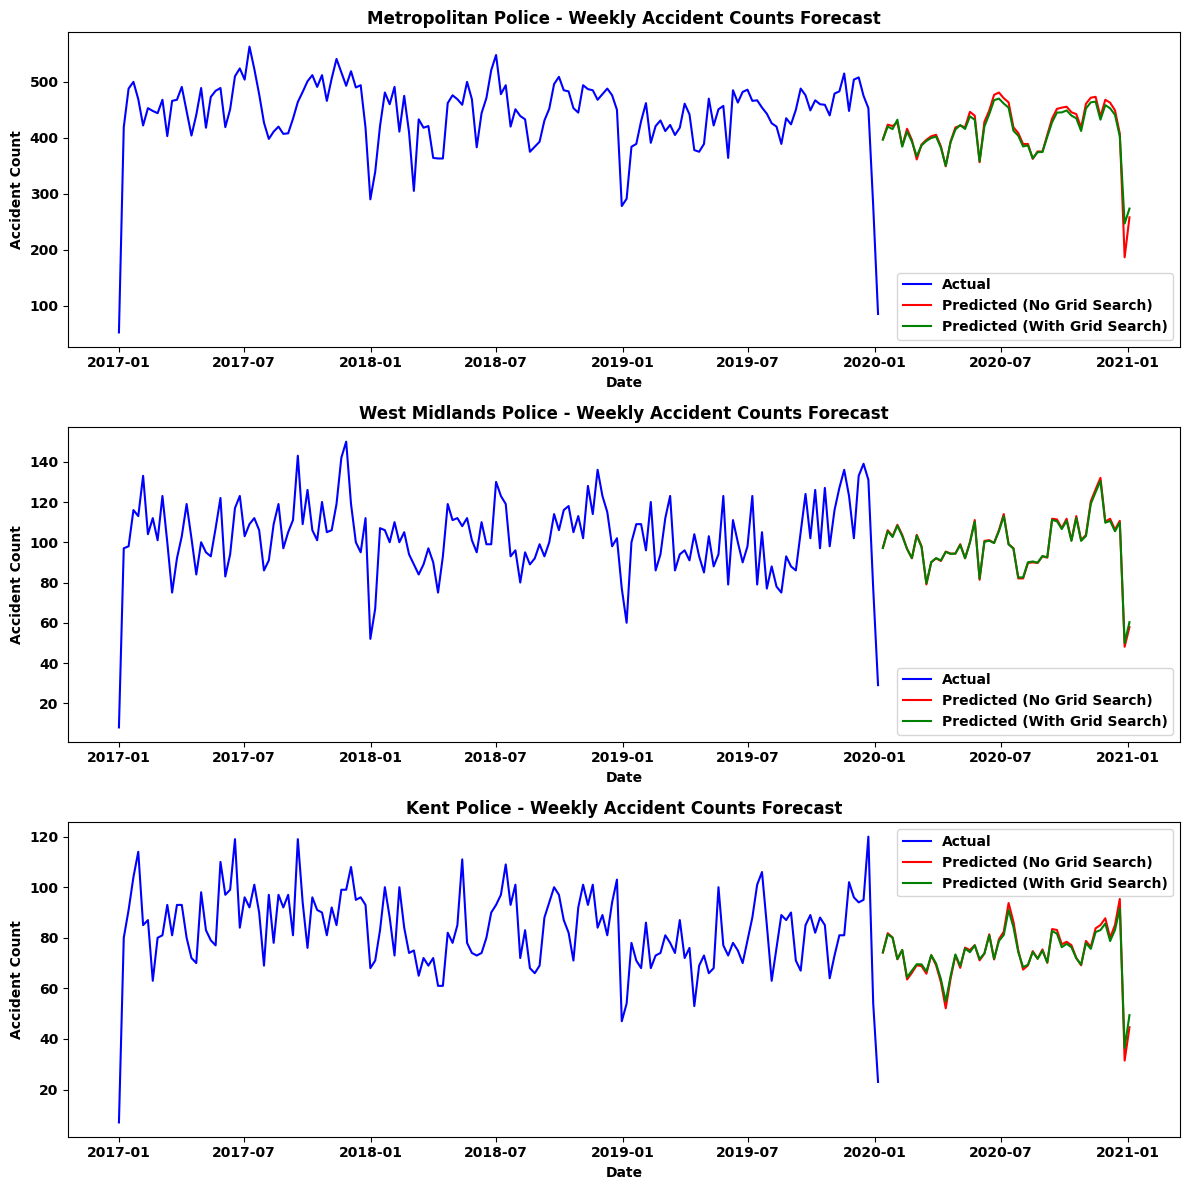


Evaluation Metrics - No Grid Search:
Metropolitan Police:
  RMSE: 36.50106670073359
  MAE: 23.394745025448984
  SMAPE: 6.553759707775423%
West Midlands Police:
  RMSE: 11.752867513890775
  MAE: 9.110200913350656
  SMAPE: 9.847520685856658%
Kent Police:
  RMSE: 10.447980151127892
  MAE: 8.178815513207953
  SMAPE: 10.822599284769916%

Evaluation Metrics - With Grid Search:
Metropolitan Police:
  RMSE: 35.52145456283997
  MAE: 21.524622448702388
  SMAPE: 5.8845179282441356%
West Midlands Police:
  RMSE: 11.740989880606307
  MAE: 9.114344461862242
  SMAPE: 9.8540191330862%
Kent Police:
  RMSE: 10.433955134175847
  MAE: 8.242139024949367
  SMAPE: 10.916728825389525%


In [49]:
# Function to calculate SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Function to automatically select the best Holt-Winters model based on AIC
def auto_hw_order(data, seasonal_periods=52):
    """
    Automatically selects the best Holt-Winters model based on AIC.
    """
    best_aic = np.inf
    best_order = ('add', 'add')  # Default to additive trend and seasonality
    best_model = None
    
    # Grid search over possible values of trend and seasonal
    for trend in ['add', 'mul']:
        for seasonal in ['add', 'mul']:
            try:
                model = ExponentialSmoothing(
                    data, 
                    trend=trend, 
                    seasonal=seasonal, 
                    seasonal_periods=seasonal_periods
                )
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (trend, seasonal)
                    best_model = model_fit
            except:
                continue  # Skip if model fitting fails
    return best_order, best_model

# Function to train and evaluate Holt-Winters model without Grid Search
def train_hw_no_gridsearch(data, label, seasonal_periods=52, steps=52):
    """
    Trains a Holt-Winters model with a fixed trend and seasonal parameters (without grid search).
    """
    # Use fixed parameters (Additive trend and seasonality)
    model = ExponentialSmoothing(
        data['accident_count'], 
        trend='add',  # Additive trend
        seasonal='add',  # Additive seasonality
        seasonal_periods=seasonal_periods  # Weekly data with yearly seasonality (52 weeks)
    )
    model_fit = model.fit()
    
    # Print the model summary
    print(f"\nHolt-Winters Model Summary (No Grid Search) for {label}:")
    print(model_fit.summary())
    
    # Forecast for the given number of steps
    forecast = model_fit.forecast(steps=steps)
    
    # Calculate evaluation metrics
    y_true = data['accident_count']
    y_pred = model_fit.fittedvalues
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    
    return model_fit, forecast, rmse, mae, smape_val

# Function to train and evaluate Holt-Winters model with Grid Search and AIC
def train_hw_with_gridsearch(data, label, seasonal_periods=52, steps=52):
    """
    Trains a Holt-Winters model and evaluates using grid search with AIC.
    """
    # Automatically select the best model using grid search
    best_order, best_model_fit = auto_hw_order(data['accident_count'], seasonal_periods=seasonal_periods)
    
    print(f"\nBest Holt-Winters Order (Grid Search) for {label}: {best_order}")
    print(f"Model Summary for {label}:")
    print(best_model_fit.summary())
    
    # Forecast for the given number of steps
    forecast = best_model_fit.forecast(steps=steps)
    
    # Calculate evaluation metrics
    y_true = data['accident_count']
    y_pred = best_model_fit.fittedvalues
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    
    return best_model_fit, forecast, rmse, mae, smape_val

# Filter data for specific police forces
unique_police_forces = final_data['police_force'].unique()

results_no_gridsearch = {}
results_with_gridsearch = {}

for police_force in unique_police_forces:
    police_data = final_data[final_data['police_force'] == police_force].copy()
    police_data.set_index('date', inplace=True)
    police_data.sort_index(inplace=True)
    
    # Train and evaluate without grid search (fixed trend and seasonal)
    model_no_grid, forecast_no_grid, rmse_no_grid, mae_no_grid, smape_no_grid = train_hw_no_gridsearch(
        police_data, police_force
    )
    
    # Train and evaluate with grid search (dynamic trend and seasonal selection)
    model_with_grid, forecast_with_grid, rmse_with_grid, mae_with_grid, smape_with_grid = train_hw_with_gridsearch(
        police_data, police_force
    )
    
    results_no_gridsearch[police_force] = {
        'model': model_no_grid,
        'forecast': forecast_no_grid,
        'rmse': rmse_no_grid,
        'mae': mae_no_grid,
        'smape': smape_no_grid,
        'actual_data': police_data
    }
    
    results_with_gridsearch[police_force] = {
        'model': model_with_grid,
        'forecast': forecast_with_grid,
        'rmse': rmse_with_grid,
        'mae': mae_with_grid,
        'smape': smape_with_grid,
        'actual_data': police_data
    }

# Plotting the results
plt.figure(figsize=(12, 12))

for idx, police_force in enumerate(unique_police_forces, 1):
    police_results_no_grid = results_no_gridsearch[police_force]
    actual_data_no_grid = police_results_no_grid['actual_data']
    forecast_no_grid = police_results_no_grid['forecast']
    
    police_results_with_grid = results_with_gridsearch[police_force]
    forecast_with_grid = police_results_with_grid['forecast']
    
    plt.subplot(len(unique_police_forces), 1, idx)
    plt.plot(actual_data_no_grid.index, actual_data_no_grid['accident_count'], label='Actual', color='blue')
    plt.plot(pd.date_range(start=actual_data_no_grid.index[-1], periods=len(forecast_no_grid) + 1, freq='W')[1:], forecast_no_grid, label='Predicted (No Grid Search)', color='red')
    plt.plot(pd.date_range(start=actual_data_no_grid.index[-1], periods=len(forecast_with_grid) + 1, freq='W')[1:], forecast_with_grid, label='Predicted (With Grid Search)', color='green')
    
    plt.title(f"{police_force} - Weekly Accident Counts Forecast", fontsize=12, weight='bold')
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Accident Count", fontsize=10)
    plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.savefig('Weekly Accident Counts Forecast Comparison.png')
plt.show()

# Display evaluation metrics for each police force (No Grid Search)
print("\nEvaluation Metrics - No Grid Search:")
for police_force, metrics in results_no_gridsearch.items():
    print(f"{police_force}:")
    print(f"  RMSE: {metrics['rmse']}")
    print(f"  MAE: {metrics['mae']}")
    print(f"  SMAPE: {metrics['smape']}%")

# Display evaluation metrics for each police force (With Grid Search)
print("\nEvaluation Metrics - With Grid Search:")
for police_force, metrics in results_with_gridsearch.items():
    print(f"{police_force}:")
    print(f"  RMSE: {metrics['rmse']}")
    print(f"  MAE: {metrics['mae']}")
    print(f"  SMAPE: {metrics['smape']}%")

# ETS (Exponential Smoothing State Space Model)

In [50]:
#!pip install prophet

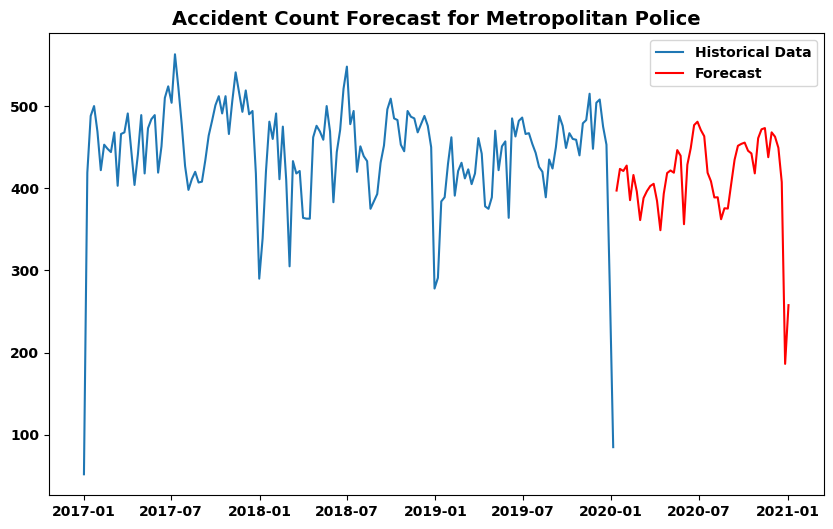

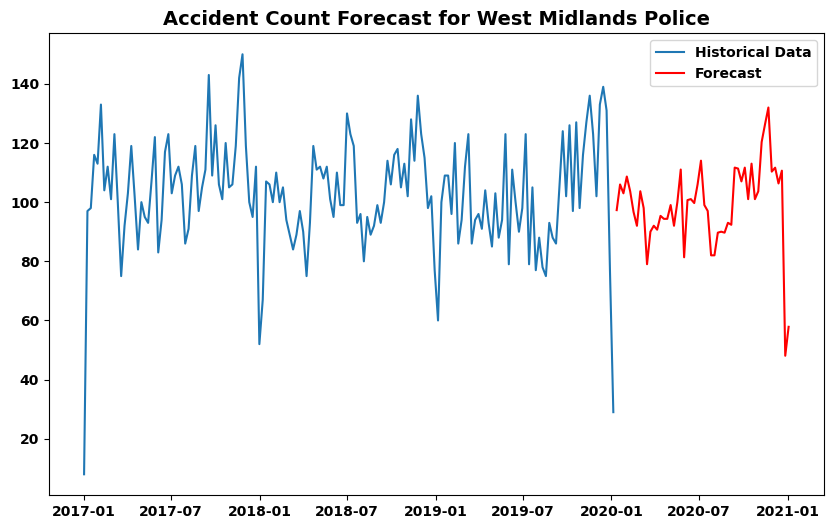

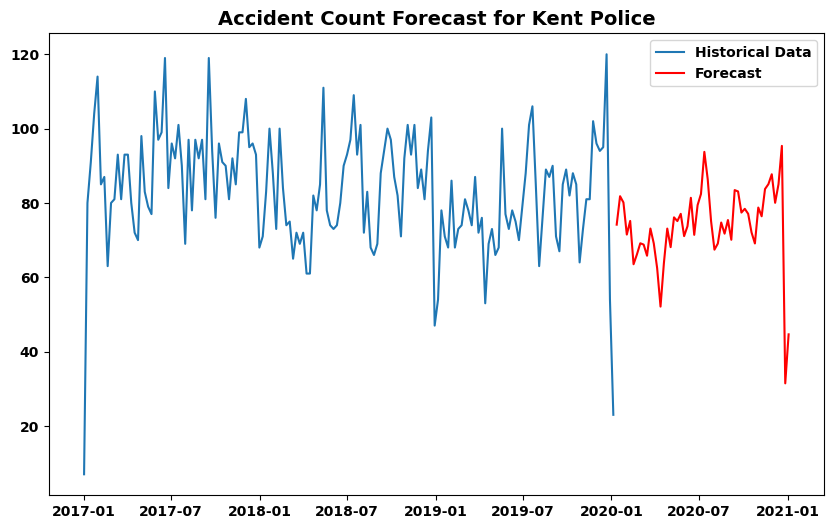

                           RMSE        MAE  sMAPE
Metropolitan Police   40.961574  30.180378    NaN
West Midlands Police  12.219935   9.727998    NaN
Kent Police           11.150162   9.104518    NaN


In [51]:
# Function to calculate sMAPE 
def smape(y_true, y_pred):
    epsilon = 1e-10  
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator == 0, epsilon, denominator)
    return 100 * np.mean(numerator / denominator)

final_data['date'] = pd.to_datetime(final_data['date'])
final_data.set_index('date', inplace=True)

# Create a dictionary for storing forecasts and evaluation metrics for each police force
ets_predictions = {}
metrics = {}

# Iterate through each police force and fit an ETS model
for force in final_data['police_force'].unique():
    force_data = final_data[final_data['police_force'] == force]
    
    # Fit the ETS model (Exponential Smoothing)
    model = ExponentialSmoothing(force_data['accident_count'], 
                                 trend='add', 
                                 seasonal='add', 
                                 seasonal_periods=52)  # 52 weeks for yearly seasonality
    
    # Fit the model
    ets_model = model.fit()
    
    # Make future predictions for the next year (52 weeks)
    forecast = ets_model.forecast(52)  # Forecast for the next 52 weeks
    
    # Store the forecast for later use
    ets_predictions[force] = forecast
    
    # Plot the forecast for each police force
    plt.figure(figsize=(10, 6))
    plt.plot(force_data.index, force_data['accident_count'], label='Historical Data')
    future_dates = pd.date_range(start=force_data.index[-1], periods=53, freq='W-SUN')[1:]
    plt.plot(future_dates, forecast, label='Forecast', color='red')
    plt.title(f"Accident Count Forecast for {force}")
    plt.legend()
    plt.show()
    
    # Evaluation using the last 52 weeks of historical data
    actual_values = force_data['accident_count'][-52:]  # Last 52 observed values (for evaluation)
    predicted_values = forecast  # Forecasted values for the next year

    # RMSE
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    
    # MAE
    mae = mean_absolute_error(actual_values, predicted_values)
    
    # sMAPE
    smape_value = smape(actual_values, predicted_values)

    # Store metrics for each police force
    metrics[force] = {
        'RMSE': rmse,
        'MAE': mae,
        'sMAPE': smape_value
    }

# Display the evaluation metrics
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# Comparison of Different Time Series Models

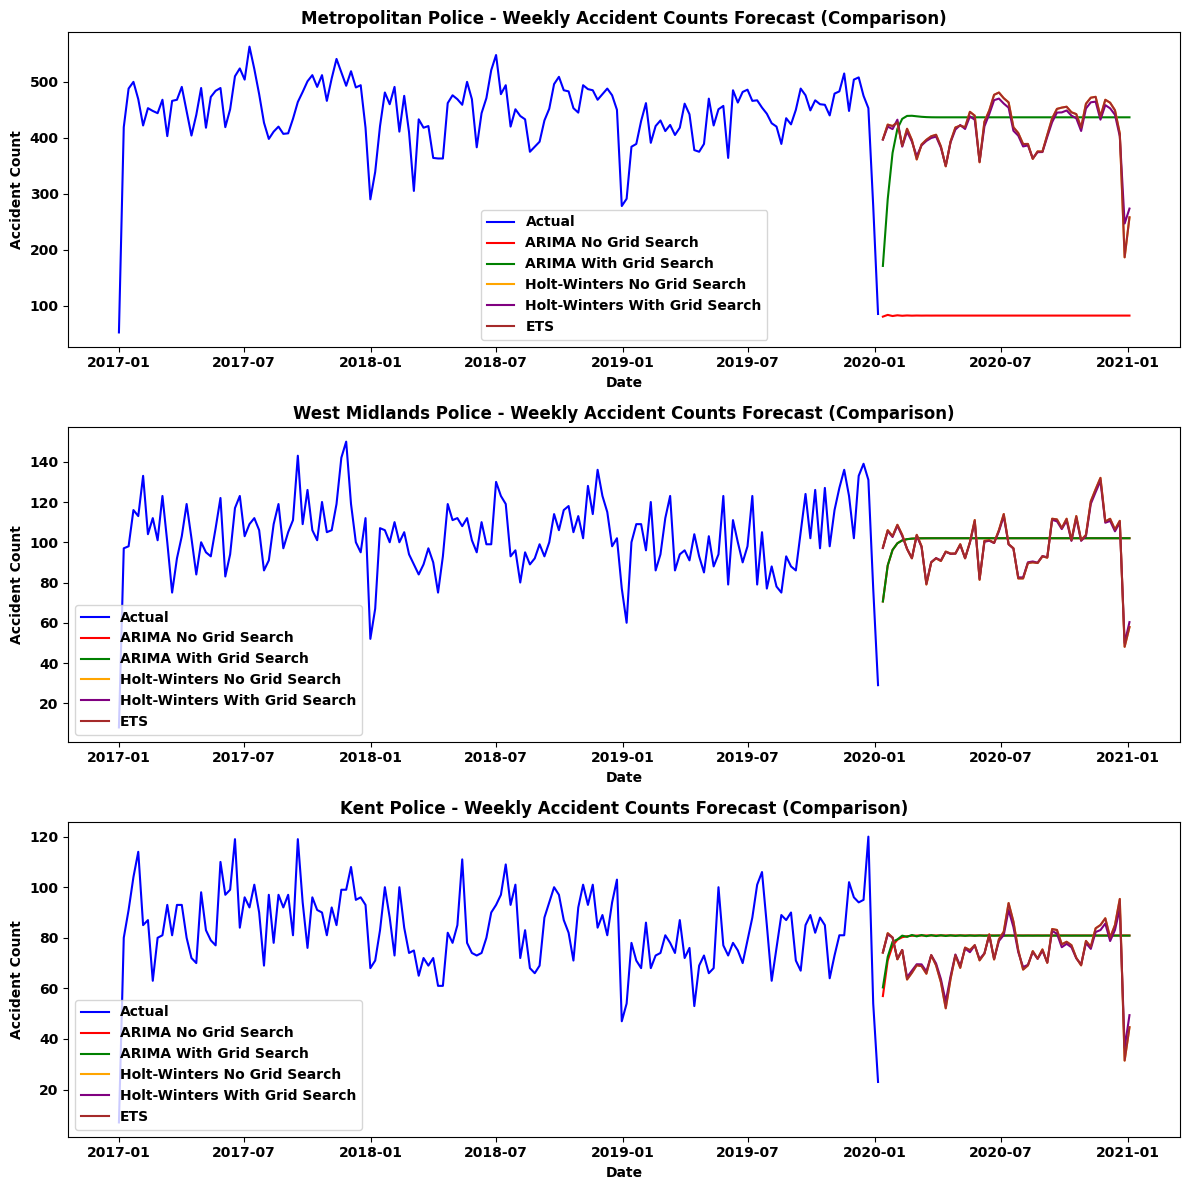


Evaluation Metrics Comparison:

ARIMA (No Grid Search) Evaluation Metrics:
Metropolitan Police: RMSE: 56.95452799608665, MAE: 38.09893063657108, SMAPE: 10.860242088859687%
West Midlands Police: RMSE: 18.364654864897155, MAE: 13.682769017261336, SMAPE: 15.407895304702853%
Kent Police: RMSE: 15.210970731421732, MAE: 11.23526351282456, SMAPE: 15.477638013780446%

ARIMA (With Grid Search) Evaluation Metrics:
Metropolitan Police: RMSE: 56.18763564507914, MAE: 37.06332541464856, SMAPE: 10.604819920917304%
West Midlands Police: RMSE: 18.364654864897155, MAE: 13.682769017261336, SMAPE: 15.407895304702853%
Kent Police: RMSE: 15.051688311359126, MAE: 11.015716236591405, SMAPE: 15.230584726251074%

Holt-Winters (No Grid Search) Evaluation Metrics:
Metropolitan Police: RMSE: 36.50106670073359, MAE: 23.394745025448984, SMAPE: 6.553759707775423%
West Midlands Police: RMSE: 11.752867513890775, MAE: 9.110200913350656, SMAPE: 9.847520685856658%
Kent Police: RMSE: 10.447980151127892, MAE: 8.17881551320

In [52]:
# Plotting the results for all models (ARIMA, Holt-Winters, ETS)
plt.figure(figsize=(12, 12))

for idx, police_force in enumerate(unique_police_forces, 1):
    # ARIMA results (without and with grid search)
    police_results_arima_no_grid = results_arima_no_gridsearch[police_force]
    forecast_arima_no_grid = police_results_arima_no_grid['forecast']
    
    police_results_arima_with_grid = results_arima_with_gridsearch[police_force]
    forecast_arima_with_grid = police_results_arima_with_grid['forecast']
    
    # Holt-Winters results (without and with grid search)
    police_results_hw_no_grid = results_no_gridsearch[police_force]
    forecast_hw_no_grid = police_results_hw_no_grid['forecast']
    
    police_results_hw_with_grid = results_with_gridsearch[police_force]
    forecast_hw_with_grid = police_results_hw_with_grid['forecast']
    
    # ETS results
    forecast_ets = ets_predictions[police_force]

    # Actual data for the police force
    actual_data = police_results_arima_no_grid['actual_data']
    
    # Plotting the actual data and forecasts
    plt.subplot(len(unique_police_forces), 1, idx)
    plt.plot(actual_data.index, actual_data['accident_count'], label='Actual', color='blue')
    plt.plot(pd.date_range(start=actual_data.index[-1], periods=len(forecast_arima_no_grid) + 1, freq='W')[1:], forecast_arima_no_grid, label='ARIMA No Grid Search', color='red')
    plt.plot(pd.date_range(start=actual_data.index[-1], periods=len(forecast_arima_with_grid) + 1, freq='W')[1:], forecast_arima_with_grid, label='ARIMA With Grid Search', color='green')
    plt.plot(pd.date_range(start=actual_data.index[-1], periods=len(forecast_hw_no_grid) + 1, freq='W')[1:], forecast_hw_no_grid, label='Holt-Winters No Grid Search', color='orange')
    plt.plot(pd.date_range(start=actual_data.index[-1], periods=len(forecast_hw_with_grid) + 1, freq='W')[1:], forecast_hw_with_grid, label='Holt-Winters With Grid Search', color='purple')
    plt.plot(pd.date_range(start=actual_data.index[-1], periods=len(forecast_ets) + 1, freq='W')[1:], forecast_ets, label='ETS', color='brown')
    
    # Titles and labels
    plt.title(f"{police_force} - Weekly Accident Counts Forecast (Comparison)", fontsize=12, weight='bold')
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Accident Count", fontsize=10)
    plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.savefig('Model Comparison.png')
plt.show()

# Evaluation Metrics - Displaying for all models
print("\nEvaluation Metrics Comparison:")

# For ARIMA (No Grid Search)
print("\nARIMA (No Grid Search) Evaluation Metrics:")
for police_force, metrics in results_arima_no_gridsearch.items():
    print(f"{police_force}: RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, SMAPE: {metrics['smape']}%")

# For ARIMA (With Grid Search)
print("\nARIMA (With Grid Search) Evaluation Metrics:")
for police_force, metrics in results_arima_with_gridsearch.items():
    print(f"{police_force}: RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, SMAPE: {metrics['smape']}%")

# For Holt-Winters (No Grid Search)
print("\nHolt-Winters (No Grid Search) Evaluation Metrics:")
for police_force, metrics in results_no_gridsearch.items():
    print(f"{police_force}: RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, SMAPE: {metrics['smape']}%")

# For Holt-Winters (With Grid Search)
print("\nHolt-Winters (With Grid Search) Evaluation Metrics:")
for police_force, metrics in results_with_gridsearch.items():
    print(f"{police_force}: RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, SMAPE: {metrics['smape']}%")

# For ETS
#print("\nETS Evaluation Metrics:")
#for police_force, metrics in metrics.items():
#    print(f"{police_force}: RMSE: {metrics['RMSE']}, MAE: {metrics['MAE']}, SMAPE: {metrics['sMAPE']}%")


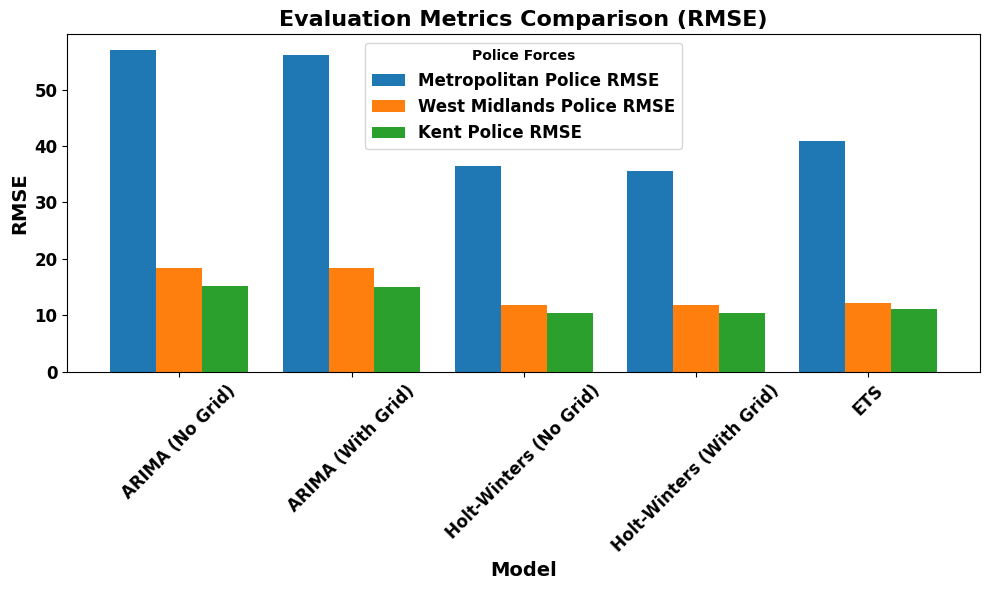

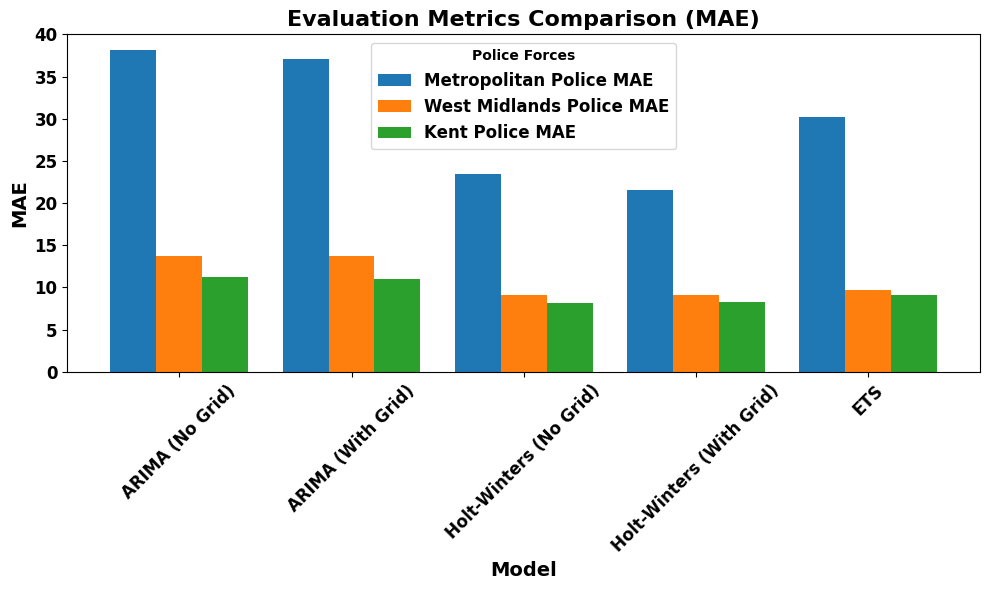

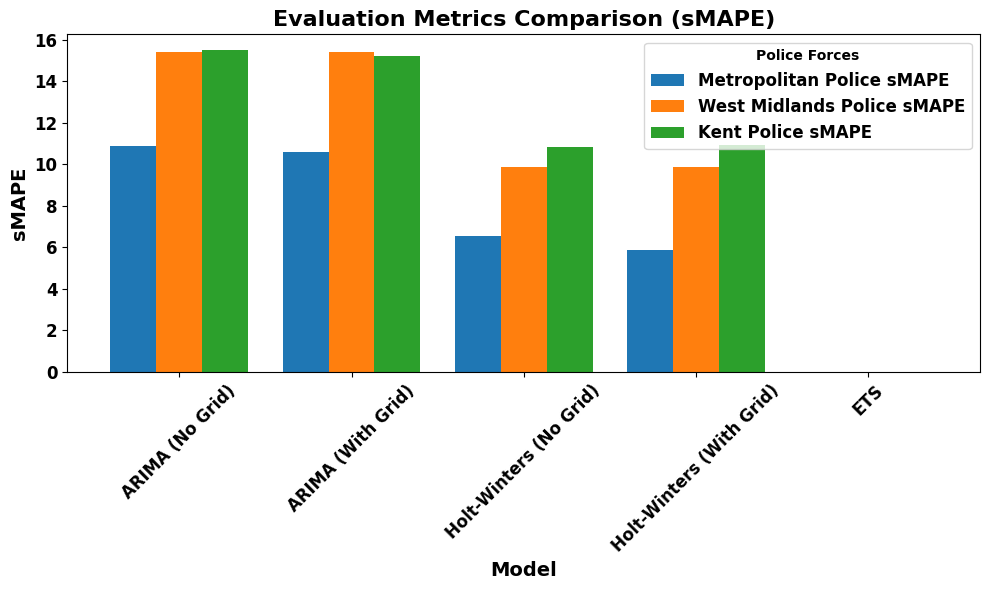

In [53]:
# Define the evaluation metrics
evaluation_data = {
    'Model': ['ARIMA (No Grid)', 'ARIMA (With Grid)', 'Holt-Winters (No Grid)', 'Holt-Winters (With Grid)', 'ETS'],
    'Metropolitan Police RMSE': [56.9545, 56.1876, 36.5011, 35.5215, 40.9616],
    'West Midlands Police RMSE': [18.3647, 18.3647, 11.7529, 11.7410, 12.2199],
    'Kent Police RMSE': [15.2110, 15.0517, 10.4480, 10.4340, 11.1502],
    
    'Metropolitan Police MAE': [38.0989, 37.0633, 23.3947, 21.5246, 30.1804],
    'West Midlands Police MAE': [13.6828, 13.6828, 9.1102, 9.1143, 9.7280],
    'Kent Police MAE': [11.2353, 11.0157, 8.1788, 8.2421, 9.1045],
    
    'Metropolitan Police sMAPE': [10.8602, 10.6048, 6.5538, 5.8845, np.nan],
    'West Midlands Police sMAPE': [15.4079, 15.4079, 9.8475, 9.8540, np.nan],
    'Kent Police sMAPE': [15.4776, 15.2306, 10.8226, 10.9167, np.nan]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(evaluation_data)

# Plotting RMSE values
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', x='Model', y=['Metropolitan Police RMSE', 'West Midlands Police RMSE', 'Kent Police RMSE'],
        ax=ax, width=0.8, fontsize=12)

ax.set_ylabel('RMSE', fontsize=14)
ax.set_title('Evaluation Metrics Comparison (RMSE)', fontsize=16)
ax.set_xlabel('Model', fontsize=14)
ax.legend(title='Police Forces', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('Evaluation_Metrics_Comparison_RMSE.png')
plt.show()

# Plotting MAE values
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', x='Model', y=['Metropolitan Police MAE', 'West Midlands Police MAE', 'Kent Police MAE'],
        ax=ax, width=0.8, fontsize=12)

ax.set_ylabel('MAE', fontsize=14)
ax.set_title('Evaluation Metrics Comparison (MAE)', fontsize=16)
ax.set_xlabel('Model', fontsize=14)
ax.legend(title='Police Forces', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('Evaluation_Metrics_Comparison_MAE.png')
plt.show()

# Plotting sMAPE values (fill NaN with 0 for visualization)
df_smap = df.copy()
df_smap['Metropolitan Police sMAPE'] = df_smap['Metropolitan Police sMAPE'].fillna(0)
df_smap['West Midlands Police sMAPE'] = df_smap['West Midlands Police sMAPE'].fillna(0)
df_smap['Kent Police sMAPE'] = df_smap['Kent Police sMAPE'].fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

df_smap.plot(kind='bar', x='Model', y=['Metropolitan Police sMAPE', 'West Midlands Police sMAPE', 'Kent Police sMAPE'],
             ax=ax, width=0.8, fontsize=12)

ax.set_ylabel('sMAPE', fontsize=14)
ax.set_title('Evaluation Metrics Comparison (sMAPE)', fontsize=16)
ax.set_xlabel('Model', fontsize=14)
ax.legend(title='Police Forces', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('Evaluation_Metrics_Comparison_sMAPE.png')
plt.show()


# TASK 7: Time Series for Small Dataset

In [54]:
accidents_2020 = dfs['accident']
vehicle_2020 = dfs['vehicle']
casualty_2020 = dfs['casualty']
lsoa_2020 = dfs['lsoa']

Top 3 LSOAs with the highest accident counts between January and March 2020:
   lsoa_of_accident_location  accident_count
14                 E01012817               6
26                 E01012852               4
10                 E01012809               3


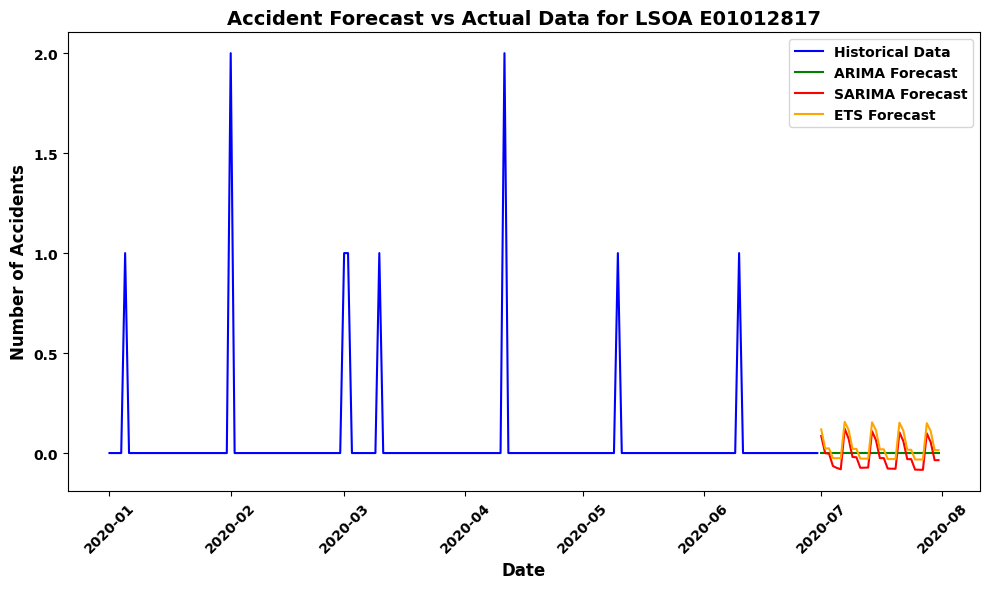


Forecast for July 2020 for LSOA E01012817 (ARIMA, SARIMA, ETS):
ARIMA Forecast: 2020-05-31    1.120137e-52
2020-06-01    5.521360e-53
2020-06-02    4.097881e-53
2020-06-03    2.980950e-53
2020-06-04    3.766097e-53
2020-06-05    4.485744e-53
2020-06-06    5.371097e-53
2020-06-07    4.483739e-53
2020-06-08    4.210872e-53
2020-06-09    4.191287e-53
2020-06-10    4.385068e-53
2020-06-11    4.514674e-53
2020-06-12    4.540229e-53
2020-06-13    4.402261e-53
2020-06-14    4.372119e-53
2020-06-15    4.394444e-53
2020-06-16    4.430700e-53
2020-06-17    4.443408e-53
2020-06-18    4.433518e-53
2020-06-19    4.414164e-53
2020-06-20    4.413725e-53
2020-06-21    4.420508e-53
2020-06-22    4.425708e-53
2020-06-23    4.425621e-53
2020-06-24    4.422669e-53
2020-06-25    4.420444e-53
2020-06-26    4.421204e-53
2020-06-27    4.422539e-53
2020-06-28    4.423054e-53
2020-06-29    4.422688e-53
2020-06-30    4.422152e-53
Freq: D, Name: predicted_mean, dtype: float64
SARIMA Forecast: 2020-05-31    0.085

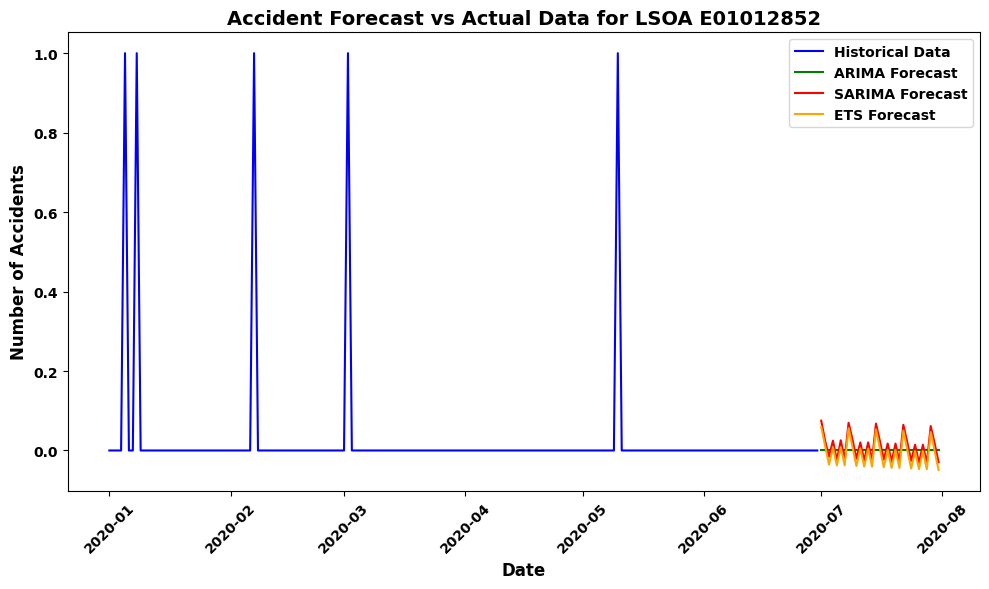


Forecast for July 2020 for LSOA E01012852 (ARIMA, SARIMA, ETS):
ARIMA Forecast: 2020-05-31    1.792881e-53
2020-06-01    1.478230e-53
2020-06-02    9.533083e-54
2020-06-03    9.449652e-54
2020-06-04    9.791444e-54
2020-06-05    1.055921e-53
2020-06-06    1.144047e-53
2020-06-07    1.057358e-53
2020-06-08    1.028363e-53
2020-06-09    1.057241e-53
2020-06-10    1.056175e-53
2020-06-11    1.061343e-53
2020-06-12    1.063370e-53
2020-06-13    1.053607e-53
2020-06-14    1.055615e-53
2020-06-15    1.058957e-53
2020-06-16    1.057401e-53
2020-06-17    1.057903e-53
2020-06-18    1.057793e-53
2020-06-19    1.057021e-53
2020-06-20    1.057623e-53
2020-06-21    1.057748e-53
2020-06-22    1.057483e-53
2020-06-23    1.057599e-53
2020-06-24    1.057565e-53
2020-06-25    1.057516e-53
2020-06-26    1.057595e-53
2020-06-27    1.057574e-53
2020-06-28    1.057550e-53
2020-06-29    1.057572e-53
2020-06-30    1.057563e-53
Freq: D, Name: predicted_mean, dtype: float64
SARIMA Forecast: 2020-05-31    0.075

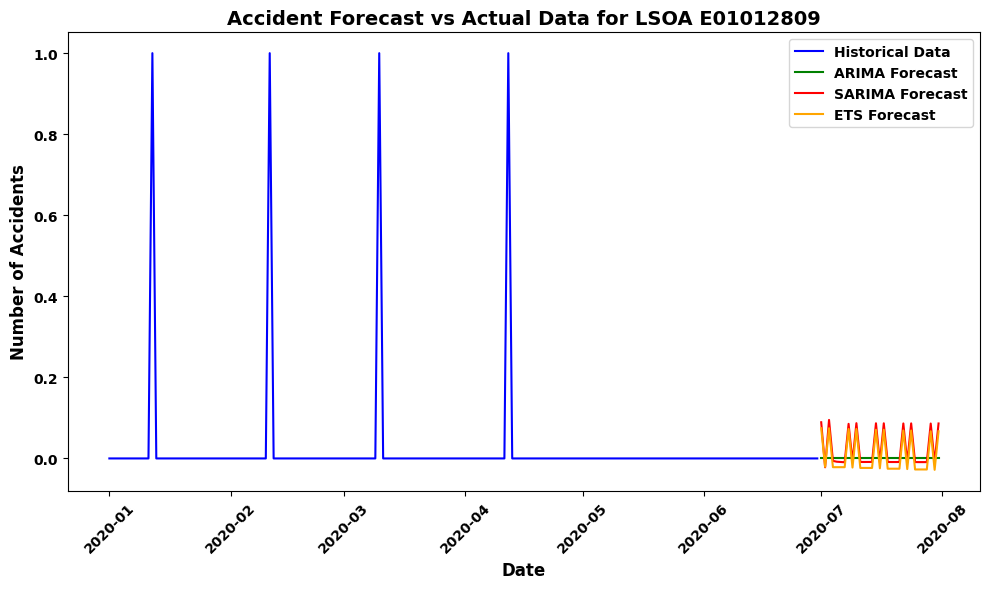


Forecast for July 2020 for LSOA E01012809 (ARIMA, SARIMA, ETS):
ARIMA Forecast: 2020-05-31    2.674075e-138
2020-06-01   -3.597171e-140
2020-06-02    2.181876e-139
2020-06-03    3.436276e-139
2020-06-04    4.702207e-139
2020-06-05    6.161889e-139
2020-06-06    7.049790e-139
2020-06-07    3.917077e-139
2020-06-08    4.597234e-139
2020-06-09    4.981992e-139
2020-06-10    5.228143e-139
2020-06-11    5.311710e-139
2020-06-12    5.176227e-139
2020-06-13    4.878177e-139
2020-06-14    5.031108e-139
2020-06-15    5.100205e-139
2020-06-16    5.119016e-139
2020-06-17    5.101621e-139
2020-06-18    5.068176e-139
2020-06-19    5.050996e-139
2020-06-20    5.078500e-139
2020-06-21    5.086046e-139
2020-06-22    5.083789e-139
2020-06-23    5.078179e-139
2020-06-24    5.074449e-139
2020-06-25    5.075450e-139
2020-06-26    5.079341e-139
2020-06-27    5.079475e-139
2020-06-28    5.078429e-139
2020-06-29    5.077576e-139
2020-06-30    5.077480e-139
Freq: D, Name: predicted_mean, dtype: float64
SARIM

In [55]:
# Filter the accidents data for Kingston Upon Hull and the date range from January to March 2020
accidents_2020['date'] = pd.to_datetime(accidents_2020['date'], errors='coerce')

# Filter Kingston Upon Hull LSOAs
lsoas_hull = lsoa_2020[lsoa_2020['lsoa01nm'].str.contains('Kingston upon Hull', na=False)]
lsoas_hull_list = lsoas_hull['lsoa01cd'].tolist()

# Filter accidents data for the LSOAs in Hull between January and March 2020
accidents_filtered = accidents_2020[
    (accidents_2020['lsoa_of_accident_location'].isin(lsoas_hull_list)) &
    (accidents_2020['date'] >= '2020-01-01') &
    (accidents_2020['date'] <= '2020-03-31')
]

# Group by LSOA and calculate the total number of accidents between January and March 2020
accidents_grouped = accidents_filtered.groupby('lsoa_of_accident_location').size().reset_index(name='accident_count')

# Sort the LSOAs by accident count in descending order to get the top 3
top_3_lsoas = accidents_grouped.sort_values(by='accident_count', ascending=False).head(3)

# Display the top 3 LSOAs with the highest accident counts
print("Top 3 LSOAs with the highest accident counts between January and March 2020:")
print(top_3_lsoas)

# Define the top 3 LSOAs
top_3_lsoas_list = top_3_lsoas['lsoa_of_accident_location'].tolist()

# Filter accidents data for the top 3 LSOAs between January and June 2020
accidents_hull_lsoas = accidents_2020[accidents_2020['lsoa_of_accident_location'].isin(top_3_lsoas_list)]
accidents_hull_jan_jun = accidents_hull_lsoas[(accidents_hull_lsoas['date'] >= '2020-01-01') & (accidents_hull_lsoas['date'] <= '2020-06-30')]

# Process and train the ARIMA, SARIMA, ETS models for each LSOA
results = {}

for lsoa in top_3_lsoas_list:
    lsoa_accidents = accidents_hull_jan_jun[accidents_hull_jan_jun['lsoa_of_accident_location'] == lsoa]
    
    # Group by date and count accidents
    daily_accidents = lsoa_accidents.groupby('date').size()

    # Resample to daily frequency from Jan 1 to Jun 30, 2020, filling missing days with 0 accidents
    daily_accidents_resampled = daily_accidents.resample('D').sum()

    # Fill missing values (if any) with zero accidents for the entire range of dates
    daily_accidents_resampled = daily_accidents_resampled.fillna(0)

    # Ensure the frequency is set to daily ('D') from January 1 to June 30, 2020
    daily_accidents_resampled = daily_accidents_resampled.asfreq('D', fill_value=0)
    
    # Verify that the date range is from Jan 1 to Jun 30, 2020
    expected_dates = pd.date_range('2020-01-01', '2020-06-30', freq='D')
    daily_accidents_resampled = daily_accidents_resampled.reindex(expected_dates, fill_value=0)

    # Split the data into 70% training and 30% testing (validation)
    train_size = int(len(daily_accidents_resampled) * 0.83)
    train_data, test_data = daily_accidents_resampled[:train_size], daily_accidents_resampled[train_size:]

    # Fit ARIMA Model
    model_arima = ARIMA(train_data, order=(5, 1, 0))  # Adjust parameters if needed
    model_arima_fit = model_arima.fit()

    # Fit SARIMA Model
    model_sarima = SARIMAX(train_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 7))  # Adjust seasonal parameters
    model_sarima_fit = model_sarima.fit()

    # Fit Holt-Winters Exponential Smoothing (ETS) Model
    model_ets = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=7)
    model_ets_fit = model_ets.fit()

    # Forecast the next 31 days (July 2020)
    forecast_arima = model_arima_fit.forecast(steps=31)
    forecast_sarima = model_sarima_fit.forecast(steps=31)
    forecast_ets = model_ets_fit.forecast(steps=31)

    # Calculate RMSE for the forecast on the test set
    rmse_arima = np.sqrt(mean_squared_error(test_data, forecast_arima))
    rmse_sarima = np.sqrt(mean_squared_error(test_data, forecast_sarima))
    rmse_ets = np.sqrt(mean_squared_error(test_data, forecast_ets))

    # Store the results in the dictionary (remove smape)
    results[lsoa] = {
        'model_arima_summary': model_arima_fit.summary(),
        'forecast_arima': forecast_arima,
        'forecast_sarima': forecast_sarima,
        'forecast_ets': forecast_ets,
        'rmse_arima': rmse_arima,
        'rmse_sarima': rmse_sarima,
        'rmse_ets': rmse_ets
    }

    # Plot actual vs forecasted data for each LSOA
    plt.figure(figsize=(10, 6))
    plt.plot(daily_accidents_resampled.index, daily_accidents_resampled, label='Historical Data', color='blue')
    plt.plot(pd.date_range('2020-07-01', '2020-07-31'), forecast_arima, label='ARIMA Forecast', color='green')
    plt.plot(pd.date_range('2020-07-01', '2020-07-31'), forecast_sarima, label='SARIMA Forecast', color='red')
    plt.plot(pd.date_range('2020-07-01', '2020-07-31'), forecast_ets, label='ETS Forecast', color='orange')
    plt.title(f'Accident Forecast vs Actual Data for LSOA {lsoa}')
    plt.xlabel('Date')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.xticks(rotation=45)
    # Adjust the layout
    plt.tight_layout()

    # Save the plot 
    plt.savefig(f'forecast_comparison_LSOA_{lsoa}.png')

    # Show the plot
    plt.show()

    # Print forecast for July 2020 for each model
    print(f"\nForecast for July 2020 for LSOA {lsoa} (ARIMA, SARIMA, ETS):")
    print("ARIMA Forecast:", forecast_arima)
    print("SARIMA Forecast:", forecast_sarima)
    print("ETS Forecast:", forecast_ets)

    # Print RMSE for model evaluation
    print(f"\nRMSE for LSOA {lsoa}:")
    print(f"ARIMA RMSE: {rmse_arima}")
    print(f"SARIMA RMSE: {rmse_sarima}")
    print(f"ETS RMSE: {rmse_ets}")
    print("\n" + "="*80)

# After looping through all LSOAs, print the overall results
print("Overall Results for all LSOAs:")
for lsoa, result in results.items():
    print(f"\nLSOA {lsoa}:")
    print(f"ARIMA RMSE: {result['rmse_arima']}")
    print(f"SARIMA RMSE: {result['rmse_sarima']}")
    print(f"ETS RMSE: {result['rmse_ets']}")


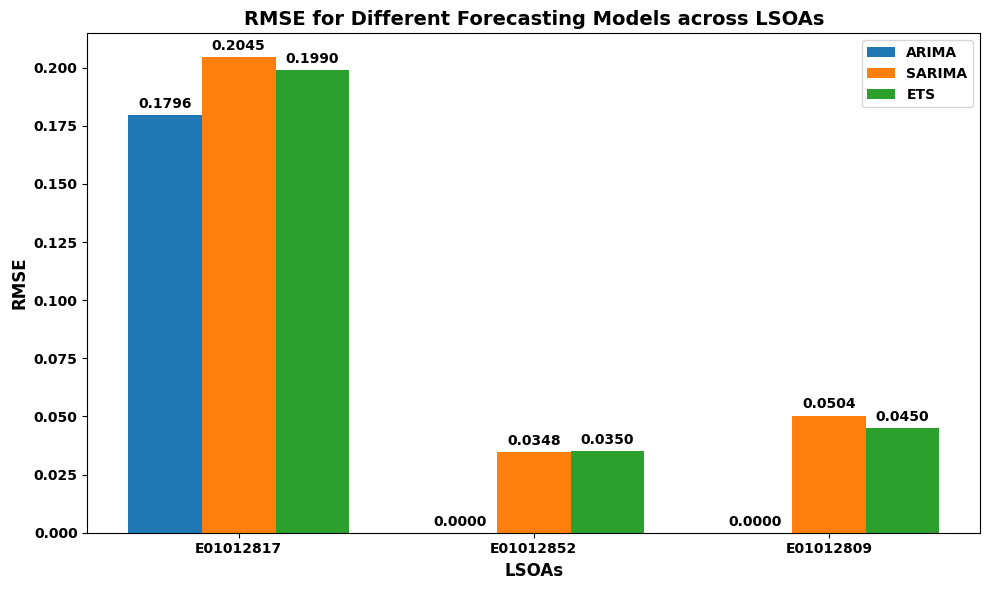

In [56]:
# Data for the RMSE values
lsoas = ['E01012817', 'E01012852', 'E01012809']
arima_rmse = [0.1796, 1.0979806593094697e-53, 6.833245925366129e-139]
sarima_rmse = [0.2045, 0.034783510783493184, 0.050397416494573764]
ets_rmse = [0.1990, 0.03499595644991184, 0.044994824504099536]

# Set up the bar plot positions
x = np.arange(len(lsoas))  # The label locations
width = 0.25  # The width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each model
rects1 = ax.bar(x - width, arima_rmse, width, label='ARIMA')
rects2 = ax.bar(x, sarima_rmse, width, label='SARIMA')
rects3 = ax.bar(x + width, ets_rmse, width, label='ETS')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('LSOAs')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for Different Forecasting Models across LSOAs')
ax.set_xticks(x)
ax.set_xticklabels(lsoas)
ax.legend()

# Labeling the bars with their heights (RMSE values)
def label_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',  # Format to 4 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom')

# Label the bars with RMSE values
label_bars(rects1)
label_bars(rects2)
label_bars(rects3)

# Show the plot
plt.tight_layout()

# Saving the plot to a file (e.g., as a PNG file)
plt.tight_layout()
plt.savefig('rmse_comparison_lsoas.png')

plt.show()

# Social Network Construction

In [57]:
#pip install python-louvain

# Construct the Network and Calculate Basic Network Characteristics and Data Cleaning

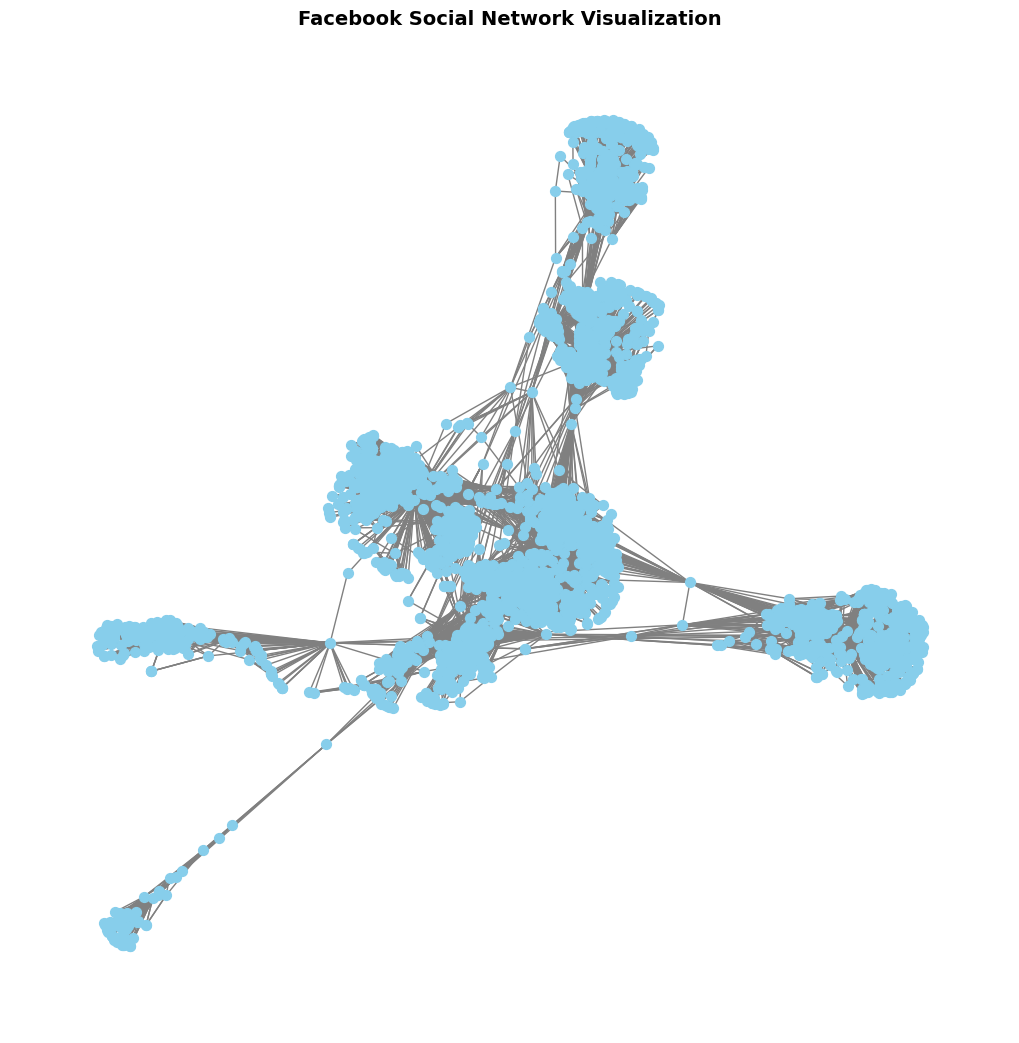

Number of nodes: 4039
Number of edges: 88234
Network Density: 0.0108
Average Degree: 43.69


In [58]:
# Load the Facebook combined graph from the file
G = nx.read_edgelist('facebook_combined.txt')

# Task 8: Visualize the Network
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_color='skyblue', edge_color='gray', node_size=50, font_size=8)
plt.title("Facebook Social Network Visualization")
plt.savefig('facebook_s_n.png')
plt.show()

# Basic Network Characteristics
N = G.number_of_nodes()  # Number of nodes
E = G.number_of_edges()  # Number of edges
density = nx.density(G)  # Network density
avg_degree = sum(dict(G.degree()).values()) / N  # Average degree

print(f"Number of nodes: {N}")
print(f"Number of edges: {E}")
print(f"Network Density: {density:.4f}")
print(f"Average Degree: {avg_degree:.2f}")

In [59]:
# Remove duplicate edges 
G = nx.Graph(G)  # Reconstruct the graph to ensure unique edges

# Verify if duplicates were removed
print(f"Number of edges after removing duplicates: {G.number_of_edges()}")


Number of edges after removing duplicates: 88234


In [60]:
# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Verify if self-loops were removed
print(f"Number of edges after removing self-loops: {G.number_of_edges()}")

Number of edges after removing self-loops: 88234


In [61]:
# Identify isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated_nodes)}")

# remove isolated nodes 
G.remove_nodes_from(isolated_nodes)
print(f"Number of nodes after removing isolated nodes: {G.number_of_nodes()}")

Number of isolated nodes: 0
Number of nodes after removing isolated nodes: 4039


In [62]:
# Final check of the graph's properties
print(f"Final number of nodes: {G.number_of_nodes()}")
print(f"Final number of edges: {G.number_of_edges()}")

Final number of nodes: 4039
Final number of edges: 88234


def main():
    # Create or load your graph `G`
    G = nx.karate_club_graph()  # Example graph

    centrality_methods = {
        "Betweenness": calculate_edge_betweenness_centrality(G),
        "Closeness": calculate_edge_closeness_centrality(G),
        "Degree": calculate_edge_degree_centrality(G),
        "Local Efficiency": calculate_edge_local_efficiency(G),
        "Flow Betweenness": calculate_edge_flow_betweenness_centrality(G),
        "Strength": calculate_edge_strength_centrality(G),
        "Eigenvector": calculate_edge_eigenvector_centrality(G),
    }

    plot_centrality_distributions(centrality_methods)

# Calculate Edge Centrality and Plot the Distribution

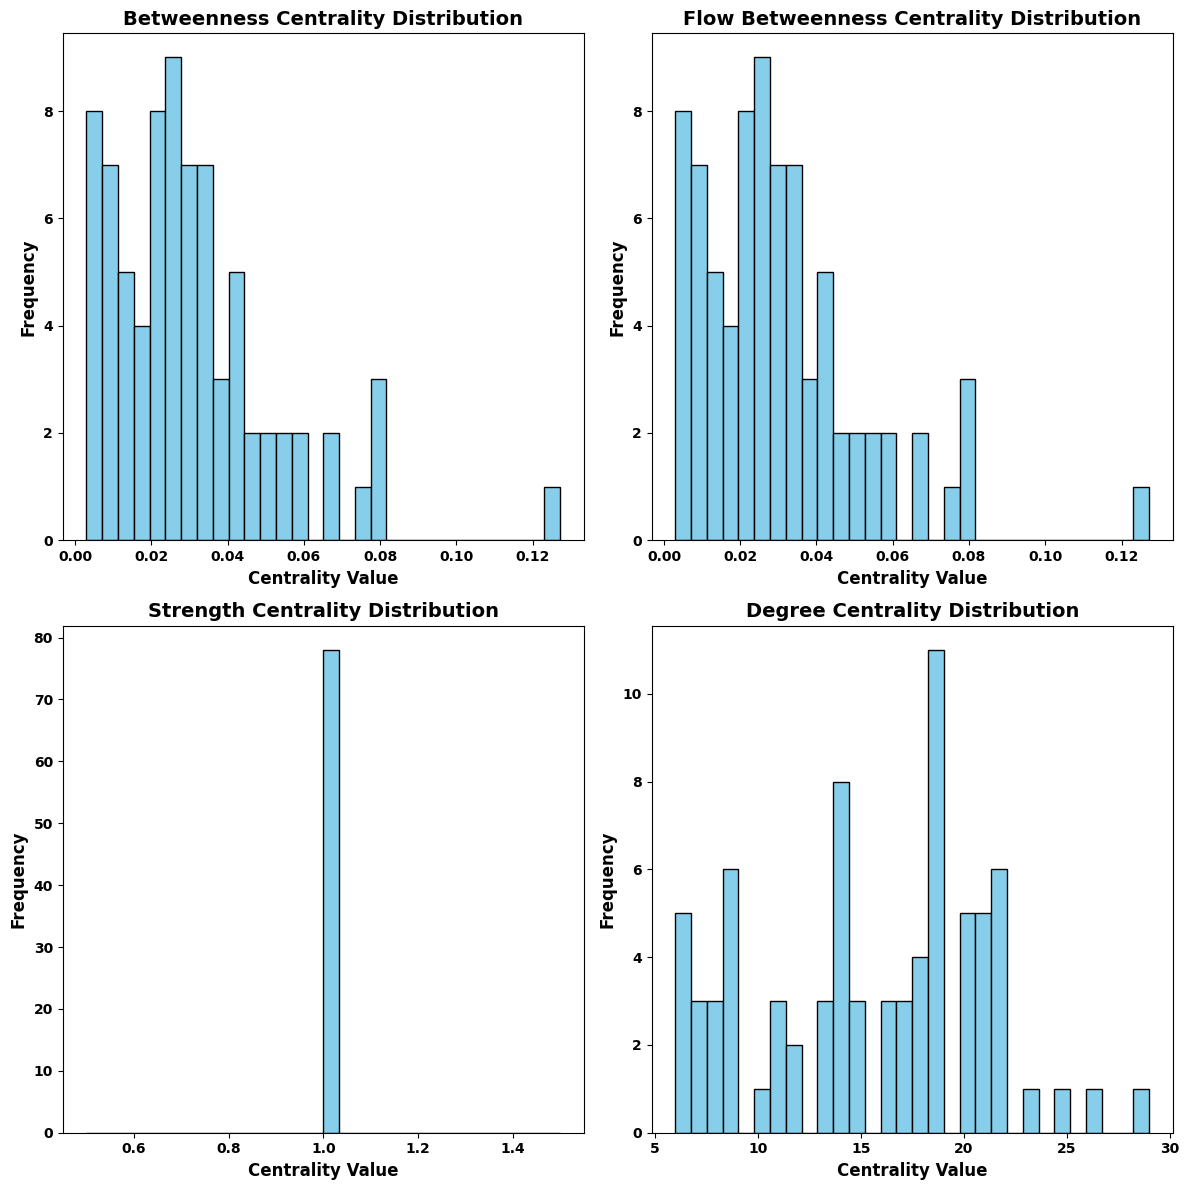

In [63]:
# Define each supported centrality calculation

def calculate_edge_betweenness_centrality(G):
    return nx.edge_betweenness_centrality(G)

def calculate_edge_flow_betweenness_centrality(G):
    # Ensure weights are assigned
    for u, v in G.edges:
        G[u][v]['weight'] = 1  # Adjust as needed
    return nx.edge_betweenness_centrality(G, normalized=True, weight='weight')

def calculate_edge_strength_centrality(G):
    return {edge: G[edge[0]][edge[1]].get('weight', 1) for edge in G.edges}

def calculate_edge_degree_centrality(G):
    return {edge: G.degree(edge[0]) + G.degree(edge[1]) for edge in G.edges}

# Function to plot centrality distributions
def plot_centrality_distributions(centrality_methods):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjust grid size if necessary
    axes = axes.flatten()
    
    for idx, (method_name, centrality_dict) in enumerate(centrality_methods.items()):
        centrality_values = list(centrality_dict.values())
        axes[idx].hist(centrality_values, bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f"{method_name} Centrality Distribution")
        axes[idx].set_xlabel("Centrality Value")
        axes[idx].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Main program to calculate and plot all centralities
def main():
    # Create or load your graph `G`
    G = nx.karate_club_graph()  # Example graph

    centrality_methods = {
        "Betweenness": calculate_edge_betweenness_centrality(G),
        "Flow Betweenness": calculate_edge_flow_betweenness_centrality(G),
        "Strength": calculate_edge_strength_centrality(G),
        "Degree": calculate_edge_degree_centrality(G),
    }

    plot_centrality_distributions(centrality_methods)

# Run the main program
if __name__ == "__main__":
    main()


G = nx.erdos_renyi_graph(50, 0.1)  # Random graph
G = nx.barabasi_albert_graph(50, 3)  # Scale-free network
G = nx.karate_club_graph()  # Real-world example


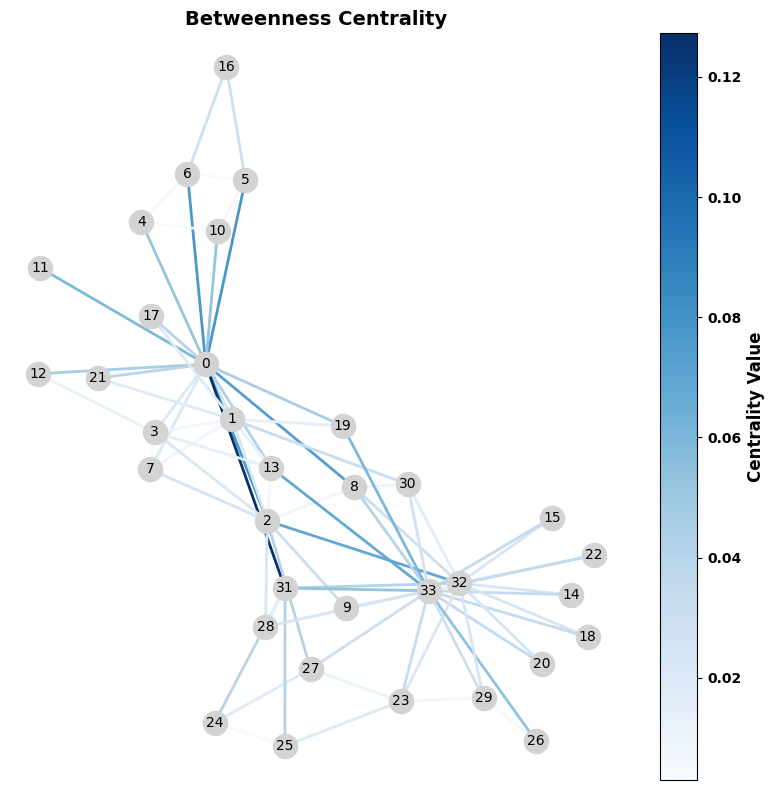

Saved: betweenness_centrality.png


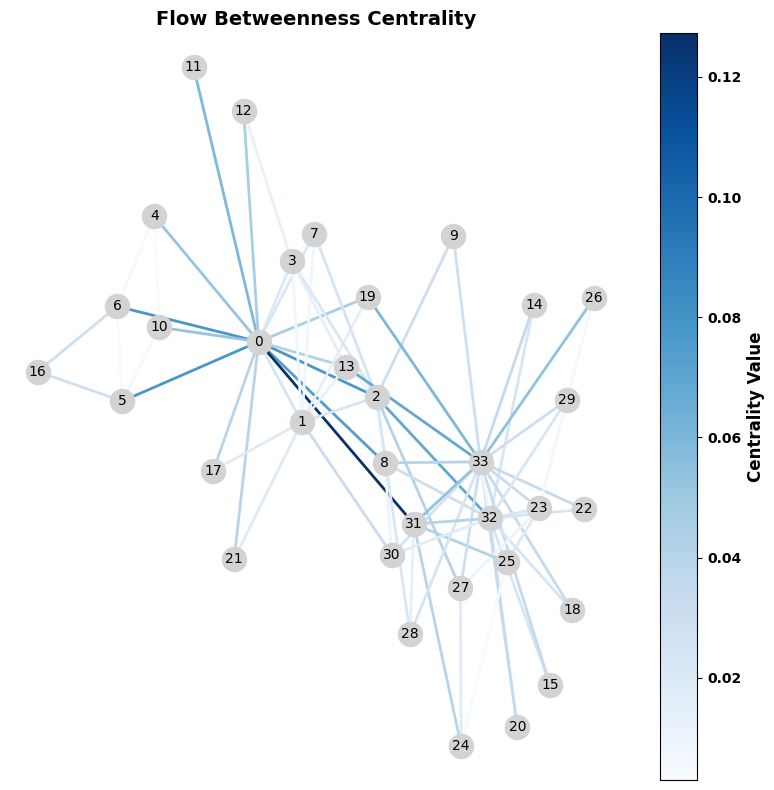

Saved: flow_betweenness_centrality.png


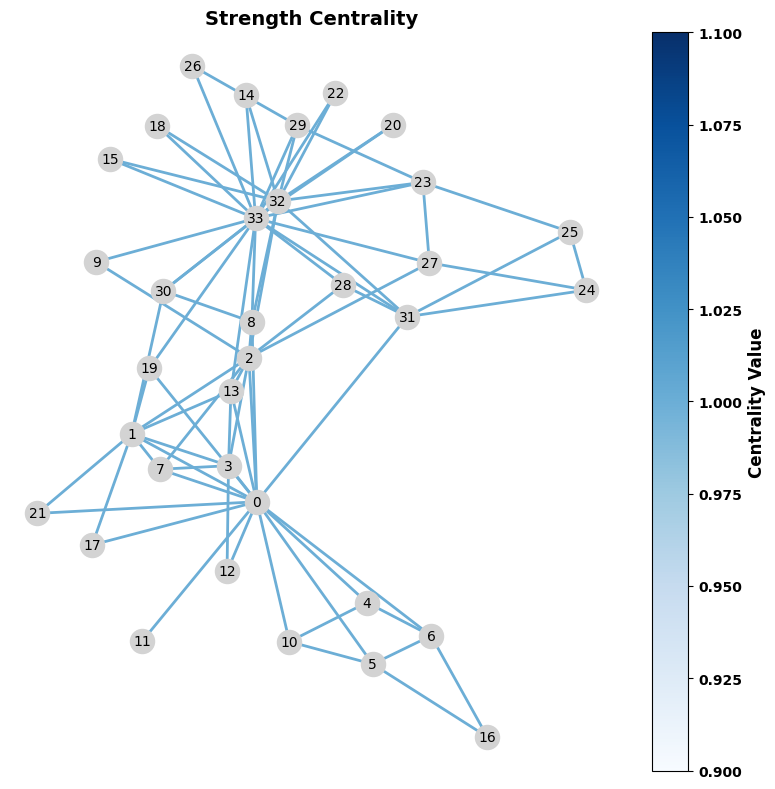

Saved: strength_centrality.png


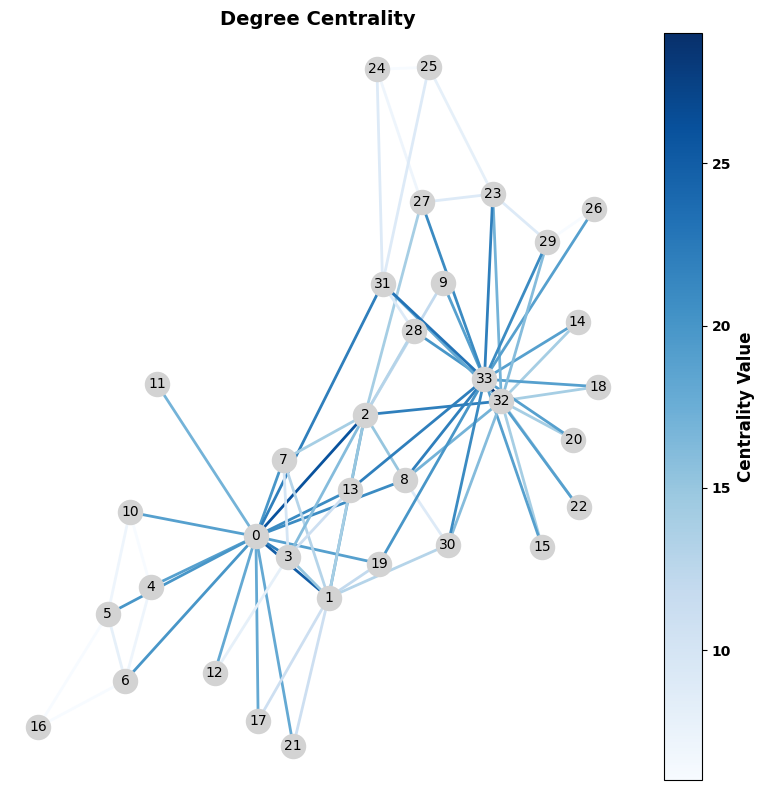

Saved: degree_centrality.png


In [64]:
# Define each supported centrality calculation
def calculate_edge_betweenness_centrality(G):
    return nx.edge_betweenness_centrality(G)

def calculate_edge_flow_betweenness_centrality(G):
    # Ensure weights are assigned
    for u, v in G.edges:
        G[u][v]['weight'] = 1  # Adjust as needed
    return nx.edge_betweenness_centrality(G, normalized=True, weight='weight')

def calculate_edge_strength_centrality(G):
    return {edge: G[edge[0]][edge[1]].get('weight', 1) for edge in G.edges}

def calculate_edge_degree_centrality(G):
    return {edge: G.degree(edge[0]) + G.degree(edge[1]) for edge in G.edges}

# Corrected visualization function with centralization and saving
def visualize_edge_centrality(G, centrality, title, filename):
    pos = nx.spring_layout(G)  # Layout for consistent positioning

    # Prepare edge colors based on centrality values
    edges, centrality_values = zip(*centrality.items())
    edge_colors = [centrality[edge] for edge in edges]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Centralize the plot with a square figure
    lc = LineCollection(
        [(pos[u], pos[v]) for u, v in edges],
        array=edge_colors,
        cmap=plt.cm.Blues,
        linewidths=2
    )
    ax.add_collection(lc)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=300, node_color="lightgray")
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_color="black")

    # Set title, colorbar, and save the plot
    plt.colorbar(lc, ax=ax, label="Centrality Value")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(filename, format="png")  # Save the plot as a PNG file
    plt.show(fig)  # Close the figure to avoid display overlap

# Main program to calculate and visualize all centralities
def main():
    # Create or load your graph `G`
    G = nx.karate_club_graph()  # Example graph

    # Calculate all supported centralities
    centrality_methods = {
        "Betweenness": calculate_edge_betweenness_centrality(G),
        "Flow Betweenness": calculate_edge_flow_betweenness_centrality(G),
        "Strength": calculate_edge_strength_centrality(G),
        "Degree": calculate_edge_degree_centrality(G),
    }

    # Visualize and save each centrality
    for name, centrality in centrality_methods.items():
        filename = f"{name.lower().replace(' ', '_')}_centrality.png"
        visualize_edge_centrality(G, centrality, f"{name} Centrality", filename)
        print(f"Saved: {filename}")

# Run the main program
if __name__ == "__main__":
    main()

# Community Detection with Two Algorithms

# Louvain Method (Modularity Maximization)

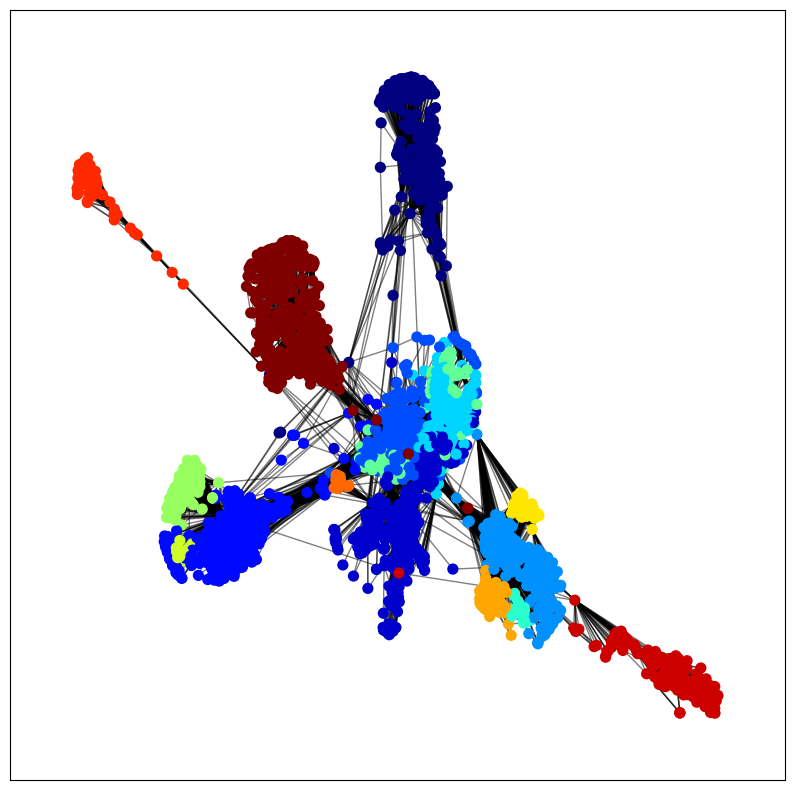

Number of communities detected using Louvain: 16


In [65]:
# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)

# Visualize the communities 
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)  # position nodes using spring layout
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50, cmap=plt.cm.jet, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Get the number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities detected using Louvain: {num_communities}")

# Label Propagation Algorithm (LPA)

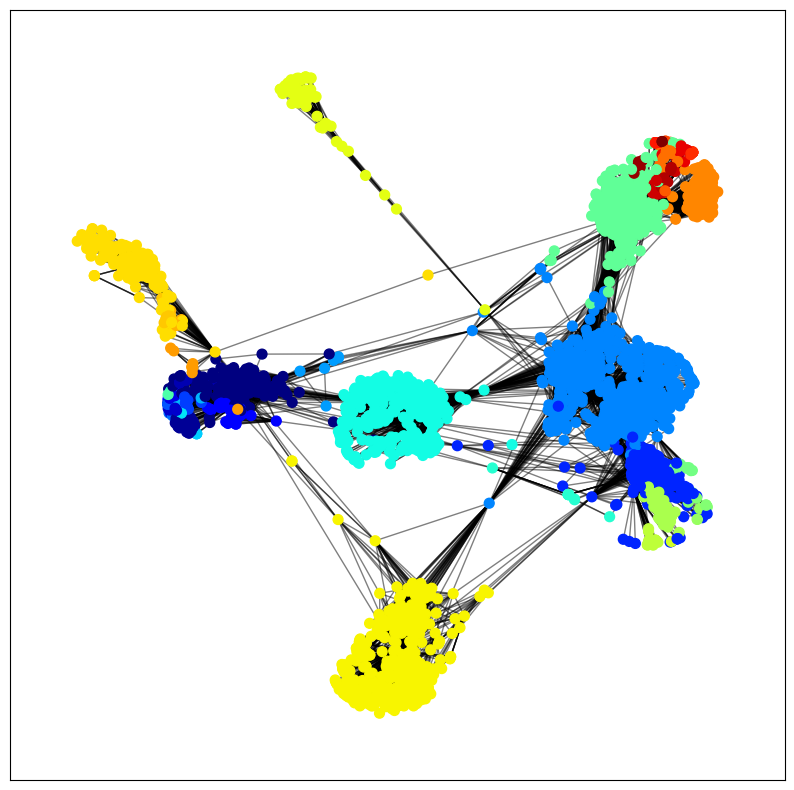

Number of communities detected using LPA: 44


In [66]:
# Apply Label Propagation Algorithm
communities_lpa = nx.algorithms.community.label_propagation_communities(G)

# Convert the community generator to a list of communities
communities_lpa_list = list(communities_lpa)

# Visualize the communities 
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)  # position nodes using spring layout
plt.figure(figsize=(10, 10))

# Assigning each node to a community (color each community differently)
node_color = []
for node in G.nodes():
    for i, community in enumerate(communities_lpa_list):
        if node in community:
            node_color.append(i)

nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.jet, node_color=node_color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Get the number of communities
num_communities_lpa = len(communities_lpa_list)
print(f"Number of communities detected using LPA: {num_communities_lpa}")

# Analyse and Visualise the Community Sizes

# Visualizing the Communities Detected by Louvain

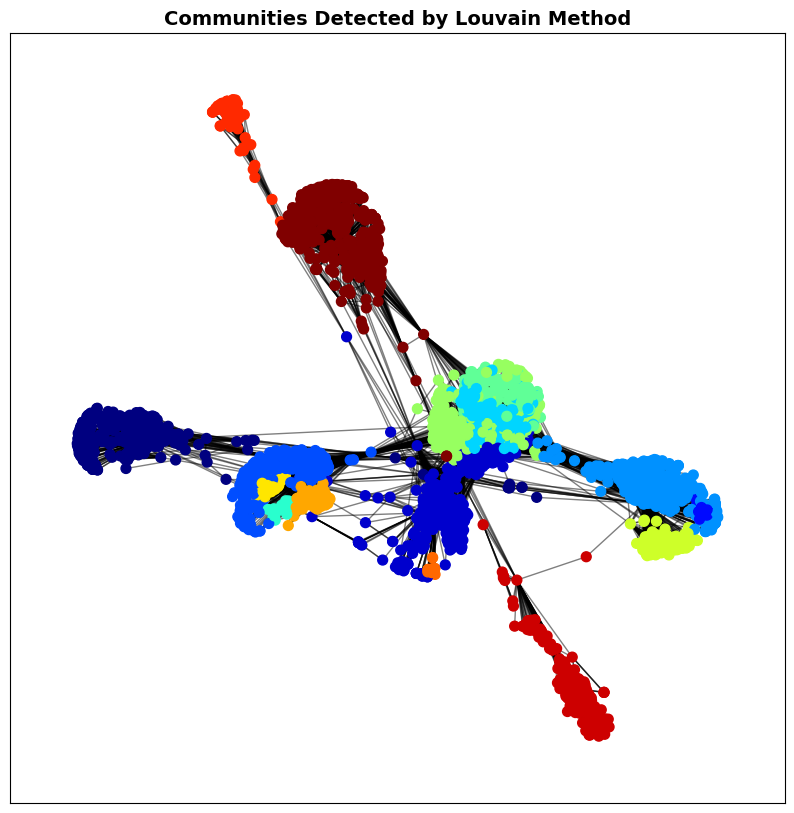

Community 0 (Louvain): 350 nodes
Community 1 (Louvain): 433 nodes
Community 8 (Louvain): 435 nodes
Community 3 (Louvain): 423 nodes
Community 4 (Louvain): 535 nodes
Community 5 (Louvain): 323 nodes
Community 7 (Louvain): 128 nodes
Community 15 (Louvain): 548 nodes
Community 10 (Louvain): 73 nodes
Community 11 (Louvain): 237 nodes
Community 12 (Louvain): 25 nodes
Community 13 (Louvain): 59 nodes
Community 14 (Louvain): 206 nodes
Community 9 (Louvain): 226 nodes
Community 2 (Louvain): 19 nodes
Community 6 (Louvain): 19 nodes


In [67]:
# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)

# Visualize the communities (Louvain)
pos = nx.spring_layout(G)  # position nodes using spring layout
plt.figure(figsize=(10, 10))

# Assign colors to the communities
node_color = [partition[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.jet, node_color=node_color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Communities Detected by Louvain Method")
plt.savefig("Louvain.png")
plt.show()

# Number of communities and sizes
louvain_communities = {}
for node, community_id in partition.items():
    if community_id not in louvain_communities:
        louvain_communities[community_id] = []
    louvain_communities[community_id].append(node)

# Print the number of nodes in each community
for community_id, nodes in louvain_communities.items():
    print(f"Community {community_id} (Louvain): {len(nodes)} nodes")

# Visualizing the Communities Detected by Label Propagation Algorithm (LPA)

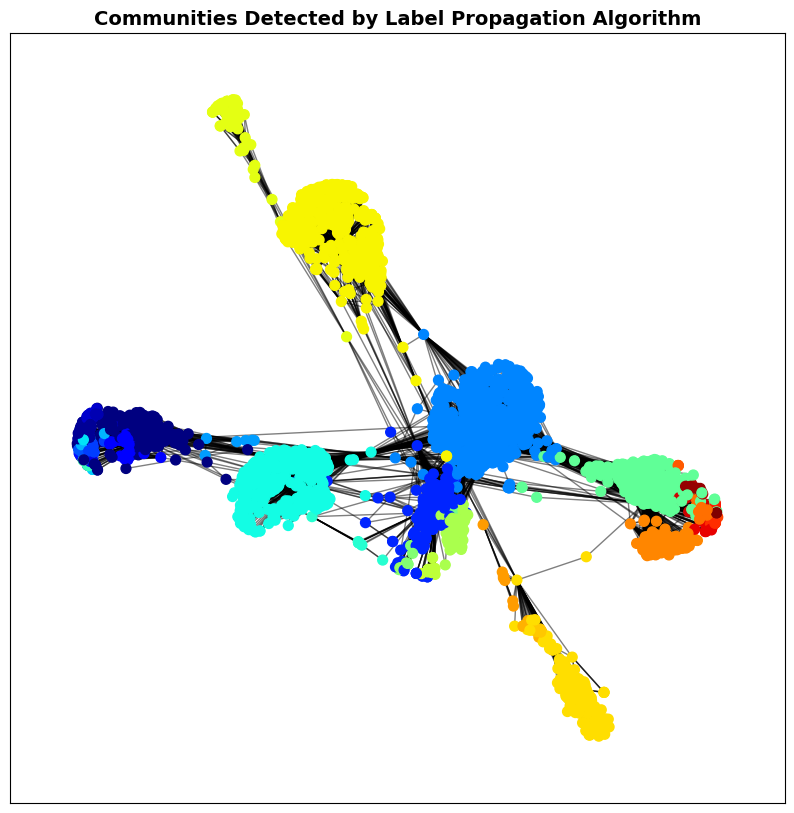

Community 0 (LPA): 198 nodes
Community 1 (LPA): 36 nodes
Community 2 (LPA): 10 nodes
Community 3 (LPA): 8 nodes
Community 4 (LPA): 8 nodes
Community 5 (LPA): 34 nodes
Community 6 (LPA): 2 nodes
Community 7 (LPA): 215 nodes
Community 8 (LPA): 16 nodes
Community 9 (LPA): 3 nodes
Community 10 (LPA): 3 nodes
Community 11 (LPA): 1030 nodes
Community 12 (LPA): 6 nodes
Community 13 (LPA): 7 nodes
Community 14 (LPA): 3 nodes
Community 15 (LPA): 3 nodes
Community 16 (LPA): 753 nodes
Community 17 (LPA): 10 nodes
Community 18 (LPA): 2 nodes
Community 19 (LPA): 2 nodes
Community 20 (LPA): 469 nodes
Community 21 (LPA): 13 nodes
Community 22 (LPA): 9 nodes
Community 23 (LPA): 3 nodes
Community 24 (LPA): 49 nodes
Community 25 (LPA): 25 nodes
Community 26 (LPA): 2 nodes
Community 27 (LPA): 60 nodes
Community 28 (LPA): 547 nodes
Community 29 (LPA): 179 nodes
Community 30 (LPA): 10 nodes
Community 31 (LPA): 9 nodes
Community 32 (LPA): 8 nodes
Community 33 (LPA): 226 nodes
Community 34 (LPA): 19 nodes
Co

In [68]:
# Apply Label Propagation Algorithm
communities_lpa = nx.algorithms.community.label_propagation_communities(G)

# Visualize the communities (LPA)
plt.figure(figsize=(10, 10))

# Assigning each node to a community (color each community differently)
node_color = []
for node in G.nodes():
    for i, community in enumerate(communities_lpa):
        if node in community:
            node_color.append(i)

nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.jet, node_color=node_color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Communities Detected by Label Propagation Algorithm")
plt.savefig("LPA.png")
plt.show()

# Number of communities and sizes (LPA)
lpa_communities = list(communities_lpa)
for i, community in enumerate(lpa_communities):
    print(f"Community {i} (LPA): {len(community)} nodes")